In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from isaac.dataset import read_dataset, prepare_dataset
from isaac.utils import plot_confusion_matrix
from isaac.models import RNNModel, ComplexRNNModel
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS
from isaac.training import evaluate, training_loop

# MASS TRAINING (Humans achieve 46% +- 29%)

## Read dataset and preprocess it

In [4]:
all_trials = read_dataset("data/passive_trials.h5")
train_loader, val_loader, scaler = prepare_dataset(all_trials, MASS_CLASS_COLS, normalise_data=True, 
                                                   batch_size=128, test_size=0.3, equiprobable_training_classes=False)

100%|██████████| 800/800 [00:00<00:00, 1165.13it/s]


In [5]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [6]:
counts

array([181, 177, 202])

In [7]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.3607142857142857


## Define model, loss and optimizer

In [8]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(BASIC_TRAINING_COLS)    # input dimension
hidden_dim = 32  # hidden layer dimension
n_layers = 2     # number of hidden layers
output_dim = 3   # output dimension
dropout = 0.33

model = ComplexRNNModel(input_dim, hidden_dim, n_layers, output_dim, dropout=dropout)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model and plot loss and accuracy

In [9]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=1000)

  0%|          | 1/1000 [00:01<22:50,  1.37s/it]

1.101817774772644 34.642857142857146 32.083333333333336


  0%|          | 2/1000 [00:02<22:39,  1.36s/it]

1.098090934753418 35.535714285714285 28.75


  0%|          | 3/1000 [00:03<22:04,  1.33s/it]

1.0946714878082275 39.464285714285715 32.5


  0%|          | 4/1000 [00:05<22:16,  1.34s/it]

1.0921345472335815 40.0 34.583333333333336


  0%|          | 5/1000 [00:06<22:07,  1.33s/it]

1.0889888763427735 39.642857142857146 37.5


  1%|          | 6/1000 [00:07<21:42,  1.31s/it]

1.0858380317687988 40.535714285714285 37.083333333333336


  1%|          | 7/1000 [00:09<21:49,  1.32s/it]

1.0807005167007446 40.17857142857143 36.666666666666664


  1%|          | 8/1000 [00:10<21:26,  1.30s/it]

1.075045657157898 41.07142857142857 33.75


  1%|          | 9/1000 [00:11<21:39,  1.31s/it]

1.0684481620788575 42.142857142857146 32.083333333333336


  1%|          | 10/1000 [00:13<21:49,  1.32s/it]

1.0611027240753175 42.5 30.833333333333332


  1%|          | 11/1000 [00:14<22:00,  1.34s/it]

1.049264907836914 44.107142857142854 31.666666666666668


  1%|          | 12/1000 [00:15<22:10,  1.35s/it]

1.039919340610504 45.0 30.0


  1%|▏         | 13/1000 [00:17<22:19,  1.36s/it]

1.0272834062576295 47.5 28.75


  1%|▏         | 14/1000 [00:18<22:29,  1.37s/it]

1.009489321708679 48.92857142857143 31.666666666666668


  2%|▏         | 15/1000 [00:20<22:44,  1.39s/it]

0.9911274075508117 49.82142857142857 32.916666666666664


  2%|▏         | 16/1000 [00:21<22:04,  1.35s/it]

0.9708498239517211 53.035714285714285 34.166666666666664


  2%|▏         | 17/1000 [00:22<21:51,  1.33s/it]

0.9509847164154053 54.285714285714285 33.75


  2%|▏         | 18/1000 [00:24<21:46,  1.33s/it]

0.9191032171249389 55.714285714285715 36.25


  2%|▏         | 19/1000 [00:25<21:37,  1.32s/it]

0.8868787288665771 57.32142857142857 37.083333333333336


  2%|▏         | 20/1000 [00:26<21:20,  1.31s/it]

0.8674929738044739 60.17857142857143 38.333333333333336


  2%|▏         | 21/1000 [00:27<21:22,  1.31s/it]

0.8252704739570618 63.57142857142857 36.25


  2%|▏         | 22/1000 [00:29<21:20,  1.31s/it]

0.7948747038841247 65.35714285714286 37.083333333333336


  2%|▏         | 23/1000 [00:30<21:25,  1.32s/it]

0.7625129461288452 69.28571428571429 37.5


  2%|▏         | 24/1000 [00:31<21:23,  1.32s/it]

0.7415570676326751 68.21428571428571 37.916666666666664


  2%|▎         | 25/1000 [00:33<21:08,  1.30s/it]

0.7177167475223541 70.89285714285714 39.583333333333336


  3%|▎         | 26/1000 [00:34<21:01,  1.30s/it]

0.6998129248619079 72.14285714285714 40.0


  3%|▎         | 27/1000 [00:35<20:56,  1.29s/it]

0.6748743534088135 74.10714285714286 40.416666666666664


  3%|▎         | 28/1000 [00:37<21:09,  1.31s/it]

0.649504941701889 76.25 39.583333333333336


  3%|▎         | 29/1000 [00:38<21:01,  1.30s/it]

0.6371929049491882 76.07142857142857 41.666666666666664


  3%|▎         | 30/1000 [00:39<20:54,  1.29s/it]

0.6361811935901642 74.82142857142857 40.0


  3%|▎         | 31/1000 [00:40<21:03,  1.30s/it]

0.6245025336742401 75.17857142857143 40.416666666666664


  3%|▎         | 32/1000 [00:42<21:01,  1.30s/it]

0.6131007671356201 77.67857142857143 39.166666666666664


  3%|▎         | 33/1000 [00:43<21:02,  1.31s/it]

0.5933555662631989 77.32142857142857 37.916666666666664


  3%|▎         | 34/1000 [00:44<21:19,  1.32s/it]

0.6028088331222534 76.78571428571429 39.166666666666664


  4%|▎         | 35/1000 [00:46<21:17,  1.32s/it]

0.591577410697937 78.57142857142857 39.583333333333336


  4%|▎         | 36/1000 [00:47<21:32,  1.34s/it]

0.5661201238632202 78.75 39.166666666666664


  4%|▎         | 37/1000 [00:48<21:41,  1.35s/it]

0.5509324252605439 79.64285714285714 40.416666666666664


  4%|▍         | 38/1000 [00:50<21:18,  1.33s/it]

0.5397209525108337 80.89285714285714 42.916666666666664


  4%|▍         | 39/1000 [00:51<21:07,  1.32s/it]

0.5159287273883819 81.42857142857143 43.75


  4%|▍         | 40/1000 [00:52<21:36,  1.35s/it]

0.511152571439743 81.07142857142857 41.666666666666664


  4%|▍         | 41/1000 [00:54<21:23,  1.34s/it]

0.5015426754951477 82.14285714285714 42.083333333333336


  4%|▍         | 42/1000 [00:55<21:23,  1.34s/it]

0.4923546314239502 81.78571428571429 44.583333333333336


  4%|▍         | 43/1000 [00:56<20:57,  1.31s/it]

0.5117971718311309 80.35714285714286 41.25


  4%|▍         | 44/1000 [00:58<20:50,  1.31s/it]

0.5172630548477173 80.89285714285714 42.5


  4%|▍         | 45/1000 [00:59<20:51,  1.31s/it]

0.5041424870491028 81.96428571428571 43.75


  5%|▍         | 46/1000 [01:00<21:00,  1.32s/it]

0.46719829738140106 82.85714285714286 44.583333333333336


  5%|▍         | 47/1000 [01:02<20:48,  1.31s/it]

0.4484588712453842 83.39285714285714 43.75


  5%|▍         | 48/1000 [01:03<20:46,  1.31s/it]

0.4269611954689026 84.82142857142857 45.416666666666664


  5%|▍         | 49/1000 [01:04<20:49,  1.31s/it]

0.41678095459938047 86.07142857142857 46.25


  5%|▌         | 50/1000 [01:06<20:44,  1.31s/it]

0.39913245141506193 85.71428571428571 45.0


  5%|▌         | 51/1000 [01:07<20:50,  1.32s/it]

0.413253852725029 86.96428571428571 45.0


  5%|▌         | 52/1000 [01:08<21:04,  1.33s/it]

0.3905146986246109 81.78571428571429 43.333333333333336


  5%|▌         | 53/1000 [01:10<21:23,  1.36s/it]

0.5683557093143463 80.17857142857143 42.916666666666664


  5%|▌         | 54/1000 [01:11<21:13,  1.35s/it]

0.47273715436458585 79.46428571428571 45.833333333333336


  6%|▌         | 55/1000 [01:12<21:02,  1.34s/it]

0.5279782980680465 80.35714285714286 45.0


  6%|▌         | 56/1000 [01:14<20:42,  1.32s/it]

0.5145779967308044 82.14285714285714 45.416666666666664


  6%|▌         | 57/1000 [01:15<20:47,  1.32s/it]

0.4875838875770569 82.67857142857143 44.166666666666664


  6%|▌         | 58/1000 [01:16<20:25,  1.30s/it]

0.4382441908121109 85.71428571428571 44.583333333333336


  6%|▌         | 59/1000 [01:17<20:05,  1.28s/it]

0.38251314759254457 86.07142857142857 45.833333333333336


  6%|▌         | 60/1000 [01:19<19:53,  1.27s/it]

0.37450607419013976 87.32142857142857 48.75


  6%|▌         | 61/1000 [01:20<19:56,  1.27s/it]

0.35223986208438873 87.5 49.166666666666664


  6%|▌         | 62/1000 [01:21<19:48,  1.27s/it]

0.34232580065727236 87.67857142857143 46.666666666666664


  6%|▋         | 63/1000 [01:22<19:40,  1.26s/it]

0.330346842110157 88.21428571428571 47.5


  6%|▋         | 64/1000 [01:24<19:36,  1.26s/it]

0.32200358957052233 88.92857142857143 46.666666666666664


  6%|▋         | 65/1000 [01:25<19:59,  1.28s/it]

0.2930885970592499 88.75 45.833333333333336


  7%|▋         | 66/1000 [01:26<19:51,  1.28s/it]

0.2896894499659538 90.0 47.5


  7%|▋         | 67/1000 [01:28<19:39,  1.26s/it]

0.3077343314886093 89.28571428571429 48.333333333333336


  7%|▋         | 68/1000 [01:29<19:39,  1.27s/it]

0.3196738973259926 89.64285714285714 45.416666666666664


  7%|▋         | 69/1000 [01:30<19:37,  1.26s/it]

0.31290948688983916 90.71428571428571 47.5


  7%|▋         | 70/1000 [01:31<20:03,  1.29s/it]

0.331914484500885 88.92857142857143 44.583333333333336


  7%|▋         | 71/1000 [01:33<19:49,  1.28s/it]

0.34759762287139895 89.64285714285714 45.0


  7%|▋         | 72/1000 [01:34<19:44,  1.28s/it]

0.3085619196295738 90.53571428571429 47.5


  7%|▋         | 73/1000 [01:35<20:05,  1.30s/it]

0.30383315682411194 91.07142857142857 46.25


  7%|▋         | 74/1000 [01:37<20:22,  1.32s/it]

0.3012048006057739 91.07142857142857 45.416666666666664


  8%|▊         | 75/1000 [01:38<20:12,  1.31s/it]

0.2770909771323204 91.60714285714286 46.666666666666664


  8%|▊         | 76/1000 [01:39<20:13,  1.31s/it]

0.2832305520772934 91.78571428571429 47.083333333333336


  8%|▊         | 77/1000 [01:41<20:11,  1.31s/it]

0.2816808193922043 92.67857142857143 45.833333333333336


  8%|▊         | 78/1000 [01:42<20:04,  1.31s/it]

0.24128473550081253 91.96428571428571 49.583333333333336


  8%|▊         | 79/1000 [01:43<19:49,  1.29s/it]

0.2785912320017815 93.03571428571429 50.0


  8%|▊         | 80/1000 [01:44<19:49,  1.29s/it]

0.2600632429122925 90.89285714285714 47.5


  8%|▊         | 81/1000 [01:46<20:18,  1.33s/it]

0.2790342792868614 92.14285714285714 48.333333333333336


  8%|▊         | 82/1000 [01:47<20:52,  1.36s/it]

0.24323515444993973 92.5 47.5


  8%|▊         | 83/1000 [01:49<21:13,  1.39s/it]

0.2089561402797699 93.21428571428571 45.833333333333336


  8%|▊         | 84/1000 [01:50<21:28,  1.41s/it]

0.22705378085374833 93.92857142857143 46.25


  8%|▊         | 85/1000 [01:52<21:29,  1.41s/it]

0.21067706421017646 92.67857142857143 47.916666666666664


  9%|▊         | 86/1000 [01:53<21:38,  1.42s/it]

0.21808530390262604 93.92857142857143 47.5


  9%|▊         | 87/1000 [01:54<21:20,  1.40s/it]

0.18907334581017493 94.82142857142857 45.416666666666664


  9%|▉         | 88/1000 [01:56<20:46,  1.37s/it]

0.17557364627718924 95.17857142857143 47.5


  9%|▉         | 89/1000 [01:57<20:16,  1.34s/it]

0.1863778203725815 95.17857142857143 48.333333333333336


  9%|▉         | 90/1000 [01:58<20:36,  1.36s/it]

0.16259068846702576 95.35714285714286 47.916666666666664


  9%|▉         | 91/1000 [02:00<21:02,  1.39s/it]

0.168928674608469 95.17857142857143 46.25


  9%|▉         | 92/1000 [02:01<21:20,  1.41s/it]

0.17000663056969642 95.17857142857143 46.666666666666664


  9%|▉         | 93/1000 [02:03<21:33,  1.43s/it]

0.15475214570760726 95.89285714285714 45.833333333333336


  9%|▉         | 94/1000 [02:04<21:42,  1.44s/it]

0.13931087777018547 95.0 47.083333333333336


 10%|▉         | 95/1000 [02:06<21:27,  1.42s/it]

0.15638614520430566 96.07142857142857 45.833333333333336


 10%|▉         | 96/1000 [02:07<20:49,  1.38s/it]

0.1566414289176464 95.89285714285714 47.5


 10%|▉         | 97/1000 [02:08<21:00,  1.40s/it]

0.15240857526659965 95.89285714285714 47.5


 10%|▉         | 98/1000 [02:10<21:12,  1.41s/it]

0.13960717543959617 95.35714285714286 47.916666666666664


 10%|▉         | 99/1000 [02:11<21:21,  1.42s/it]

0.13091039881110192 96.42857142857143 47.5


 10%|█         | 100/1000 [02:13<20:59,  1.40s/it]

0.14310716688632966 95.89285714285714 47.083333333333336


 10%|█         | 101/1000 [02:14<20:31,  1.37s/it]

0.1524125561118126 96.78571428571429 48.333333333333336


 10%|█         | 102/1000 [02:15<19:56,  1.33s/it]

0.1359148234128952 96.78571428571429 49.583333333333336


 10%|█         | 103/1000 [02:16<19:45,  1.32s/it]

0.1379762202501297 97.14285714285714 48.75


 10%|█         | 104/1000 [02:18<19:54,  1.33s/it]

0.13738411217927932 96.78571428571429 49.166666666666664


 10%|█         | 105/1000 [02:19<19:28,  1.31s/it]

0.11945355832576751 96.96428571428571 48.75


 11%|█         | 106/1000 [02:20<19:16,  1.29s/it]

0.11185874082148076 95.53571428571429 48.333333333333336


 11%|█         | 107/1000 [02:22<19:15,  1.29s/it]

0.16332571357488632 95.17857142857143 49.583333333333336


 11%|█         | 108/1000 [02:23<19:18,  1.30s/it]

0.23842143416404724 94.46428571428571 50.0


 11%|█         | 109/1000 [02:24<19:20,  1.30s/it]

0.22197046428918837 94.10714285714286 49.583333333333336


 11%|█         | 110/1000 [02:25<19:21,  1.31s/it]

0.2252908319234848 95.53571428571429 47.5


 11%|█         | 111/1000 [02:27<19:13,  1.30s/it]

0.21454140841960906 95.17857142857143 46.25


 11%|█         | 112/1000 [02:28<19:22,  1.31s/it]

0.22892709523439408 93.03571428571429 50.416666666666664


 11%|█▏        | 113/1000 [02:29<19:38,  1.33s/it]

0.26386030316352843 93.75 47.916666666666664


 11%|█▏        | 114/1000 [02:31<20:03,  1.36s/it]

0.20750775784254075 92.14285714285714 47.083333333333336


 12%|█▏        | 115/1000 [02:32<20:24,  1.38s/it]

0.43039306402206423 89.64285714285714 45.0


 12%|█▏        | 116/1000 [02:34<20:46,  1.41s/it]

0.40425497889518736 89.64285714285714 44.583333333333336


 12%|█▏        | 117/1000 [02:35<21:00,  1.43s/it]

0.3486237019300461 91.07142857142857 46.25


 12%|█▏        | 118/1000 [02:37<21:07,  1.44s/it]

0.3044263631105423 92.85714285714286 47.083333333333336


 12%|█▏        | 119/1000 [02:38<20:59,  1.43s/it]

0.2452190101146698 93.39285714285714 48.333333333333336


 12%|█▏        | 120/1000 [02:39<20:22,  1.39s/it]

0.24019743204116822 94.46428571428571 48.333333333333336


 12%|█▏        | 121/1000 [02:41<19:49,  1.35s/it]

0.20218093544244767 95.0 48.75


 12%|█▏        | 122/1000 [02:42<19:48,  1.35s/it]

0.1970459371805191 95.89285714285714 50.416666666666664


 12%|█▏        | 123/1000 [02:43<19:39,  1.35s/it]

0.18281580209732057 95.71428571428571 50.0


 12%|█▏        | 124/1000 [02:45<20:02,  1.37s/it]

0.16641711294651032 95.53571428571429 51.666666666666664


 12%|█▎        | 125/1000 [02:46<19:57,  1.37s/it]

0.1468559443950653 96.07142857142857 52.083333333333336


 13%|█▎        | 126/1000 [02:47<19:25,  1.33s/it]

0.1418011873960495 97.14285714285714 51.25


 13%|█▎        | 127/1000 [02:49<18:54,  1.30s/it]

0.13519643098115922 96.78571428571429 52.083333333333336


 13%|█▎        | 128/1000 [02:50<18:21,  1.26s/it]

0.1311919093132019 97.14285714285714 51.666666666666664


 13%|█▎        | 129/1000 [02:51<18:14,  1.26s/it]

0.12064410075545311 97.14285714285714 50.0


 13%|█▎        | 130/1000 [02:52<17:50,  1.23s/it]

0.10959445685148239 96.96428571428571 51.25


 13%|█▎        | 131/1000 [02:53<17:52,  1.23s/it]

0.13531688898801802 96.96428571428571 50.833333333333336


 13%|█▎        | 132/1000 [02:55<17:55,  1.24s/it]

0.12630049511790276 97.32142857142857 50.416666666666664


 13%|█▎        | 133/1000 [02:56<17:39,  1.22s/it]

0.11679961159825325 97.14285714285714 49.583333333333336


 13%|█▎        | 134/1000 [02:57<17:44,  1.23s/it]

0.1119864083826542 97.5 50.416666666666664


 14%|█▎        | 135/1000 [02:58<17:48,  1.24s/it]

0.10496405512094498 97.5 50.0


 14%|█▎        | 136/1000 [03:00<17:47,  1.24s/it]

0.09397147819399834 97.5 50.0


 14%|█▎        | 137/1000 [03:01<17:50,  1.24s/it]

0.08558874167501926 97.5 50.0


 14%|█▍        | 138/1000 [03:02<17:49,  1.24s/it]

0.09273395389318466 97.5 50.833333333333336


 14%|█▍        | 139/1000 [03:03<17:55,  1.25s/it]

0.09217781610786915 96.96428571428571 49.583333333333336


 14%|█▍        | 140/1000 [03:05<17:54,  1.25s/it]

0.08831062838435173 97.14285714285714 49.583333333333336


 14%|█▍        | 141/1000 [03:06<18:06,  1.26s/it]

0.08855786472558975 96.96428571428571 49.166666666666664


 14%|█▍        | 142/1000 [03:07<18:16,  1.28s/it]

0.0784335631877184 97.5 49.583333333333336


 14%|█▍        | 143/1000 [03:09<18:17,  1.28s/it]

0.07692405842244625 97.5 49.583333333333336


 14%|█▍        | 144/1000 [03:10<18:15,  1.28s/it]

0.07931518740952015 97.5 49.583333333333336


 14%|█▍        | 145/1000 [03:11<18:11,  1.28s/it]

0.07744256742298603 97.67857142857143 50.416666666666664


 15%|█▍        | 146/1000 [03:12<18:39,  1.31s/it]

0.07240278571844101 97.67857142857143 50.0


 15%|█▍        | 147/1000 [03:14<18:41,  1.31s/it]

0.07373599000275136 97.85714285714286 50.416666666666664


 15%|█▍        | 148/1000 [03:15<18:49,  1.33s/it]

0.06754183657467365 97.85714285714286 50.0


 15%|█▍        | 149/1000 [03:16<18:40,  1.32s/it]

0.06614688336849213 97.85714285714286 50.416666666666664


 15%|█▌        | 150/1000 [03:18<18:34,  1.31s/it]

0.0658848199993372 97.85714285714286 50.416666666666664


 15%|█▌        | 151/1000 [03:19<18:09,  1.28s/it]

0.0728457286953926 98.03571428571429 50.416666666666664


 15%|█▌        | 152/1000 [03:20<17:59,  1.27s/it]

0.07061805948615074 98.03571428571429 48.75


 15%|█▌        | 153/1000 [03:21<17:53,  1.27s/it]

0.0735053226351738 97.5 48.75


 15%|█▌        | 154/1000 [03:23<17:48,  1.26s/it]

0.08446220867335796 97.85714285714286 47.916666666666664


 16%|█▌        | 155/1000 [03:24<17:46,  1.26s/it]

0.07292518950998783 98.03571428571429 48.333333333333336


 16%|█▌        | 156/1000 [03:25<18:03,  1.28s/it]

0.08061004839837552 98.03571428571429 49.583333333333336


 16%|█▌        | 157/1000 [03:27<18:19,  1.30s/it]

0.07090007327497005 97.67857142857143 49.583333333333336


 16%|█▌        | 158/1000 [03:28<18:47,  1.34s/it]

0.059149363078176975 97.14285714285714 50.0


 16%|█▌        | 159/1000 [03:30<19:11,  1.37s/it]

0.11107593514025212 97.5 49.583333333333336


 16%|█▌        | 160/1000 [03:31<19:29,  1.39s/it]

0.11067598760128021 97.32142857142857 48.75


 16%|█▌        | 161/1000 [03:32<19:39,  1.41s/it]

0.10560684688389302 98.03571428571429 48.333333333333336


 16%|█▌        | 162/1000 [03:34<19:47,  1.42s/it]

0.06302360408008098 96.42857142857143 49.166666666666664


 16%|█▋        | 163/1000 [03:35<19:02,  1.37s/it]

0.14664783626794814 96.78571428571429 49.166666666666664


 16%|█▋        | 164/1000 [03:37<19:20,  1.39s/it]

0.1467265874147415 96.96428571428571 48.75


 16%|█▋        | 165/1000 [03:38<19:35,  1.41s/it]

0.1282622054219246 97.14285714285714 50.0


 17%|█▋        | 166/1000 [03:39<19:34,  1.41s/it]

0.12391221225261688 97.5 48.75


 17%|█▋        | 167/1000 [03:41<19:44,  1.42s/it]

0.11513515412807465 97.67857142857143 50.0


 17%|█▋        | 168/1000 [03:42<19:38,  1.42s/it]

0.1059667557477951 97.32142857142857 50.416666666666664


 17%|█▋        | 169/1000 [03:44<19:31,  1.41s/it]

0.20415283143520355 87.85714285714286 45.833333333333336


 17%|█▋        | 170/1000 [03:45<19:33,  1.41s/it]

0.6414768993854523 84.64285714285714 42.916666666666664


 17%|█▋        | 171/1000 [03:47<19:32,  1.41s/it]

0.4946331024169922 85.53571428571429 43.75


 17%|█▋        | 172/1000 [03:48<19:32,  1.42s/it]

0.4370961904525757 85.35714285714286 42.916666666666664


 17%|█▋        | 173/1000 [03:49<19:32,  1.42s/it]

0.3398378849029541 88.21428571428571 44.166666666666664


 17%|█▋        | 174/1000 [03:51<19:28,  1.41s/it]

0.30458950698375703 90.35714285714286 46.25


 18%|█▊        | 175/1000 [03:52<19:28,  1.42s/it]

0.26894381642341614 93.39285714285714 46.25


 18%|█▊        | 176/1000 [03:54<19:32,  1.42s/it]

0.24273804277181626 93.39285714285714 47.916666666666664


 18%|█▊        | 177/1000 [03:55<19:28,  1.42s/it]

0.206212817132473 93.92857142857143 47.5


 18%|█▊        | 178/1000 [03:56<19:26,  1.42s/it]

0.18359074145555496 95.35714285714286 48.75


 18%|█▊        | 179/1000 [03:58<19:24,  1.42s/it]

0.17030587643384934 96.25 49.166666666666664


 18%|█▊        | 180/1000 [03:59<19:26,  1.42s/it]

0.161469267308712 96.60714285714286 50.0


 18%|█▊        | 181/1000 [04:01<19:22,  1.42s/it]

0.13858390375971794 96.60714285714286 49.166666666666664


 18%|█▊        | 182/1000 [04:02<19:19,  1.42s/it]

0.13469543308019638 96.60714285714286 49.166666666666664


 18%|█▊        | 183/1000 [04:04<19:17,  1.42s/it]

0.1189882755279541 97.14285714285714 49.583333333333336


 18%|█▊        | 184/1000 [04:05<19:17,  1.42s/it]

0.1195696584880352 97.32142857142857 50.0


 18%|█▊        | 185/1000 [04:06<19:11,  1.41s/it]

0.1043239638209343 97.32142857142857 49.583333333333336


 19%|█▊        | 186/1000 [04:08<19:08,  1.41s/it]

0.0961800679564476 97.5 50.416666666666664


 19%|█▊        | 187/1000 [04:09<19:09,  1.41s/it]

0.09367687702178955 97.5 50.833333333333336


 19%|█▉        | 188/1000 [04:11<19:08,  1.41s/it]

0.0979822400957346 97.32142857142857 50.833333333333336


 19%|█▉        | 189/1000 [04:12<19:10,  1.42s/it]

0.09899891689419746 97.67857142857143 51.25


 19%|█▉        | 190/1000 [04:13<19:07,  1.42s/it]

0.08042193241417409 98.03571428571429 50.0


 19%|█▉        | 191/1000 [04:15<19:02,  1.41s/it]

0.07957211323082447 98.03571428571429 49.583333333333336


 19%|█▉        | 192/1000 [04:16<19:02,  1.41s/it]

0.07363559119403362 98.21428571428571 49.583333333333336


 19%|█▉        | 193/1000 [04:18<18:59,  1.41s/it]

0.07504898980259896 98.03571428571429 50.0


 19%|█▉        | 194/1000 [04:19<19:02,  1.42s/it]

0.07552564069628716 98.21428571428571 51.25


 20%|█▉        | 195/1000 [04:20<18:57,  1.41s/it]

0.07423101961612702 98.03571428571429 51.25


 20%|█▉        | 196/1000 [04:22<18:48,  1.40s/it]

0.06392397992312908 98.21428571428571 50.0


 20%|█▉        | 197/1000 [04:23<18:35,  1.39s/it]

0.06470687985420227 98.21428571428571 49.583333333333336


 20%|█▉        | 198/1000 [04:25<18:14,  1.36s/it]

0.06044844686985016 97.5 49.166666666666664


 20%|█▉        | 199/1000 [04:26<18:09,  1.36s/it]

0.12400314100086689 97.32142857142857 48.75


 20%|██        | 200/1000 [04:27<18:01,  1.35s/it]

0.11795569956302643 96.07142857142857 49.583333333333336


 20%|██        | 201/1000 [04:29<17:58,  1.35s/it]

0.10343227982521057 97.32142857142857 50.0


 20%|██        | 202/1000 [04:30<17:40,  1.33s/it]

0.09643476940691471 97.5 50.0


 20%|██        | 203/1000 [04:31<17:37,  1.33s/it]

0.08553885761648417 97.67857142857143 50.416666666666664


 20%|██        | 204/1000 [04:32<17:22,  1.31s/it]

0.09058259092271329 98.03571428571429 50.416666666666664


 20%|██        | 205/1000 [04:34<17:22,  1.31s/it]

0.07990649454295636 98.21428571428571 50.0


 21%|██        | 206/1000 [04:35<17:34,  1.33s/it]

0.06675580479204654 97.67857142857143 50.416666666666664


 21%|██        | 207/1000 [04:36<17:19,  1.31s/it]

0.08013225980103016 98.03571428571429 50.416666666666664


 21%|██        | 208/1000 [04:38<17:15,  1.31s/it]

0.0745338749140501 98.03571428571429 50.833333333333336


 21%|██        | 209/1000 [04:39<17:13,  1.31s/it]

0.09361776858568191 97.67857142857143 50.416666666666664


 21%|██        | 210/1000 [04:40<17:03,  1.30s/it]

0.09817464426159858 97.85714285714286 49.583333333333336


 21%|██        | 211/1000 [04:42<17:19,  1.32s/it]

0.08199557736515999 97.67857142857143 48.75


 21%|██        | 212/1000 [04:43<17:07,  1.30s/it]

0.10162023156881332 98.03571428571429 47.916666666666664


 21%|██▏       | 213/1000 [04:44<17:28,  1.33s/it]

0.08285299278795719 97.85714285714286 49.166666666666664


 21%|██▏       | 214/1000 [04:46<17:54,  1.37s/it]

0.06353193409740925 97.14285714285714 49.166666666666664


 22%|██▏       | 215/1000 [04:47<18:11,  1.39s/it]

0.07256729304790496 97.85714285714286 49.166666666666664


 22%|██▏       | 216/1000 [04:49<18:21,  1.41s/it]

0.06640670411288738 98.39285714285714 49.583333333333336


 22%|██▏       | 217/1000 [04:50<18:29,  1.42s/it]

0.07135872580111027 98.21428571428571 51.666666666666664


 22%|██▏       | 218/1000 [04:51<17:57,  1.38s/it]

0.05869324877858162 98.03571428571429 50.416666666666664


 22%|██▏       | 219/1000 [04:53<17:30,  1.34s/it]

0.07977649495005608 98.21428571428571 52.083333333333336


 22%|██▏       | 220/1000 [04:54<17:22,  1.34s/it]

0.07432970032095909 98.21428571428571 52.916666666666664


 22%|██▏       | 221/1000 [04:55<17:23,  1.34s/it]

0.08820306360721589 97.67857142857143 50.416666666666664


 22%|██▏       | 222/1000 [04:57<17:17,  1.33s/it]

0.1065148502588272 97.85714285714286 51.666666666666664


 22%|██▏       | 223/1000 [04:58<17:04,  1.32s/it]

0.06592346206307412 98.03571428571429 51.666666666666664


 22%|██▏       | 224/1000 [04:59<17:05,  1.32s/it]

0.06253388337790966 97.32142857142857 49.583333333333336


 22%|██▎       | 225/1000 [05:01<17:01,  1.32s/it]

0.17319569140672683 95.53571428571429 49.583333333333336


 23%|██▎       | 226/1000 [05:02<17:19,  1.34s/it]

0.18181875646114348 96.78571428571429 50.416666666666664


 23%|██▎       | 227/1000 [05:03<17:21,  1.35s/it]

0.12814222127199174 96.96428571428571 51.666666666666664


 23%|██▎       | 228/1000 [05:05<17:05,  1.33s/it]

0.1361520230770111 97.5 50.833333333333336


 23%|██▎       | 229/1000 [05:06<16:57,  1.32s/it]

0.19207318425178527 91.60714285714286 52.5


 23%|██▎       | 230/1000 [05:07<17:03,  1.33s/it]

0.3520298421382904 92.5 51.666666666666664


 23%|██▎       | 231/1000 [05:09<16:51,  1.31s/it]

0.2684484302997589 94.46428571428571 50.833333333333336


 23%|██▎       | 232/1000 [05:10<16:44,  1.31s/it]

0.26005476117134096 95.0 49.166666666666664


 23%|██▎       | 233/1000 [05:11<16:54,  1.32s/it]

0.18121915757656099 96.07142857142857 48.75


 23%|██▎       | 234/1000 [05:13<17:05,  1.34s/it]

0.13705641627311707 97.14285714285714 50.416666666666664


 24%|██▎       | 235/1000 [05:14<16:57,  1.33s/it]

0.11952055543661118 97.67857142857143 50.833333333333336


 24%|██▎       | 236/1000 [05:15<16:42,  1.31s/it]

0.11012816727161408 97.85714285714286 50.833333333333336


 24%|██▎       | 237/1000 [05:16<16:23,  1.29s/it]

0.09290791228413582 98.03571428571429 50.416666666666664


 24%|██▍       | 238/1000 [05:18<16:10,  1.27s/it]

0.08172647058963775 98.03571428571429 50.833333333333336


 24%|██▍       | 239/1000 [05:19<16:01,  1.26s/it]

0.07875330820679664 98.03571428571429 50.833333333333336


 24%|██▍       | 240/1000 [05:20<15:53,  1.25s/it]

0.07636395692825318 97.85714285714286 50.833333333333336


 24%|██▍       | 241/1000 [05:21<15:48,  1.25s/it]

0.08918981552124024 98.03571428571429 50.833333333333336


 24%|██▍       | 242/1000 [05:23<15:44,  1.25s/it]

0.06023026555776596 98.03571428571429 50.416666666666664


 24%|██▍       | 243/1000 [05:24<15:56,  1.26s/it]

0.06750529855489731 98.03571428571429 50.0


 24%|██▍       | 244/1000 [05:25<16:06,  1.28s/it]

0.06114527136087418 98.21428571428571 50.0


 24%|██▍       | 245/1000 [05:27<16:29,  1.31s/it]

0.06448094174265862 98.21428571428571 50.416666666666664


 25%|██▍       | 246/1000 [05:28<16:50,  1.34s/it]

0.0604261577129364 98.21428571428571 50.416666666666664


 25%|██▍       | 247/1000 [05:29<17:09,  1.37s/it]

0.05783926658332348 98.21428571428571 50.416666666666664


 25%|██▍       | 248/1000 [05:31<17:20,  1.38s/it]

0.05527286753058434 98.57142857142857 50.416666666666664


 25%|██▍       | 249/1000 [05:32<17:25,  1.39s/it]

0.049208206310868266 98.57142857142857 50.416666666666664


 25%|██▌       | 250/1000 [05:34<17:35,  1.41s/it]

0.05359843298792839 98.57142857142857 50.833333333333336


 25%|██▌       | 251/1000 [05:35<17:40,  1.42s/it]

0.04058968815952539 98.75 50.833333333333336


 25%|██▌       | 252/1000 [05:36<17:19,  1.39s/it]

0.03763056378811598 98.75 51.666666666666664


 25%|██▌       | 253/1000 [05:38<17:06,  1.37s/it]

0.05679521858692169 96.07142857142857 51.666666666666664


 25%|██▌       | 254/1000 [05:39<16:52,  1.36s/it]

0.18027108162641525 93.92857142857143 48.75


 26%|██▌       | 255/1000 [05:40<16:30,  1.33s/it]

0.19854574501514435 93.21428571428571 47.916666666666664


 26%|██▌       | 256/1000 [05:42<16:09,  1.30s/it]

0.19696734398603438 95.53571428571429 47.5


 26%|██▌       | 257/1000 [05:43<16:19,  1.32s/it]

0.16017438061535358 95.17857142857143 50.416666666666664


 26%|██▌       | 258/1000 [05:44<16:22,  1.32s/it]

0.15365955419838428 95.0 50.0


 26%|██▌       | 259/1000 [05:46<16:10,  1.31s/it]

0.15465469621121883 95.71428571428571 50.416666666666664


 26%|██▌       | 260/1000 [05:47<16:16,  1.32s/it]

0.1432516895234585 96.25 50.416666666666664


 26%|██▌       | 261/1000 [05:48<16:36,  1.35s/it]

0.13927293792366982 96.60714285714286 51.666666666666664


 26%|██▌       | 262/1000 [05:50<16:48,  1.37s/it]

0.13642905540764333 95.71428571428571 49.583333333333336


 26%|██▋       | 263/1000 [05:51<17:05,  1.39s/it]

0.1381857968866825 96.07142857142857 47.916666666666664


 26%|██▋       | 264/1000 [05:53<17:16,  1.41s/it]

0.11692456603050232 96.25 48.333333333333336


 26%|██▋       | 265/1000 [05:54<17:24,  1.42s/it]

0.11423708908259869 96.25 47.916666666666664


 27%|██▋       | 266/1000 [05:56<17:26,  1.43s/it]

0.10140042454004287 96.25 49.166666666666664


 27%|██▋       | 267/1000 [05:57<17:27,  1.43s/it]

0.1069323554635048 96.42857142857143 48.75


 27%|██▋       | 268/1000 [05:58<17:11,  1.41s/it]

0.0994426216930151 97.14285714285714 48.75


 27%|██▋       | 269/1000 [06:00<16:26,  1.35s/it]

0.10750620625913143 97.32142857142857 47.916666666666664


 27%|██▋       | 270/1000 [06:01<16:56,  1.39s/it]

0.08925557695329189 97.14285714285714 48.333333333333336


 27%|██▋       | 271/1000 [06:03<17:26,  1.44s/it]

0.07241002712398767 97.85714285714286 48.75


 27%|██▋       | 272/1000 [06:04<17:06,  1.41s/it]

0.08771144747734069 97.67857142857143 48.333333333333336


 27%|██▋       | 273/1000 [06:05<16:36,  1.37s/it]

0.07435948513448239 98.03571428571429 48.75


 27%|██▋       | 274/1000 [06:07<16:48,  1.39s/it]

0.0750684019178152 96.96428571428571 48.333333333333336


 28%|██▊       | 275/1000 [06:08<16:39,  1.38s/it]

0.08457665741443635 96.96428571428571 47.5


 28%|██▊       | 276/1000 [06:09<15:55,  1.32s/it]

0.08915805332362652 97.32142857142857 47.916666666666664


 28%|██▊       | 277/1000 [06:10<15:55,  1.32s/it]

0.07188394106924534 97.67857142857143 49.166666666666664


 28%|██▊       | 278/1000 [06:12<16:46,  1.39s/it]

0.0700062770396471 97.5 50.0


 28%|██▊       | 279/1000 [06:13<16:12,  1.35s/it]

0.06496705561876297 97.85714285714286 50.0


 28%|██▊       | 280/1000 [06:15<16:28,  1.37s/it]

0.0726898718625307 97.85714285714286 49.583333333333336


 28%|██▊       | 281/1000 [06:16<16:01,  1.34s/it]

0.05889834947884083 97.85714285714286 49.166666666666664


 28%|██▊       | 282/1000 [06:17<15:41,  1.31s/it]

0.07645992413163186 97.67857142857143 48.333333333333336


 28%|██▊       | 283/1000 [06:18<15:27,  1.29s/it]

0.06644761711359023 97.85714285714286 48.75


 28%|██▊       | 284/1000 [06:20<15:32,  1.30s/it]

0.060369251668453215 97.85714285714286 49.583333333333336


 28%|██▊       | 285/1000 [06:21<16:18,  1.37s/it]

0.05763017535209656 98.03571428571429 50.0


 29%|██▊       | 286/1000 [06:23<15:55,  1.34s/it]

0.05165252983570099 98.03571428571429 49.166666666666664


 29%|██▊       | 287/1000 [06:24<16:22,  1.38s/it]

0.0470553170889616 98.21428571428571 49.166666666666664


 29%|██▉       | 288/1000 [06:25<16:35,  1.40s/it]

0.05116928741335869 98.03571428571429 50.0


 29%|██▉       | 289/1000 [06:27<16:11,  1.37s/it]

0.0494675824418664 98.03571428571429 48.75


 29%|██▉       | 290/1000 [06:28<16:22,  1.38s/it]

0.047961939312517646 98.03571428571429 48.75


 29%|██▉       | 291/1000 [06:30<16:35,  1.40s/it]

0.05009348541498184 98.21428571428571 46.666666666666664


 29%|██▉       | 292/1000 [06:31<16:39,  1.41s/it]

0.060435221344232556 97.85714285714286 47.083333333333336


 29%|██▉       | 293/1000 [06:33<16:45,  1.42s/it]

0.06874335408210755 97.67857142857143 46.666666666666664


 29%|██▉       | 294/1000 [06:34<16:47,  1.43s/it]

0.06527727488428355 97.85714285714286 47.916666666666664


 30%|██▉       | 295/1000 [06:35<16:51,  1.43s/it]

0.06132744494825602 97.85714285714286 47.083333333333336


 30%|██▉       | 296/1000 [06:37<16:54,  1.44s/it]

0.053698410652577876 98.21428571428571 46.25


 30%|██▉       | 297/1000 [06:38<16:53,  1.44s/it]

0.060804137587547304 98.21428571428571 47.916666666666664


 30%|██▉       | 298/1000 [06:40<16:54,  1.44s/it]

0.05851810276508331 98.03571428571429 48.333333333333336


 30%|██▉       | 299/1000 [06:41<16:54,  1.45s/it]

0.054601078666746614 98.21428571428571 46.666666666666664


 30%|███       | 300/1000 [06:43<16:54,  1.45s/it]

0.04778832886368036 98.03571428571429 47.083333333333336


 30%|███       | 301/1000 [06:44<16:27,  1.41s/it]

0.045671555772423746 98.03571428571429 48.333333333333336


 30%|███       | 302/1000 [06:45<16:28,  1.42s/it]

0.05772306825965643 98.21428571428571 47.916666666666664


 30%|███       | 303/1000 [06:47<16:33,  1.43s/it]

0.043085465859621766 98.21428571428571 49.166666666666664


 30%|███       | 304/1000 [06:48<16:37,  1.43s/it]

0.0462029280140996 98.39285714285714 48.75


 30%|███       | 305/1000 [06:50<16:39,  1.44s/it]

0.04525983948260546 98.03571428571429 49.166666666666664


 31%|███       | 306/1000 [06:51<16:21,  1.41s/it]

0.03764713797718287 98.21428571428571 50.0


 31%|███       | 307/1000 [06:53<16:25,  1.42s/it]

0.055376367270946504 98.39285714285714 49.583333333333336


 31%|███       | 308/1000 [06:54<16:30,  1.43s/it]

0.041488930117338896 98.21428571428571 49.166666666666664


 31%|███       | 309/1000 [06:55<16:32,  1.44s/it]

0.04403140004724264 98.03571428571429 48.75


 31%|███       | 310/1000 [06:57<16:34,  1.44s/it]

0.03854554612189531 98.21428571428571 48.75


 31%|███       | 311/1000 [06:58<16:34,  1.44s/it]

0.03494971171021462 98.39285714285714 48.75


 31%|███       | 312/1000 [07:00<16:34,  1.45s/it]

0.04433116540312767 98.39285714285714 49.166666666666664


 31%|███▏      | 313/1000 [07:01<16:31,  1.44s/it]

0.03499183654785156 98.57142857142857 49.583333333333336


 31%|███▏      | 314/1000 [07:03<16:32,  1.45s/it]

0.03332352098077536 98.57142857142857 49.166666666666664


 32%|███▏      | 315/1000 [07:04<16:33,  1.45s/it]

0.033594127371907236 98.57142857142857 49.166666666666664


 32%|███▏      | 316/1000 [07:06<16:34,  1.45s/it]

0.034012252651155 98.57142857142857 48.75


 32%|███▏      | 317/1000 [07:07<16:00,  1.41s/it]

0.033687432296574116 98.75 49.166666666666664


 32%|███▏      | 318/1000 [07:08<15:38,  1.38s/it]

0.039030585717409846 98.57142857142857 48.333333333333336


 32%|███▏      | 319/1000 [07:10<15:20,  1.35s/it]

0.030674222391098738 98.57142857142857 48.333333333333336


 32%|███▏      | 320/1000 [07:11<15:09,  1.34s/it]

0.030384135898202658 98.39285714285714 47.5


 32%|███▏      | 321/1000 [07:12<15:23,  1.36s/it]

0.037414487637579444 98.75 47.5


 32%|███▏      | 322/1000 [07:14<15:40,  1.39s/it]

0.02827453864738345 98.57142857142857 47.083333333333336


 32%|███▏      | 323/1000 [07:15<15:53,  1.41s/it]

0.029184222826734184 98.39285714285714 45.833333333333336


 32%|███▏      | 324/1000 [07:17<16:00,  1.42s/it]

0.030783167853951455 98.75 46.666666666666664


 32%|███▎      | 325/1000 [07:18<16:06,  1.43s/it]

0.022057022294029595 98.75 46.666666666666664


 33%|███▎      | 326/1000 [07:20<16:08,  1.44s/it]

0.03060870519839227 98.75 47.083333333333336


 33%|███▎      | 327/1000 [07:21<16:09,  1.44s/it]

0.02772251986898482 98.75 47.083333333333336


 33%|███▎      | 328/1000 [07:22<15:50,  1.41s/it]

0.03098252252675593 98.75 47.5


 33%|███▎      | 329/1000 [07:24<15:34,  1.39s/it]

0.03969245851039886 98.57142857142857 47.5


 33%|███▎      | 330/1000 [07:25<15:05,  1.35s/it]

0.03489526445046067 98.75 47.5


 33%|███▎      | 331/1000 [07:26<14:49,  1.33s/it]

0.027593383193016054 98.75 47.916666666666664


 33%|███▎      | 332/1000 [07:27<14:36,  1.31s/it]

0.028236745856702328 98.75 48.333333333333336


 33%|███▎      | 333/1000 [07:29<15:11,  1.37s/it]

0.032640239037573335 98.75 47.916666666666664


 33%|███▎      | 334/1000 [07:30<15:34,  1.40s/it]

0.021414869045838714 98.57142857142857 46.666666666666664


 34%|███▎      | 335/1000 [07:32<15:22,  1.39s/it]

0.030217205500230195 98.57142857142857 47.083333333333336


 34%|███▎      | 336/1000 [07:33<15:41,  1.42s/it]

0.02297556409612298 98.75 47.083333333333336


 34%|███▎      | 337/1000 [07:35<15:16,  1.38s/it]

0.03703290112316608 98.92857142857143 47.083333333333336


 34%|███▍      | 338/1000 [07:36<15:28,  1.40s/it]

0.029694103822112083 98.57142857142857 47.5


 34%|███▍      | 339/1000 [07:37<15:23,  1.40s/it]

0.028932589292526244 98.39285714285714 45.416666666666664


 34%|███▍      | 340/1000 [07:39<15:21,  1.40s/it]

0.03353738561272621 98.57142857142857 45.0


 34%|███▍      | 341/1000 [07:40<15:40,  1.43s/it]

0.036674487357959154 99.10714285714286 47.083333333333336


 34%|███▍      | 342/1000 [07:42<15:23,  1.40s/it]

0.04080413421615958 99.10714285714286 45.833333333333336


 34%|███▍      | 343/1000 [07:43<15:52,  1.45s/it]

0.03442943524569273 99.28571428571429 45.833333333333336


 34%|███▍      | 344/1000 [07:45<16:03,  1.47s/it]

0.03219394478946924 99.28571428571429 45.416666666666664


 34%|███▍      | 345/1000 [07:46<16:13,  1.49s/it]

0.025499328738078475 99.28571428571429 45.833333333333336


 35%|███▍      | 346/1000 [07:48<16:17,  1.50s/it]

0.03182142125442624 99.28571428571429 45.416666666666664


 35%|███▍      | 347/1000 [07:49<16:19,  1.50s/it]

0.028681062534451483 99.28571428571429 46.25


 35%|███▍      | 348/1000 [07:51<16:04,  1.48s/it]

0.043064427375793454 98.92857142857143 47.083333333333336


 35%|███▍      | 349/1000 [07:52<16:11,  1.49s/it]

0.03254116149619222 98.92857142857143 48.333333333333336


 35%|███▌      | 350/1000 [07:54<16:14,  1.50s/it]

0.04393376922234893 98.75 47.916666666666664


 35%|███▌      | 351/1000 [07:55<16:24,  1.52s/it]

0.030667005851864815 99.28571428571429 47.083333333333336


 35%|███▌      | 352/1000 [07:57<16:12,  1.50s/it]

0.03322995146736503 99.28571428571429 48.75


 35%|███▌      | 353/1000 [07:58<16:14,  1.51s/it]

0.03377036927267909 99.46428571428571 48.333333333333336


 35%|███▌      | 354/1000 [08:00<15:46,  1.47s/it]

0.03345266729593277 99.46428571428571 47.5


 36%|███▌      | 355/1000 [08:01<15:57,  1.48s/it]

0.02127421982586384 99.46428571428571 47.083333333333336


 36%|███▌      | 356/1000 [08:03<15:19,  1.43s/it]

0.025266825500875712 99.64285714285714 46.666666666666664


 36%|███▌      | 357/1000 [08:04<15:25,  1.44s/it]

0.021114832349121572 99.64285714285714 47.083333333333336


 36%|███▌      | 358/1000 [08:06<15:42,  1.47s/it]

0.023876434843987226 99.64285714285714 47.083333333333336


 36%|███▌      | 359/1000 [08:07<15:39,  1.47s/it]

0.02081459015607834 99.64285714285714 48.333333333333336


 36%|███▌      | 360/1000 [08:08<15:34,  1.46s/it]

0.016222249204292893 99.64285714285714 48.333333333333336


 36%|███▌      | 361/1000 [08:10<15:44,  1.48s/it]

0.02294810116291046 99.64285714285714 48.333333333333336


 36%|███▌      | 362/1000 [08:11<14:54,  1.40s/it]

0.02567393989302218 99.64285714285714 47.5


 36%|███▋      | 363/1000 [08:12<14:12,  1.34s/it]

0.015616689203307032 99.64285714285714 47.5


 36%|███▋      | 364/1000 [08:14<13:46,  1.30s/it]

0.019072032067924738 99.64285714285714 47.916666666666664


 36%|███▋      | 365/1000 [08:15<14:14,  1.35s/it]

0.021225324552506208 99.64285714285714 47.916666666666664


 37%|███▋      | 366/1000 [08:16<14:40,  1.39s/it]

0.018433246249333023 99.46428571428571 47.5


 37%|███▋      | 367/1000 [08:18<14:56,  1.42s/it]

0.047895471658557655 98.75 48.75


 37%|███▋      | 368/1000 [08:19<15:06,  1.43s/it]

0.06771152666769922 98.21428571428571 49.583333333333336


 37%|███▋      | 369/1000 [08:21<15:10,  1.44s/it]

0.1259455993771553 98.03571428571429 50.0


 37%|███▋      | 370/1000 [08:22<15:12,  1.45s/it]

0.1339183275587857 96.96428571428571 50.0


 37%|███▋      | 371/1000 [08:24<15:13,  1.45s/it]

0.17093715518712999 96.42857142857143 48.75


 37%|███▋      | 372/1000 [08:25<15:11,  1.45s/it]

0.18311696350574494 97.5 50.0


 37%|███▋      | 373/1000 [08:27<15:10,  1.45s/it]

0.13960728142410517 98.21428571428571 48.75


 37%|███▋      | 374/1000 [08:28<15:09,  1.45s/it]

0.12404192276299 98.57142857142857 49.166666666666664


 38%|███▊      | 375/1000 [08:30<15:05,  1.45s/it]

0.0978830486536026 98.39285714285714 49.583333333333336


 38%|███▊      | 376/1000 [08:31<15:01,  1.44s/it]

0.08347440101206302 98.57142857142857 49.166666666666664


 38%|███▊      | 377/1000 [08:33<15:03,  1.45s/it]

0.07472368180751801 98.75 49.583333333333336


 38%|███▊      | 378/1000 [08:34<15:02,  1.45s/it]

0.07779003903269768 98.92857142857143 49.583333333333336


 38%|███▊      | 379/1000 [08:35<15:01,  1.45s/it]

0.07854329831898213 98.57142857142857 49.166666666666664


 38%|███▊      | 380/1000 [08:37<14:47,  1.43s/it]

0.07539487527683378 98.57142857142857 49.583333333333336


 38%|███▊      | 381/1000 [08:38<14:38,  1.42s/it]

0.06960536520928144 98.92857142857143 48.75


 38%|███▊      | 382/1000 [08:40<14:27,  1.40s/it]

0.05885762693360448 98.57142857142857 48.333333333333336


 38%|███▊      | 383/1000 [08:41<14:03,  1.37s/it]

0.07651207419112324 98.75 47.5


 38%|███▊      | 384/1000 [08:42<13:39,  1.33s/it]

0.06321463705971837 98.92857142857143 49.166666666666664


 38%|███▊      | 385/1000 [08:43<13:26,  1.31s/it]

0.0493988617323339 99.10714285714286 50.0


 39%|███▊      | 386/1000 [08:45<13:18,  1.30s/it]

0.0714576557278633 98.57142857142857 49.583333333333336


 39%|███▊      | 387/1000 [08:46<13:24,  1.31s/it]

0.1041607454419136 96.07142857142857 50.833333333333336


 39%|███▉      | 388/1000 [08:47<13:45,  1.35s/it]

0.1926153801381588 95.17857142857143 49.583333333333336


 39%|███▉      | 389/1000 [08:49<13:41,  1.35s/it]

0.1923718387261033 97.14285714285714 47.916666666666664


 39%|███▉      | 390/1000 [08:50<13:59,  1.38s/it]

0.14302620906382799 96.96428571428571 48.333333333333336


 39%|███▉      | 391/1000 [08:51<13:41,  1.35s/it]

0.11749874502420425 97.67857142857143 48.333333333333336


 39%|███▉      | 392/1000 [08:53<13:29,  1.33s/it]

0.09535506516695022 98.03571428571429 47.916666666666664


 39%|███▉      | 393/1000 [08:54<13:49,  1.37s/it]

0.08600668497383594 98.03571428571429 47.5


 39%|███▉      | 394/1000 [08:56<14:05,  1.40s/it]

0.09008954614400863 97.67857142857143 47.5


 40%|███▉      | 395/1000 [08:57<14:12,  1.41s/it]

0.08737318739295005 97.85714285714286 47.083333333333336


 40%|███▉      | 396/1000 [08:59<14:26,  1.43s/it]

0.08096629083156585 98.39285714285714 47.916666666666664


 40%|███▉      | 397/1000 [09:00<14:34,  1.45s/it]

0.07834616852924228 98.21428571428571 47.916666666666664


 40%|███▉      | 398/1000 [09:02<14:38,  1.46s/it]

0.09320164173841476 87.67857142857143 49.583333333333336


 40%|███▉      | 399/1000 [09:03<14:43,  1.47s/it]

0.5661376118659973 81.07142857142857 49.583333333333336


 40%|████      | 400/1000 [09:05<14:42,  1.47s/it]

0.6403844594955445 78.92857142857143 48.333333333333336


 40%|████      | 401/1000 [09:06<14:20,  1.44s/it]

0.6096675038337708 81.78571428571429 47.916666666666664


 40%|████      | 402/1000 [09:07<13:55,  1.40s/it]

0.5245071470737457 82.67857142857143 49.166666666666664


 40%|████      | 403/1000 [09:09<13:53,  1.40s/it]

0.4605769872665405 82.85714285714286 49.166666666666664


 40%|████      | 404/1000 [09:10<13:25,  1.35s/it]

0.42838560938835146 84.46428571428571 49.166666666666664


 40%|████      | 405/1000 [09:11<13:14,  1.34s/it]

0.3834834724664688 85.89285714285714 47.083333333333336


 41%|████      | 406/1000 [09:13<13:52,  1.40s/it]

0.36415262818336486 86.96428571428571 47.083333333333336


 41%|████      | 407/1000 [09:14<13:43,  1.39s/it]

0.32745451629161837 88.03571428571429 49.166666666666664


 41%|████      | 408/1000 [09:16<14:02,  1.42s/it]

0.31581205427646636 88.75 50.416666666666664


 41%|████      | 409/1000 [09:17<13:51,  1.41s/it]

0.30177198350429535 89.64285714285714 50.833333333333336


 41%|████      | 410/1000 [09:18<13:50,  1.41s/it]

0.2908527195453644 90.35714285714286 50.833333333333336


 41%|████      | 411/1000 [09:20<14:09,  1.44s/it]

0.2724283650517464 90.89285714285714 50.416666666666664


 41%|████      | 412/1000 [09:21<14:11,  1.45s/it]

0.2520579695701599 91.25 51.666666666666664


 41%|████▏     | 413/1000 [09:23<14:07,  1.44s/it]

0.24374163150787354 91.42857142857143 50.833333333333336


 41%|████▏     | 414/1000 [09:24<13:51,  1.42s/it]

0.23795436173677445 91.42857142857143 51.25


 42%|████▏     | 415/1000 [09:26<13:46,  1.41s/it]

0.2214276447892189 92.32142857142857 51.666666666666664


 42%|████▏     | 416/1000 [09:27<13:41,  1.41s/it]

0.22904250621795655 92.14285714285714 52.083333333333336


 42%|████▏     | 417/1000 [09:28<13:47,  1.42s/it]

0.21914350837469102 93.03571428571429 52.083333333333336


 42%|████▏     | 418/1000 [09:30<13:34,  1.40s/it]

0.19872689694166185 92.85714285714286 51.25


 42%|████▏     | 419/1000 [09:31<13:06,  1.35s/it]

0.1920469358563423 93.03571428571429 51.666666666666664


 42%|████▏     | 420/1000 [09:32<13:18,  1.38s/it]

0.20213786512613297 93.75 52.083333333333336


 42%|████▏     | 421/1000 [09:34<12:49,  1.33s/it]

0.18570525646209718 94.10714285714286 52.916666666666664


 42%|████▏     | 422/1000 [09:35<12:36,  1.31s/it]

0.19693247824907303 94.46428571428571 53.75


 42%|████▏     | 423/1000 [09:36<13:01,  1.36s/it]

0.18985080271959304 94.28571428571429 53.333333333333336


 42%|████▏     | 424/1000 [09:38<13:19,  1.39s/it]

0.1744705930352211 94.28571428571429 52.916666666666664


 42%|████▎     | 425/1000 [09:39<13:09,  1.37s/it]

0.16390565857291223 95.0 54.166666666666664


 43%|████▎     | 426/1000 [09:41<13:18,  1.39s/it]

0.1581479549407959 95.0 54.166666666666664


 43%|████▎     | 427/1000 [09:42<13:23,  1.40s/it]

0.16276080086827277 94.46428571428571 53.333333333333336


 43%|████▎     | 428/1000 [09:43<12:59,  1.36s/it]

0.15014700666069986 95.0 52.916666666666664


 43%|████▎     | 429/1000 [09:45<13:07,  1.38s/it]

0.14818311706185341 95.89285714285714 52.5


 43%|████▎     | 430/1000 [09:46<13:00,  1.37s/it]

0.14219535365700722 96.25 52.5


 43%|████▎     | 431/1000 [09:48<13:21,  1.41s/it]

0.14059686586260794 95.89285714285714 52.5


 43%|████▎     | 432/1000 [09:49<13:00,  1.37s/it]

0.13166856877505778 95.17857142857143 52.5


 43%|████▎     | 433/1000 [09:50<13:12,  1.40s/it]

0.1404917523264885 95.53571428571429 53.333333333333336


 43%|████▎     | 434/1000 [09:52<12:58,  1.38s/it]

0.13119298294186593 95.53571428571429 52.5


 44%|████▎     | 435/1000 [09:53<12:57,  1.38s/it]

0.13525514155626298 95.53571428571429 52.083333333333336


 44%|████▎     | 436/1000 [09:54<12:37,  1.34s/it]

0.12948536202311517 96.07142857142857 52.5


 44%|████▎     | 437/1000 [09:56<12:27,  1.33s/it]

0.12164568230509758 96.42857142857143 52.083333333333336


 44%|████▍     | 438/1000 [09:57<12:28,  1.33s/it]

0.12094619534909726 96.60714285714286 52.5


 44%|████▍     | 439/1000 [09:58<12:43,  1.36s/it]

0.12425910718739033 96.60714285714286 51.666666666666664


 44%|████▍     | 440/1000 [10:00<13:02,  1.40s/it]

0.11359946541488171 96.60714285714286 53.333333333333336


 44%|████▍     | 441/1000 [10:01<13:12,  1.42s/it]

0.11179238744080067 96.60714285714286 52.916666666666664


 44%|████▍     | 442/1000 [10:03<13:08,  1.41s/it]

0.10647984147071839 96.42857142857143 52.916666666666664


 44%|████▍     | 443/1000 [10:04<13:10,  1.42s/it]

0.1144494041800499 96.60714285714286 51.666666666666664


 44%|████▍     | 444/1000 [10:06<13:09,  1.42s/it]

0.11430154107511044 97.14285714285714 51.666666666666664


 44%|████▍     | 445/1000 [10:07<13:07,  1.42s/it]

0.1196555644273758 96.96428571428571 51.25


 45%|████▍     | 446/1000 [10:08<12:59,  1.41s/it]

0.09225894846022129 96.96428571428571 52.083333333333336


 45%|████▍     | 447/1000 [10:10<12:46,  1.39s/it]

0.10654800832271576 97.32142857142857 52.5


 45%|████▍     | 448/1000 [10:11<12:52,  1.40s/it]

0.20032505318522453 92.5 48.333333333333336


 45%|████▍     | 449/1000 [10:13<12:50,  1.40s/it]

0.29007584825158117 94.28571428571429 49.166666666666664


 45%|████▌     | 450/1000 [10:14<13:04,  1.43s/it]

0.18136914037168025 95.17857142857143 51.666666666666664


 45%|████▌     | 451/1000 [10:15<12:56,  1.42s/it]

0.14446593597531318 95.0 52.5


 45%|████▌     | 452/1000 [10:17<13:03,  1.43s/it]

0.1381741713732481 96.42857142857143 52.5


 45%|████▌     | 453/1000 [10:18<13:03,  1.43s/it]

0.12390675693750382 96.42857142857143 52.916666666666664


 45%|████▌     | 454/1000 [10:20<12:53,  1.42s/it]

0.11034529618918895 97.32142857142857 52.5


 46%|████▌     | 455/1000 [10:21<12:48,  1.41s/it]

0.10429545044898987 97.5 52.083333333333336


 46%|████▌     | 456/1000 [10:22<12:43,  1.40s/it]

0.11154023297131062 97.5 52.083333333333336


 46%|████▌     | 457/1000 [10:24<12:41,  1.40s/it]

0.10124039314687253 97.67857142857143 50.833333333333336


 46%|████▌     | 458/1000 [10:25<12:23,  1.37s/it]

0.10062720775604247 97.85714285714286 51.666666666666664


 46%|████▌     | 459/1000 [10:26<12:15,  1.36s/it]

0.09086699038743973 97.85714285714286 51.666666666666664


 46%|████▌     | 460/1000 [10:28<11:58,  1.33s/it]

0.08485967256128787 98.03571428571429 52.083333333333336


 46%|████▌     | 461/1000 [10:29<11:46,  1.31s/it]

0.0854137483984232 98.03571428571429 52.916666666666664


 46%|████▌     | 462/1000 [10:30<11:38,  1.30s/it]

0.08226469606161117 98.03571428571429 53.333333333333336


 46%|████▋     | 463/1000 [10:32<11:29,  1.28s/it]

0.09458883255720138 97.85714285714286 53.333333333333336


 46%|████▋     | 464/1000 [10:33<11:53,  1.33s/it]

0.08053882401436567 97.85714285714286 52.916666666666664


 46%|████▋     | 465/1000 [10:34<12:10,  1.37s/it]

0.07286557257175445 98.03571428571429 52.083333333333336


 47%|████▋     | 466/1000 [10:36<12:20,  1.39s/it]

0.08189586494117976 97.85714285714286 52.083333333333336


 47%|████▋     | 467/1000 [10:37<12:27,  1.40s/it]

0.07894040290266276 97.67857142857143 52.5


 47%|████▋     | 468/1000 [10:39<12:33,  1.42s/it]

0.0802743399515748 97.67857142857143 52.5


 47%|████▋     | 469/1000 [10:40<12:44,  1.44s/it]

0.07883257661014795 97.85714285714286 52.083333333333336


 47%|████▋     | 470/1000 [10:42<12:42,  1.44s/it]

0.07039931025356054 97.67857142857143 52.083333333333336


 47%|████▋     | 471/1000 [10:43<12:38,  1.43s/it]

0.08405383117496967 98.21428571428571 52.083333333333336


 47%|████▋     | 472/1000 [10:45<12:34,  1.43s/it]

0.06729153860360385 98.03571428571429 51.666666666666664


 47%|████▋     | 473/1000 [10:46<12:28,  1.42s/it]

0.06606510989367961 98.03571428571429 51.666666666666664


 47%|████▋     | 474/1000 [10:47<12:27,  1.42s/it]

0.06523119416087866 97.85714285714286 50.833333333333336


 48%|████▊     | 475/1000 [10:49<12:20,  1.41s/it]

0.06868108659982682 98.21428571428571 50.833333333333336


 48%|████▊     | 476/1000 [10:50<11:57,  1.37s/it]

0.08675393350422382 98.21428571428571 51.25


 48%|████▊     | 477/1000 [10:51<11:44,  1.35s/it]

0.07481299545615912 98.03571428571429 50.833333333333336


 48%|████▊     | 478/1000 [10:53<11:57,  1.37s/it]

0.06856227274984121 97.85714285714286 50.833333333333336


 48%|████▊     | 479/1000 [10:54<12:06,  1.39s/it]

0.07051848154515028 97.85714285714286 51.666666666666664


 48%|████▊     | 480/1000 [10:55<11:50,  1.37s/it]

0.07750847656279802 97.85714285714286 51.25


 48%|████▊     | 481/1000 [10:57<11:59,  1.39s/it]

0.07864087838679552 98.03571428571429 51.25


 48%|████▊     | 482/1000 [10:58<12:07,  1.40s/it]

0.07085025664418935 98.03571428571429 51.25


 48%|████▊     | 483/1000 [11:00<12:12,  1.42s/it]

0.06860552728176117 98.03571428571429 50.833333333333336


 48%|████▊     | 484/1000 [11:01<12:14,  1.42s/it]

0.06545007284730672 98.21428571428571 50.833333333333336


 48%|████▊     | 485/1000 [11:03<11:52,  1.38s/it]

0.07580492943525315 98.39285714285714 50.833333333333336


 49%|████▊     | 486/1000 [11:04<11:36,  1.36s/it]

0.05978468749672174 98.57142857142857 50.416666666666664


 49%|████▊     | 487/1000 [11:05<11:18,  1.32s/it]

0.06292075831443071 98.57142857142857 50.416666666666664


 49%|████▉     | 488/1000 [11:06<11:12,  1.31s/it]

0.06894919574260712 98.57142857142857 50.416666666666664


 49%|████▉     | 489/1000 [11:08<11:00,  1.29s/it]

0.06305976863950491 98.57142857142857 52.083333333333336


 49%|████▉     | 490/1000 [11:09<10:51,  1.28s/it]

0.05581891071051359 98.57142857142857 52.083333333333336


 49%|████▉     | 491/1000 [11:10<10:45,  1.27s/it]

0.0585497984662652 98.57142857142857 52.083333333333336


 49%|████▉     | 492/1000 [11:11<10:41,  1.26s/it]

0.05738359335809946 98.39285714285714 52.5


 49%|████▉     | 493/1000 [11:13<10:42,  1.27s/it]

0.0644248167052865 98.57142857142857 51.666666666666664


 49%|████▉     | 494/1000 [11:14<10:39,  1.26s/it]

0.06121582891792059 97.85714285714286 51.25


 50%|████▉     | 495/1000 [11:15<10:52,  1.29s/it]

0.08070511817932129 98.03571428571429 50.833333333333336


 50%|████▉     | 496/1000 [11:17<11:12,  1.33s/it]

0.09517854284495116 98.39285714285714 52.083333333333336


 50%|████▉     | 497/1000 [11:18<11:26,  1.37s/it]

0.0683672659099102 98.39285714285714 52.5


 50%|████▉     | 498/1000 [11:20<11:40,  1.39s/it]

0.06208892110735178 98.39285714285714 52.5


 50%|████▉     | 499/1000 [11:21<11:45,  1.41s/it]

0.07004525605589151 98.57142857142857 52.916666666666664


 50%|█████     | 500/1000 [11:22<11:46,  1.41s/it]

0.06837615221738816 98.39285714285714 52.916666666666664


 50%|█████     | 501/1000 [11:24<11:33,  1.39s/it]

0.05591797782108188 98.39285714285714 51.666666666666664


 50%|█████     | 502/1000 [11:25<11:12,  1.35s/it]

0.06936913635581732 98.75 52.083333333333336


 50%|█████     | 503/1000 [11:26<11:20,  1.37s/it]

0.05854135500267148 98.57142857142857 51.666666666666664


 50%|█████     | 504/1000 [11:28<11:29,  1.39s/it]

0.05178705649450421 98.75 51.666666666666664


 50%|█████     | 505/1000 [11:29<11:36,  1.41s/it]

0.0515440309420228 98.75 50.833333333333336


 51%|█████     | 506/1000 [11:31<11:40,  1.42s/it]

0.05438641346991062 98.75 50.833333333333336


 51%|█████     | 507/1000 [11:32<11:43,  1.43s/it]

0.052325202524662016 98.92857142857143 52.5


 51%|█████     | 508/1000 [11:34<11:42,  1.43s/it]

0.056503251753747465 98.75 52.083333333333336


 51%|█████     | 509/1000 [11:35<11:42,  1.43s/it]

0.05079223308712244 98.75 51.25


 51%|█████     | 510/1000 [11:37<11:42,  1.43s/it]

0.0668992156162858 97.85714285714286 50.0


 51%|█████     | 511/1000 [11:38<11:43,  1.44s/it]

0.09316921727731824 98.03571428571429 50.0


 51%|█████     | 512/1000 [11:39<11:43,  1.44s/it]

0.09390129242092371 97.85714285714286 50.833333333333336


 51%|█████▏    | 513/1000 [11:41<11:42,  1.44s/it]

0.0840340981259942 98.21428571428571 51.25


 51%|█████▏    | 514/1000 [11:42<11:24,  1.41s/it]

0.08286825455725193 98.21428571428571 50.416666666666664


 52%|█████▏    | 515/1000 [11:43<10:52,  1.35s/it]

0.07555118016898632 98.39285714285714 49.583333333333336


 52%|█████▏    | 516/1000 [11:45<10:40,  1.32s/it]

0.08273494206368923 96.25 48.75


 52%|█████▏    | 517/1000 [11:46<10:30,  1.31s/it]

0.1125819891691208 96.60714285714286 48.75


 52%|█████▏    | 518/1000 [11:47<10:50,  1.35s/it]

0.09710762724280357 96.60714285714286 47.916666666666664


 52%|█████▏    | 519/1000 [11:49<11:04,  1.38s/it]

0.10498834066092969 97.14285714285714 48.333333333333336


 52%|█████▏    | 520/1000 [11:50<11:12,  1.40s/it]

0.08091996014118194 97.67857142857143 48.75


 52%|█████▏    | 521/1000 [11:52<11:18,  1.42s/it]

0.08706227838993072 97.5 50.416666666666664


 52%|█████▏    | 522/1000 [11:53<11:22,  1.43s/it]

0.08490662910044193 97.67857142857143 50.416666666666664


 52%|█████▏    | 523/1000 [11:55<11:22,  1.43s/it]

0.07905611842870712 98.21428571428571 51.25


 52%|█████▏    | 524/1000 [11:56<11:19,  1.43s/it]

0.0687377244234085 98.57142857142857 51.666666666666664


 52%|█████▎    | 525/1000 [11:57<11:21,  1.44s/it]

0.05602991506457329 98.57142857142857 51.25


 53%|█████▎    | 526/1000 [11:59<11:23,  1.44s/it]

0.05727145429700613 98.57142857142857 50.833333333333336


 53%|█████▎    | 527/1000 [12:00<11:21,  1.44s/it]

0.06528991814702749 98.75 50.833333333333336


 53%|█████▎    | 528/1000 [12:02<11:19,  1.44s/it]

0.05181056782603264 98.57142857142857 50.833333333333336


 53%|█████▎    | 529/1000 [12:03<10:59,  1.40s/it]

0.04777646753937006 98.57142857142857 50.833333333333336


 53%|█████▎    | 530/1000 [12:04<10:38,  1.36s/it]

0.05420984327793121 98.92857142857143 50.416666666666664


 53%|█████▎    | 531/1000 [12:06<10:25,  1.33s/it]

0.04955288153141737 98.92857142857143 50.833333333333336


 53%|█████▎    | 532/1000 [12:07<10:14,  1.31s/it]

0.04354847874492407 98.92857142857143 51.25


 53%|█████▎    | 533/1000 [12:08<10:03,  1.29s/it]

0.0504345266148448 98.57142857142857 50.416666666666664


 53%|█████▎    | 534/1000 [12:09<10:01,  1.29s/it]

0.04080609306693077 98.57142857142857 50.416666666666664


 54%|█████▎    | 535/1000 [12:11<10:00,  1.29s/it]

0.05024939179420471 99.10714285714286 51.25


 54%|█████▎    | 536/1000 [12:12<10:06,  1.31s/it]

0.04219838827848434 99.10714285714286 50.416666666666664


 54%|█████▎    | 537/1000 [12:13<10:00,  1.30s/it]

0.04256383161991835 99.10714285714286 50.416666666666664


 54%|█████▍    | 538/1000 [12:15<09:52,  1.28s/it]

0.03950095260515809 99.10714285714286 50.833333333333336


 54%|█████▍    | 539/1000 [12:16<09:47,  1.27s/it]

0.04127600723877549 98.92857142857143 50.416666666666664


 54%|█████▍    | 540/1000 [12:17<09:42,  1.27s/it]

0.035973782651126385 99.10714285714286 50.833333333333336


 54%|█████▍    | 541/1000 [12:18<09:38,  1.26s/it]

0.033775462210178374 99.10714285714286 50.833333333333336


 54%|█████▍    | 542/1000 [12:20<09:59,  1.31s/it]

0.041655867174267766 99.10714285714286 50.833333333333336


 54%|█████▍    | 543/1000 [12:21<10:15,  1.35s/it]

0.041562186088413 99.10714285714286 51.25


 54%|█████▍    | 544/1000 [12:22<10:02,  1.32s/it]

0.03193237679079175 99.10714285714286 51.25


 55%|█████▍    | 545/1000 [12:24<09:56,  1.31s/it]

0.036383499763906 99.10714285714286 51.25


 55%|█████▍    | 546/1000 [12:25<09:50,  1.30s/it]

0.03553665466606617 98.92857142857143 50.833333333333336


 55%|█████▍    | 547/1000 [12:26<09:45,  1.29s/it]

0.035267427656799556 98.75 50.0


 55%|█████▍    | 548/1000 [12:28<09:42,  1.29s/it]

0.03449037605896592 99.10714285714286 50.416666666666664


 55%|█████▍    | 549/1000 [12:29<09:44,  1.30s/it]

0.03196166791021824 99.10714285714286 50.416666666666664


 55%|█████▌    | 550/1000 [12:30<09:51,  1.31s/it]

0.03172452263534069 99.28571428571429 50.416666666666664


 55%|█████▌    | 551/1000 [12:32<09:44,  1.30s/it]

0.032454953994601965 99.10714285714286 50.416666666666664


 55%|█████▌    | 552/1000 [12:33<09:41,  1.30s/it]

0.04111498827114701 98.92857142857143 50.416666666666664


 55%|█████▌    | 553/1000 [12:34<09:35,  1.29s/it]

0.03303347108885646 99.28571428571429 50.416666666666664


 55%|█████▌    | 554/1000 [12:35<09:31,  1.28s/it]

0.03450251612812281 99.28571428571429 50.416666666666664


 56%|█████▌    | 555/1000 [12:37<09:24,  1.27s/it]

0.03165510110557079 98.92857142857143 50.833333333333336


 56%|█████▌    | 556/1000 [12:38<09:36,  1.30s/it]

0.03409779295325279 99.28571428571429 51.25


 56%|█████▌    | 557/1000 [12:39<09:35,  1.30s/it]

0.033026272617280486 99.28571428571429 51.666666666666664


 56%|█████▌    | 558/1000 [12:41<09:29,  1.29s/it]

0.03246986800804734 99.46428571428571 52.5


 56%|█████▌    | 559/1000 [12:42<09:25,  1.28s/it]

0.030714342556893825 98.75 52.083333333333336


 56%|█████▌    | 560/1000 [12:43<09:23,  1.28s/it]

0.028875381872057914 99.28571428571429 52.083333333333336


 56%|█████▌    | 561/1000 [12:44<09:28,  1.30s/it]

0.03166003664955497 99.28571428571429 52.083333333333336


 56%|█████▌    | 562/1000 [12:46<09:35,  1.31s/it]

0.03019194072112441 99.46428571428571 52.083333333333336


 56%|█████▋    | 563/1000 [12:47<09:27,  1.30s/it]

0.027615202218294145 99.28571428571429 51.666666666666664


 56%|█████▋    | 564/1000 [12:48<09:22,  1.29s/it]

0.0324655800126493 99.28571428571429 51.666666666666664


 56%|█████▋    | 565/1000 [12:50<09:24,  1.30s/it]

0.02738319747149944 99.28571428571429 51.25


 57%|█████▋    | 566/1000 [12:51<09:15,  1.28s/it]

0.032132454495877025 99.28571428571429 51.25


 57%|█████▋    | 567/1000 [12:52<09:10,  1.27s/it]

0.029307095985859632 99.28571428571429 51.25


 57%|█████▋    | 568/1000 [12:53<09:13,  1.28s/it]

0.03327662963420153 99.28571428571429 51.25


 57%|█████▋    | 569/1000 [12:55<09:21,  1.30s/it]

0.029454098362475634 99.28571428571429 50.416666666666664


 57%|█████▋    | 570/1000 [12:56<09:26,  1.32s/it]

0.024162832647562027 99.10714285714286 50.416666666666664


 57%|█████▋    | 571/1000 [12:57<09:20,  1.31s/it]

0.025988257303833962 99.28571428571429 51.25


 57%|█████▋    | 572/1000 [12:59<09:27,  1.33s/it]

0.02994814030826092 99.10714285714286 50.416666666666664


 57%|█████▋    | 573/1000 [13:00<09:21,  1.32s/it]

0.028457134310156108 99.28571428571429 50.833333333333336


 57%|█████▋    | 574/1000 [13:01<09:19,  1.31s/it]

0.03257735027000308 99.28571428571429 50.0


 57%|█████▊    | 575/1000 [13:03<09:18,  1.31s/it]

0.03241607928648591 99.28571428571429 48.333333333333336


 58%|█████▊    | 576/1000 [13:04<09:10,  1.30s/it]

0.04333447874523699 99.28571428571429 48.333333333333336


 58%|█████▊    | 577/1000 [13:05<09:18,  1.32s/it]

0.0383720288053155 98.92857142857143 48.333333333333336


 58%|█████▊    | 578/1000 [13:07<09:07,  1.30s/it]

0.04250995540060103 98.92857142857143 49.166666666666664


 58%|█████▊    | 579/1000 [13:08<09:00,  1.28s/it]

0.03285818165168166 99.28571428571429 48.75


 58%|█████▊    | 580/1000 [13:09<08:53,  1.27s/it]

0.030000159796327353 99.28571428571429 49.166666666666664


 58%|█████▊    | 581/1000 [13:10<08:51,  1.27s/it]

0.033915217220783236 99.28571428571429 49.583333333333336


 58%|█████▊    | 582/1000 [13:12<08:49,  1.27s/it]

0.024879459664225577 99.28571428571429 50.0


 58%|█████▊    | 583/1000 [13:13<08:48,  1.27s/it]

0.027339497208595277 99.10714285714286 50.0


 58%|█████▊    | 584/1000 [13:14<08:46,  1.27s/it]

0.035484458319842815 99.28571428571429 49.583333333333336


 58%|█████▊    | 585/1000 [13:15<08:44,  1.26s/it]

0.02523902989923954 99.10714285714286 49.583333333333336


 59%|█████▊    | 586/1000 [13:17<08:42,  1.26s/it]

0.0325193714350462 98.75 50.0


 59%|█████▊    | 587/1000 [13:18<08:42,  1.26s/it]

0.04040551162324846 99.10714285714286 50.0


 59%|█████▉    | 588/1000 [13:19<08:41,  1.27s/it]

0.03362803058698773 99.10714285714286 50.416666666666664


 59%|█████▉    | 589/1000 [13:20<08:39,  1.26s/it]

0.03283233400434256 99.28571428571429 51.25


 59%|█████▉    | 590/1000 [13:22<08:38,  1.26s/it]

0.03291082847863436 98.92857142857143 50.833333333333336


 59%|█████▉    | 591/1000 [13:23<08:37,  1.27s/it]

0.03085689344443381 98.92857142857143 50.833333333333336


 59%|█████▉    | 592/1000 [13:24<08:36,  1.27s/it]

0.0344981774687767 99.10714285714286 51.25


 59%|█████▉    | 593/1000 [13:25<08:34,  1.27s/it]

0.034340838063508274 99.10714285714286 51.25


 59%|█████▉    | 594/1000 [13:27<08:35,  1.27s/it]

0.05939573608338833 98.92857142857143 50.833333333333336


 60%|█████▉    | 595/1000 [13:28<08:37,  1.28s/it]

0.03372549512423575 98.92857142857143 51.666666666666664


 60%|█████▉    | 596/1000 [13:29<08:33,  1.27s/it]

0.034785245545208454 98.75 51.25


 60%|█████▉    | 597/1000 [13:31<08:39,  1.29s/it]

0.0378792017698288 98.75 52.083333333333336


 60%|█████▉    | 598/1000 [13:32<08:50,  1.32s/it]

0.03778251609764993 98.92857142857143 52.5


 60%|█████▉    | 599/1000 [13:33<08:50,  1.32s/it]

0.048142011556774375 98.75 51.25


 60%|██████    | 600/1000 [13:35<08:59,  1.35s/it]

0.03636311157606542 98.75 51.666666666666664


 60%|██████    | 601/1000 [13:36<09:09,  1.38s/it]

0.035833442397415635 98.75 50.833333333333336


 60%|██████    | 602/1000 [13:38<09:15,  1.40s/it]

0.030495718633756042 98.92857142857143 50.416666666666664


 60%|██████    | 603/1000 [13:39<09:18,  1.41s/it]

0.03326352327130735 99.10714285714286 49.583333333333336


 60%|██████    | 604/1000 [13:41<09:21,  1.42s/it]

0.02718848860822618 99.10714285714286 49.583333333333336


 60%|██████    | 605/1000 [13:42<09:23,  1.43s/it]

0.027993391966447234 99.10714285714286 49.166666666666664


 61%|██████    | 606/1000 [13:43<09:23,  1.43s/it]

0.029015256324782968 99.10714285714286 49.583333333333336


 61%|██████    | 607/1000 [13:45<08:55,  1.36s/it]

0.029797418834641577 99.10714285714286 49.583333333333336


 61%|██████    | 608/1000 [13:46<08:43,  1.33s/it]

0.027133451169356705 99.10714285714286 49.583333333333336


 61%|██████    | 609/1000 [13:47<08:44,  1.34s/it]

0.03178506144322455 99.10714285714286 49.583333333333336


 61%|██████    | 610/1000 [13:49<08:31,  1.31s/it]

0.026103803142905235 99.10714285714286 49.166666666666664


 61%|██████    | 611/1000 [13:50<08:29,  1.31s/it]

0.027844339469447733 99.10714285714286 49.583333333333336


 61%|██████    | 612/1000 [13:51<08:40,  1.34s/it]

0.0237810879945755 99.10714285714286 50.833333333333336


 61%|██████▏   | 613/1000 [13:53<08:51,  1.37s/it]

0.03357280371710658 99.10714285714286 51.25


 61%|██████▏   | 614/1000 [13:54<08:58,  1.39s/it]

0.02999041504226625 98.92857142857143 50.0


 62%|██████▏   | 615/1000 [13:56<09:01,  1.41s/it]

0.029921904671937227 98.92857142857143 50.833333333333336


 62%|██████▏   | 616/1000 [13:57<09:05,  1.42s/it]

0.0270424643997103 98.92857142857143 50.0


 62%|██████▏   | 617/1000 [13:58<09:07,  1.43s/it]

0.025869822362437844 98.92857142857143 48.333333333333336


 62%|██████▏   | 618/1000 [14:00<09:07,  1.43s/it]

0.026248300448060036 98.92857142857143 48.333333333333336


 62%|██████▏   | 619/1000 [14:01<09:06,  1.43s/it]

0.028089235490188002 98.92857142857143 49.583333333333336


 62%|██████▏   | 620/1000 [14:03<09:05,  1.44s/it]

0.03493213630281389 98.57142857142857 49.583333333333336


 62%|██████▏   | 621/1000 [14:04<09:03,  1.44s/it]

0.030091365706175564 99.10714285714286 49.166666666666664


 62%|██████▏   | 622/1000 [14:06<09:01,  1.43s/it]

0.026401365688070656 98.92857142857143 49.166666666666664


 62%|██████▏   | 623/1000 [14:07<08:58,  1.43s/it]

0.026876965537667274 98.92857142857143 50.0


 62%|██████▏   | 624/1000 [14:08<08:58,  1.43s/it]

0.02780645848251879 99.28571428571429 50.416666666666664


 62%|██████▎   | 625/1000 [14:10<08:59,  1.44s/it]

0.026512043038383126 98.75 50.416666666666664


 63%|██████▎   | 626/1000 [14:11<08:58,  1.44s/it]

0.028088293224573135 99.10714285714286 50.416666666666664


 63%|██████▎   | 627/1000 [14:13<08:57,  1.44s/it]

0.030037810653448106 99.10714285714286 50.416666666666664


 63%|██████▎   | 628/1000 [14:14<08:47,  1.42s/it]

0.03248356068506837 99.10714285714286 50.833333333333336


 63%|██████▎   | 629/1000 [14:16<08:39,  1.40s/it]

0.02842199746519327 99.10714285714286 50.833333333333336


 63%|██████▎   | 630/1000 [14:17<08:43,  1.41s/it]

0.032272898592054844 99.10714285714286 51.25


 63%|██████▎   | 631/1000 [14:18<08:35,  1.40s/it]

0.025161760905757547 99.10714285714286 51.25


 63%|██████▎   | 632/1000 [14:20<08:24,  1.37s/it]

0.022902889689430595 99.10714285714286 51.25


 63%|██████▎   | 633/1000 [14:21<08:17,  1.36s/it]

0.031412904430180785 99.10714285714286 51.25


 63%|██████▎   | 634/1000 [14:22<08:15,  1.35s/it]

0.02238919008523226 99.10714285714286 50.833333333333336


 64%|██████▎   | 635/1000 [14:24<08:19,  1.37s/it]

0.025102366367354988 99.10714285714286 51.25


 64%|██████▎   | 636/1000 [14:25<08:25,  1.39s/it]

0.021991442004218698 99.10714285714286 50.833333333333336


 64%|██████▎   | 637/1000 [14:27<08:30,  1.41s/it]

0.031203341484069825 96.96428571428571 50.0


 64%|██████▍   | 638/1000 [14:28<08:32,  1.42s/it]

0.1431521326303482 97.5 51.25


 64%|██████▍   | 639/1000 [14:29<08:32,  1.42s/it]

0.0514959815889597 99.10714285714286 52.5


 64%|██████▍   | 640/1000 [14:31<08:16,  1.38s/it]

0.045191022008657454 98.92857142857143 52.5


 64%|██████▍   | 641/1000 [14:32<08:06,  1.36s/it]

0.05683251367881894 99.28571428571429 51.25


 64%|██████▍   | 642/1000 [14:33<07:58,  1.34s/it]

0.041665653605014084 99.10714285714286 48.75


 64%|██████▍   | 643/1000 [14:35<07:52,  1.32s/it]

0.0379017997533083 99.10714285714286 49.166666666666664


 64%|██████▍   | 644/1000 [14:36<07:54,  1.33s/it]

0.02685085986740887 99.28571428571429 49.166666666666664


 64%|██████▍   | 645/1000 [14:37<07:51,  1.33s/it]

0.024379085376858713 99.10714285714286 49.583333333333336


 65%|██████▍   | 646/1000 [14:39<07:55,  1.34s/it]

0.02482806765474379 99.10714285714286 49.166666666666664


 65%|██████▍   | 647/1000 [14:40<07:50,  1.33s/it]

0.022919311979785563 99.10714285714286 48.75


 65%|██████▍   | 648/1000 [14:41<07:42,  1.31s/it]

0.025234463112428784 99.28571428571429 48.75


 65%|██████▍   | 649/1000 [14:43<07:52,  1.34s/it]

0.0250300120562315 99.28571428571429 48.75


 65%|██████▌   | 650/1000 [14:44<07:55,  1.36s/it]

0.02171302600763738 99.28571428571429 48.75


 65%|██████▌   | 651/1000 [14:46<07:58,  1.37s/it]

0.022044710442423822 99.28571428571429 49.166666666666664


 65%|██████▌   | 652/1000 [14:47<07:49,  1.35s/it]

0.021101663121953607 99.28571428571429 49.166666666666664


 65%|██████▌   | 653/1000 [14:48<07:57,  1.38s/it]

0.018725798022933303 99.28571428571429 49.583333333333336


 65%|██████▌   | 654/1000 [14:50<08:03,  1.40s/it]

0.020813310774974524 99.28571428571429 50.416666666666664


 66%|██████▌   | 655/1000 [14:51<08:05,  1.41s/it]

0.031043381616473197 99.10714285714286 51.25


 66%|██████▌   | 656/1000 [14:53<08:08,  1.42s/it]

0.020378958573564886 99.28571428571429 51.25


 66%|██████▌   | 657/1000 [14:54<08:02,  1.41s/it]

0.020354486256837844 99.10714285714286 51.25


 66%|██████▌   | 658/1000 [14:55<07:56,  1.39s/it]

0.022276855329982935 99.10714285714286 51.25


 66%|██████▌   | 659/1000 [14:57<07:39,  1.35s/it]

0.02239004014991224 99.10714285714286 51.25


 66%|██████▌   | 660/1000 [14:58<07:30,  1.32s/it]

0.037417737767100334 98.75 50.833333333333336


 66%|██████▌   | 661/1000 [14:59<07:41,  1.36s/it]

0.03881904683075845 98.92857142857143 50.833333333333336


 66%|██████▌   | 662/1000 [15:01<07:47,  1.38s/it]

0.043131616245955226 98.92857142857143 50.833333333333336


 66%|██████▋   | 663/1000 [15:02<07:52,  1.40s/it]

0.042913615424185994 98.92857142857143 50.0


 66%|██████▋   | 664/1000 [15:04<07:54,  1.41s/it]

0.03907936755567789 98.92857142857143 50.0


 66%|██████▋   | 665/1000 [15:05<07:54,  1.42s/it]

0.026207666099071502 98.92857142857143 51.25


 67%|██████▋   | 666/1000 [15:06<07:56,  1.43s/it]

0.021331691252999007 99.28571428571429 50.833333333333336


 67%|██████▋   | 667/1000 [15:08<07:56,  1.43s/it]

0.02647061161696911 99.28571428571429 50.833333333333336


 67%|██████▋   | 668/1000 [15:09<07:57,  1.44s/it]

0.01966088078916073 99.28571428571429 52.083333333333336


 67%|██████▋   | 669/1000 [15:11<07:55,  1.44s/it]

0.02281470235902816 99.28571428571429 52.5


 67%|██████▋   | 670/1000 [15:12<07:55,  1.44s/it]

0.024904321506619455 99.28571428571429 52.5


 67%|██████▋   | 671/1000 [15:14<07:42,  1.40s/it]

0.021243484504520894 99.10714285714286 52.083333333333336


 67%|██████▋   | 672/1000 [15:15<07:26,  1.36s/it]

0.020724555617198347 99.10714285714286 52.5


 67%|██████▋   | 673/1000 [15:16<07:13,  1.33s/it]

0.020489766309037805 99.10714285714286 52.916666666666664


 67%|██████▋   | 674/1000 [15:17<07:10,  1.32s/it]

0.022597493324428796 99.46428571428571 52.5


 68%|██████▊   | 675/1000 [15:19<07:08,  1.32s/it]

0.027207569917663932 99.46428571428571 51.25


 68%|██████▊   | 676/1000 [15:20<07:03,  1.31s/it]

0.038898502662777903 98.57142857142857 51.25


 68%|██████▊   | 677/1000 [15:21<07:03,  1.31s/it]

0.048352968087419866 98.75 50.833333333333336


 68%|██████▊   | 678/1000 [15:23<07:10,  1.34s/it]

0.08093969449400902 98.39285714285714 48.75


 68%|██████▊   | 679/1000 [15:24<07:04,  1.32s/it]

0.07078306179028004 98.21428571428571 50.833333333333336


 68%|██████▊   | 680/1000 [15:25<07:00,  1.31s/it]

0.07153201773762703 97.85714285714286 52.083333333333336


 68%|██████▊   | 681/1000 [15:27<06:51,  1.29s/it]

0.0790673116222024 98.21428571428571 51.25


 68%|██████▊   | 682/1000 [15:28<06:51,  1.29s/it]

0.045189587213099 98.57142857142857 50.833333333333336


 68%|██████▊   | 683/1000 [15:29<06:44,  1.28s/it]

0.041323238890618084 99.10714285714286 50.0


 68%|██████▊   | 684/1000 [15:30<06:48,  1.29s/it]

0.05916180633939803 98.92857142857143 49.583333333333336


 68%|██████▊   | 685/1000 [15:32<06:44,  1.28s/it]

0.049591444339603184 99.10714285714286 49.583333333333336


 69%|██████▊   | 686/1000 [15:33<06:53,  1.32s/it]

0.038253916124813256 99.10714285714286 51.25


 69%|██████▊   | 687/1000 [15:34<06:48,  1.30s/it]

0.03953345560003072 98.92857142857143 51.666666666666664


 69%|██████▉   | 688/1000 [15:36<06:54,  1.33s/it]

0.039063995331525804 98.92857142857143 51.666666666666664


 69%|██████▉   | 689/1000 [15:37<07:02,  1.36s/it]

0.043262106063775715 99.28571428571429 52.083333333333336


 69%|██████▉   | 690/1000 [15:38<06:52,  1.33s/it]

0.04826208979357034 99.10714285714286 51.666666666666664


 69%|██████▉   | 691/1000 [15:40<07:02,  1.37s/it]

0.040902105858549476 99.10714285714286 51.25


 69%|██████▉   | 692/1000 [15:41<06:51,  1.34s/it]

0.03621700729709119 98.92857142857143 50.833333333333336


 69%|██████▉   | 693/1000 [15:42<06:45,  1.32s/it]

0.049601662531495096 98.92857142857143 50.0


 69%|██████▉   | 694/1000 [15:44<06:48,  1.33s/it]

0.04336533746682107 99.10714285714286 49.583333333333336


 70%|██████▉   | 695/1000 [15:45<06:52,  1.35s/it]

0.04161576726473868 99.46428571428571 50.416666666666664


 70%|██████▉   | 696/1000 [15:46<06:42,  1.32s/it]

0.031281123170629144 99.10714285714286 51.25


 70%|██████▉   | 697/1000 [15:48<06:49,  1.35s/it]

0.0306789914611727 99.28571428571429 51.25


 70%|██████▉   | 698/1000 [15:49<06:54,  1.37s/it]

0.028623639000579716 99.28571428571429 50.416666666666664


 70%|██████▉   | 699/1000 [15:51<06:59,  1.39s/it]

0.02732595009729266 99.28571428571429 51.666666666666664


 70%|███████   | 700/1000 [15:52<07:00,  1.40s/it]

0.03563540764153004 99.28571428571429 50.833333333333336


 70%|███████   | 701/1000 [15:53<06:50,  1.37s/it]

0.029477947438135744 99.28571428571429 51.25


 70%|███████   | 702/1000 [15:55<06:46,  1.36s/it]

0.030201536184176803 99.28571428571429 50.0


 70%|███████   | 703/1000 [15:56<06:44,  1.36s/it]

0.04130816757678986 98.75 50.416666666666664


 70%|███████   | 704/1000 [15:58<06:47,  1.38s/it]

0.04391286000609398 98.92857142857143 50.0


 70%|███████   | 705/1000 [15:59<06:47,  1.38s/it]

0.04555723667144775 99.10714285714286 51.25


 71%|███████   | 706/1000 [16:00<06:41,  1.37s/it]

0.038633308047428726 99.10714285714286 51.666666666666664


 71%|███████   | 707/1000 [16:02<06:37,  1.36s/it]

0.03382820500992238 99.28571428571429 51.666666666666664


 71%|███████   | 708/1000 [16:03<06:33,  1.35s/it]

0.03665674179792404 99.28571428571429 51.666666666666664


 71%|███████   | 709/1000 [16:04<06:25,  1.32s/it]

0.031729237735271455 99.28571428571429 51.666666666666664


 71%|███████   | 710/1000 [16:06<06:29,  1.34s/it]

0.03390488922595978 99.46428571428571 52.083333333333336


 71%|███████   | 711/1000 [16:07<06:34,  1.37s/it]

0.028910330752842127 99.28571428571429 51.666666666666664


 71%|███████   | 712/1000 [16:08<06:29,  1.35s/it]

0.029558922816067933 99.28571428571429 52.083333333333336


 71%|███████▏  | 713/1000 [16:10<06:21,  1.33s/it]

0.026831281697377564 99.28571428571429 50.833333333333336


 71%|███████▏  | 714/1000 [16:11<06:17,  1.32s/it]

0.028857641387730837 99.28571428571429 50.416666666666664


 72%|███████▏  | 715/1000 [16:12<06:18,  1.33s/it]

0.028470567613840102 99.28571428571429 50.0


 72%|███████▏  | 716/1000 [16:13<06:12,  1.31s/it]

0.02437769644893706 99.28571428571429 50.0


 72%|███████▏  | 717/1000 [16:15<06:06,  1.30s/it]

0.024675986170768736 99.28571428571429 50.0


 72%|███████▏  | 718/1000 [16:16<06:16,  1.34s/it]

0.023916453355923295 99.28571428571429 50.0


 72%|███████▏  | 719/1000 [16:18<06:23,  1.37s/it]

0.024566423892974854 99.28571428571429 50.416666666666664


 72%|███████▏  | 720/1000 [16:19<06:36,  1.42s/it]

0.02616510067600757 99.28571428571429 51.666666666666664


 72%|███████▏  | 721/1000 [16:21<06:42,  1.44s/it]

0.023602530965581535 99.28571428571429 51.666666666666664


 72%|███████▏  | 722/1000 [16:22<06:45,  1.46s/it]

0.02254727322142571 99.28571428571429 51.666666666666664


 72%|███████▏  | 723/1000 [16:24<06:46,  1.47s/it]

0.02174220110755414 99.64285714285714 52.083333333333336


 72%|███████▏  | 724/1000 [16:25<06:45,  1.47s/it]

0.019638093700632454 99.46428571428571 50.833333333333336


 72%|███████▎  | 725/1000 [16:27<06:37,  1.44s/it]

0.020184440282173456 99.46428571428571 50.416666666666664


 73%|███████▎  | 726/1000 [16:28<06:30,  1.43s/it]

0.021563907829113306 99.46428571428571 50.833333333333336


 73%|███████▎  | 727/1000 [16:29<06:23,  1.40s/it]

0.020246969908475874 99.46428571428571 51.25


 73%|███████▎  | 728/1000 [16:31<06:21,  1.40s/it]

0.021462300675921142 99.64285714285714 51.666666666666664


 73%|███████▎  | 729/1000 [16:32<06:21,  1.41s/it]

0.019529991713352502 99.46428571428571 51.25


 73%|███████▎  | 730/1000 [16:33<06:14,  1.39s/it]

0.021265049767680465 99.46428571428571 51.666666666666664


 73%|███████▎  | 731/1000 [16:35<06:10,  1.38s/it]

0.023436276614665984 99.28571428571429 51.25


 73%|███████▎  | 732/1000 [16:36<06:09,  1.38s/it]

0.024517872463911773 99.28571428571429 51.666666666666664


 73%|███████▎  | 733/1000 [16:38<06:11,  1.39s/it]

0.02336615074891597 99.46428571428571 51.666666666666664


 73%|███████▎  | 734/1000 [16:39<06:05,  1.37s/it]

0.026400692644529045 99.46428571428571 52.083333333333336


 74%|███████▎  | 735/1000 [16:40<06:05,  1.38s/it]

0.029428261518478393 99.10714285714286 49.583333333333336


 74%|███████▎  | 736/1000 [16:42<05:59,  1.36s/it]

0.04208744540810585 98.57142857142857 48.75


 74%|███████▎  | 737/1000 [16:43<05:53,  1.34s/it]

0.08276617478113621 98.75 50.416666666666664


 74%|███████▍  | 738/1000 [16:44<05:48,  1.33s/it]

0.03374900878407061 99.10714285714286 52.083333333333336


 74%|███████▍  | 739/1000 [16:46<05:44,  1.32s/it]

0.04580562338232994 99.10714285714286 50.0


 74%|███████▍  | 740/1000 [16:47<05:43,  1.32s/it]

0.0599803420715034 99.28571428571429 50.0


 74%|███████▍  | 741/1000 [16:48<05:40,  1.31s/it]

0.03712772279977798 99.28571428571429 50.0


 74%|███████▍  | 742/1000 [16:49<05:43,  1.33s/it]

0.029178874799981713 99.28571428571429 50.0


 74%|███████▍  | 743/1000 [16:51<05:43,  1.33s/it]

0.02776421804446727 99.28571428571429 49.166666666666664


 74%|███████▍  | 744/1000 [16:52<05:45,  1.35s/it]

0.05523762684315443 99.46428571428571 48.333333333333336


 74%|███████▍  | 745/1000 [16:53<05:37,  1.33s/it]

0.03751981034874916 99.10714285714286 48.333333333333336


 75%|███████▍  | 746/1000 [16:55<05:33,  1.31s/it]

0.04057775835972279 99.46428571428571 48.75


 75%|███████▍  | 747/1000 [16:56<05:42,  1.35s/it]

0.03902836740016937 98.92857142857143 50.416666666666664


 75%|███████▍  | 748/1000 [16:58<05:53,  1.40s/it]

0.07126873284578324 99.10714285714286 50.0


 75%|███████▍  | 749/1000 [16:59<05:59,  1.43s/it]

0.031402241555042565 98.92857142857143 49.166666666666664


 75%|███████▌  | 750/1000 [17:01<06:04,  1.46s/it]

0.04713656306266785 98.39285714285714 47.083333333333336


 75%|███████▌  | 751/1000 [17:02<05:51,  1.41s/it]

0.06411782503128052 98.57142857142857 48.333333333333336


 75%|███████▌  | 752/1000 [17:03<05:44,  1.39s/it]

0.043913951702415945 98.92857142857143 47.916666666666664


 75%|███████▌  | 753/1000 [17:05<05:47,  1.41s/it]

0.04524097554385662 99.28571428571429 48.333333333333336


 75%|███████▌  | 754/1000 [17:06<05:54,  1.44s/it]

0.03134274445474148 99.10714285714286 49.583333333333336


 76%|███████▌  | 755/1000 [17:08<05:57,  1.46s/it]

0.03296067020855844 98.92857142857143 50.0


 76%|███████▌  | 756/1000 [17:09<05:59,  1.47s/it]

0.034444317081943156 99.10714285714286 50.0


 76%|███████▌  | 757/1000 [17:11<05:53,  1.45s/it]

0.027164046466350556 98.92857142857143 50.0


 76%|███████▌  | 758/1000 [17:12<05:46,  1.43s/it]

0.022173282876610755 99.10714285714286 49.583333333333336


 76%|███████▌  | 759/1000 [17:13<05:35,  1.39s/it]

0.021959395473822953 99.46428571428571 49.166666666666664


 76%|███████▌  | 760/1000 [17:15<05:27,  1.36s/it]

0.02314492464065552 99.28571428571429 48.333333333333336


 76%|███████▌  | 761/1000 [17:16<05:28,  1.38s/it]

0.025406565400771797 99.28571428571429 48.333333333333336


 76%|███████▌  | 762/1000 [17:18<05:27,  1.38s/it]

0.019671058212406934 99.28571428571429 48.333333333333336


 76%|███████▋  | 763/1000 [17:19<05:27,  1.38s/it]

0.02397587993182242 99.46428571428571 48.75


 76%|███████▋  | 764/1000 [17:20<05:24,  1.38s/it]

0.020819333428516985 99.28571428571429 49.166666666666664


 76%|███████▋  | 765/1000 [17:22<05:32,  1.41s/it]

0.01737151083070785 99.28571428571429 48.75


 77%|███████▋  | 766/1000 [17:23<05:31,  1.42s/it]

0.0231618233025074 99.28571428571429 48.75


 77%|███████▋  | 767/1000 [17:24<05:20,  1.37s/it]

0.019691283628344537 99.28571428571429 49.166666666666664


 77%|███████▋  | 768/1000 [17:26<05:27,  1.41s/it]

0.017590421065688134 99.28571428571429 49.166666666666664


 77%|███████▋  | 769/1000 [17:28<05:32,  1.44s/it]

0.02238167100585997 99.28571428571429 48.75


 77%|███████▋  | 770/1000 [17:29<05:25,  1.42s/it]

0.01846279511228204 99.28571428571429 48.333333333333336


 77%|███████▋  | 771/1000 [17:30<05:16,  1.38s/it]

0.02021061535924673 99.10714285714286 48.333333333333336


 77%|███████▋  | 772/1000 [17:31<05:09,  1.36s/it]

0.020845271716825663 99.28571428571429 48.75


 77%|███████▋  | 773/1000 [17:33<05:03,  1.34s/it]

0.016332877683453262 99.46428571428571 48.333333333333336


 77%|███████▋  | 774/1000 [17:34<04:57,  1.32s/it]

0.018700559926219284 99.46428571428571 48.333333333333336


 78%|███████▊  | 775/1000 [17:35<04:56,  1.32s/it]

0.014519548532553017 99.46428571428571 47.916666666666664


 78%|███████▊  | 776/1000 [17:37<05:01,  1.35s/it]

0.017885642754845322 99.46428571428571 48.333333333333336


 78%|███████▊  | 777/1000 [17:38<05:09,  1.39s/it]

0.01193819537293166 99.46428571428571 48.75


 78%|███████▊  | 778/1000 [17:40<05:09,  1.40s/it]

0.015211299690417946 99.64285714285714 48.75


 78%|███████▊  | 779/1000 [17:41<05:08,  1.40s/it]

0.014390844409354031 99.10714285714286 47.083333333333336


 78%|███████▊  | 780/1000 [17:42<05:04,  1.38s/it]

0.034583612158894536 98.75 47.916666666666664


 78%|███████▊  | 781/1000 [17:44<04:59,  1.37s/it]

0.05114794354885817 98.75 47.083333333333336


 78%|███████▊  | 782/1000 [17:45<04:54,  1.35s/it]

0.05879752654582262 98.39285714285714 49.166666666666664


 78%|███████▊  | 783/1000 [17:46<04:48,  1.33s/it]

0.05444185039959848 98.57142857142857 48.75


 78%|███████▊  | 784/1000 [17:48<04:42,  1.31s/it]

0.05208739447407425 98.57142857142857 50.0


 78%|███████▊  | 785/1000 [17:49<04:45,  1.33s/it]

0.03534678719006479 98.92857142857143 49.166666666666664


 79%|███████▊  | 786/1000 [17:50<04:44,  1.33s/it]

0.04580613896250725 98.92857142857143 48.333333333333336


 79%|███████▊  | 787/1000 [17:52<04:40,  1.32s/it]

0.025064212363213302 99.10714285714286 49.166666666666664


 79%|███████▉  | 788/1000 [17:53<04:44,  1.34s/it]

0.02384139089845121 99.10714285714286 49.166666666666664


 79%|███████▉  | 789/1000 [17:54<04:46,  1.36s/it]

0.021620853617787362 98.92857142857143 49.583333333333336


 79%|███████▉  | 790/1000 [17:56<04:47,  1.37s/it]

0.016762907919473945 99.10714285714286 49.166666666666664


 79%|███████▉  | 791/1000 [17:57<04:44,  1.36s/it]

0.023005340714007616 99.28571428571429 49.583333333333336


 79%|███████▉  | 792/1000 [17:58<04:40,  1.35s/it]

0.023456865549087526 99.28571428571429 48.75


 79%|███████▉  | 793/1000 [18:00<04:40,  1.35s/it]

0.029422678984701633 99.46428571428571 48.333333333333336


 79%|███████▉  | 794/1000 [18:01<04:47,  1.40s/it]

0.019481322169303893 99.10714285714286 48.333333333333336


 80%|███████▉  | 795/1000 [18:03<04:52,  1.43s/it]

0.017168067023158075 99.10714285714286 48.75


 80%|███████▉  | 796/1000 [18:04<04:55,  1.45s/it]

0.0334486074745655 99.10714285714286 47.916666666666664


 80%|███████▉  | 797/1000 [18:06<04:57,  1.46s/it]

0.03572060118895024 99.10714285714286 48.75


 80%|███████▉  | 798/1000 [18:07<04:58,  1.48s/it]

0.03681153529323637 99.10714285714286 48.75


 80%|███████▉  | 799/1000 [18:09<04:57,  1.48s/it]

0.037422536546364425 99.10714285714286 49.166666666666664


 80%|████████  | 800/1000 [18:10<04:58,  1.49s/it]

0.03542404472827911 99.28571428571429 49.166666666666664


 80%|████████  | 801/1000 [18:12<04:57,  1.50s/it]

0.035601334646344185 99.28571428571429 49.166666666666664


 80%|████████  | 802/1000 [18:13<04:57,  1.50s/it]

0.03349489578977227 99.46428571428571 50.0


 80%|████████  | 803/1000 [18:15<04:55,  1.50s/it]

0.030550618283450605 99.46428571428571 49.583333333333336


 80%|████████  | 804/1000 [18:16<04:54,  1.50s/it]

0.032408333686180416 99.46428571428571 50.0


 80%|████████  | 805/1000 [18:18<04:52,  1.50s/it]

0.030890500405803323 99.46428571428571 49.583333333333336


 81%|████████  | 806/1000 [18:19<04:51,  1.50s/it]

0.031608127802610395 99.64285714285714 49.166666666666664


 81%|████████  | 807/1000 [18:21<04:50,  1.50s/it]

0.03524928707629442 99.64285714285714 50.0


 81%|████████  | 808/1000 [18:22<04:47,  1.50s/it]

0.0419858479173854 99.64285714285714 49.583333333333336


 81%|████████  | 809/1000 [18:24<04:42,  1.48s/it]

0.01634651981294155 99.64285714285714 49.583333333333336


 81%|████████  | 810/1000 [18:25<04:26,  1.40s/it]

0.014871103083714842 99.64285714285714 48.75


 81%|████████  | 811/1000 [18:26<04:19,  1.38s/it]

0.012136690691113472 99.64285714285714 48.75


 81%|████████  | 812/1000 [18:28<04:21,  1.39s/it]

0.022410845872946082 99.64285714285714 49.583333333333336


 81%|████████▏ | 813/1000 [18:29<04:15,  1.36s/it]

0.014073943602852523 99.46428571428571 50.0


 81%|████████▏ | 814/1000 [18:30<04:16,  1.38s/it]

0.01689758829306811 99.64285714285714 49.583333333333336


 82%|████████▏ | 815/1000 [18:32<04:13,  1.37s/it]

0.01568316123448312 99.82142857142857 49.166666666666664


 82%|████████▏ | 816/1000 [18:33<04:07,  1.34s/it]

0.020954631711356343 99.28571428571429 47.916666666666664


 82%|████████▏ | 817/1000 [18:34<04:03,  1.33s/it]

0.018756833858788013 99.28571428571429 47.916666666666664


 82%|████████▏ | 818/1000 [18:36<04:05,  1.35s/it]

0.02307783062569797 99.28571428571429 47.916666666666664


 82%|████████▏ | 819/1000 [18:37<04:12,  1.39s/it]

0.019936977571342142 99.28571428571429 48.333333333333336


 82%|████████▏ | 820/1000 [18:39<04:17,  1.43s/it]

0.017351919296197595 99.28571428571429 49.166666666666664


 82%|████████▏ | 821/1000 [18:40<04:21,  1.46s/it]

0.010657014697790146 99.28571428571429 50.0


 82%|████████▏ | 822/1000 [18:42<04:22,  1.48s/it]

0.02678230218589306 99.28571428571429 49.583333333333336


 82%|████████▏ | 823/1000 [18:43<04:23,  1.49s/it]

0.027939003822393716 99.28571428571429 47.916666666666664


 82%|████████▏ | 824/1000 [18:45<04:22,  1.49s/it]

0.06812401367351413 99.10714285714286 47.083333333333336


 82%|████████▎ | 825/1000 [18:46<04:22,  1.50s/it]

0.05200040386989713 99.28571428571429 46.666666666666664


 83%|████████▎ | 826/1000 [18:48<04:20,  1.50s/it]

0.024564980762079358 99.28571428571429 47.916666666666664


 83%|████████▎ | 827/1000 [18:49<04:18,  1.50s/it]

0.04062379989773035 98.92857142857143 47.916666666666664


 83%|████████▎ | 828/1000 [18:51<04:15,  1.49s/it]

0.031305091269314286 99.10714285714286 50.416666666666664


 83%|████████▎ | 829/1000 [18:52<04:14,  1.49s/it]

0.024355417862534524 99.28571428571429 50.833333333333336


 83%|████████▎ | 830/1000 [18:54<04:12,  1.49s/it]

0.019316772744059563 99.46428571428571 50.416666666666664


 83%|████████▎ | 831/1000 [18:55<04:11,  1.49s/it]

0.019285144843161107 99.46428571428571 50.416666666666664


 83%|████████▎ | 832/1000 [18:57<04:09,  1.48s/it]

0.02609248380176723 99.46428571428571 51.25


 83%|████████▎ | 833/1000 [18:58<04:08,  1.49s/it]

0.019473311747424303 99.46428571428571 50.833333333333336


 83%|████████▎ | 834/1000 [19:00<04:08,  1.50s/it]

0.020645407633855938 99.28571428571429 50.0


 84%|████████▎ | 835/1000 [19:01<04:08,  1.50s/it]

0.031231613457202913 99.10714285714286 49.166666666666664


 84%|████████▎ | 836/1000 [19:03<04:07,  1.51s/it]

0.01916029423009604 98.75 48.75


 84%|████████▎ | 837/1000 [19:04<04:06,  1.51s/it]

0.05263958824798465 98.92857142857143 48.75


 84%|████████▍ | 838/1000 [19:06<04:04,  1.51s/it]

0.04230894176289439 99.10714285714286 49.166666666666664


 84%|████████▍ | 839/1000 [19:07<04:03,  1.51s/it]

0.03410350820049644 99.10714285714286 49.166666666666664


 84%|████████▍ | 840/1000 [19:09<04:01,  1.51s/it]

0.030895943008363246 99.10714285714286 49.583333333333336


 84%|████████▍ | 841/1000 [19:10<03:59,  1.50s/it]

0.03235175353474915 99.28571428571429 50.833333333333336


 84%|████████▍ | 842/1000 [19:12<03:57,  1.51s/it]

0.025136574171483517 99.46428571428571 51.25


 84%|████████▍ | 843/1000 [19:13<03:57,  1.51s/it]

0.023247372731566428 99.46428571428571 51.666666666666664


 84%|████████▍ | 844/1000 [19:15<03:56,  1.51s/it]

0.022960823914036154 99.28571428571429 50.833333333333336


 84%|████████▍ | 845/1000 [19:16<03:52,  1.50s/it]

0.024048454430885612 99.28571428571429 50.833333333333336


 85%|████████▍ | 846/1000 [19:18<03:46,  1.47s/it]

0.016343737835995853 99.46428571428571 51.666666666666664


 85%|████████▍ | 847/1000 [19:19<03:36,  1.42s/it]

0.01944225300103426 99.28571428571429 51.666666666666664


 85%|████████▍ | 848/1000 [19:20<03:31,  1.39s/it]

0.022226140089333057 99.10714285714286 52.083333333333336


 85%|████████▍ | 849/1000 [19:22<03:31,  1.40s/it]

0.015768952551297843 99.28571428571429 52.5


 85%|████████▌ | 850/1000 [19:23<03:26,  1.38s/it]

0.013745681149885058 99.28571428571429 52.916666666666664


 85%|████████▌ | 851/1000 [19:24<03:20,  1.35s/it]

0.015855950489640235 99.46428571428571 52.5


 85%|████████▌ | 852/1000 [19:26<03:17,  1.33s/it]

0.021974939992651342 99.28571428571429 52.083333333333336


 85%|████████▌ | 853/1000 [19:27<03:16,  1.34s/it]

0.0158082140609622 99.64285714285714 50.416666666666664


 85%|████████▌ | 854/1000 [19:28<03:14,  1.33s/it]

0.01477789473719895 99.64285714285714 50.416666666666664


 86%|████████▌ | 855/1000 [19:30<03:13,  1.33s/it]

0.01110063809901476 99.64285714285714 50.833333333333336


 86%|████████▌ | 856/1000 [19:31<03:15,  1.35s/it]

0.01426424626260996 99.64285714285714 53.333333333333336


 86%|████████▌ | 857/1000 [19:33<03:15,  1.37s/it]

0.009486458823084831 99.64285714285714 52.5


 86%|████████▌ | 858/1000 [19:34<03:14,  1.37s/it]

0.019130751118063928 99.64285714285714 53.333333333333336


 86%|████████▌ | 859/1000 [19:35<03:08,  1.34s/it]

0.010469246772117913 99.46428571428571 52.5


 86%|████████▌ | 860/1000 [19:36<03:04,  1.32s/it]

0.027177372318692505 99.64285714285714 52.083333333333336


 86%|████████▌ | 861/1000 [19:38<03:03,  1.32s/it]

0.014869593270123004 99.64285714285714 50.833333333333336


 86%|████████▌ | 862/1000 [19:39<03:01,  1.32s/it]

0.013950420776382089 99.64285714285714 50.416666666666664


 86%|████████▋ | 863/1000 [19:40<03:03,  1.34s/it]

0.012134521128609776 99.46428571428571 49.583333333333336


 86%|████████▋ | 864/1000 [19:42<02:59,  1.32s/it]

0.010859043104574084 99.46428571428571 50.0


 86%|████████▋ | 865/1000 [19:43<02:57,  1.31s/it]

0.011999411252327263 99.28571428571429 49.166666666666664


 87%|████████▋ | 866/1000 [19:45<03:04,  1.38s/it]

0.01076209545135498 99.28571428571429 49.166666666666664


 87%|████████▋ | 867/1000 [19:46<03:07,  1.41s/it]

0.023714375495910645 99.28571428571429 48.75


 87%|████████▋ | 868/1000 [19:48<03:11,  1.45s/it]

0.009976787981577218 99.64285714285714 49.166666666666664


 87%|████████▋ | 869/1000 [19:49<03:12,  1.47s/it]

0.012702233414165676 99.64285714285714 49.583333333333336


 87%|████████▋ | 870/1000 [19:51<03:12,  1.48s/it]

0.010307586751878262 99.64285714285714 50.416666666666664


 87%|████████▋ | 871/1000 [19:52<03:12,  1.49s/it]

0.011539625865407289 99.64285714285714 50.0


 87%|████████▋ | 872/1000 [19:54<03:10,  1.49s/it]

0.011405327846296132 99.64285714285714 49.166666666666664


 87%|████████▋ | 873/1000 [19:55<03:09,  1.49s/it]

0.01507559318561107 99.64285714285714 50.416666666666664


 87%|████████▋ | 874/1000 [19:57<03:05,  1.47s/it]

0.01675826758146286 99.10714285714286 50.416666666666664


 88%|████████▊ | 875/1000 [19:58<02:55,  1.41s/it]

0.03056371577549726 98.92857142857143 50.0


 88%|████████▊ | 876/1000 [19:59<02:49,  1.37s/it]

0.022662792727351187 99.28571428571429 50.833333333333336


 88%|████████▊ | 877/1000 [20:00<02:47,  1.36s/it]

0.01995375528931618 99.28571428571429 50.416666666666664


 88%|████████▊ | 878/1000 [20:02<02:47,  1.37s/it]

0.02008027476258576 99.28571428571429 50.416666666666664


 88%|████████▊ | 879/1000 [20:03<02:48,  1.39s/it]

0.024982294929213823 99.28571428571429 50.416666666666664


 88%|████████▊ | 880/1000 [20:05<02:43,  1.37s/it]

0.019964725780300795 99.10714285714286 50.0


 88%|████████▊ | 881/1000 [20:06<02:39,  1.34s/it]

0.02127980999648571 99.10714285714286 50.0


 88%|████████▊ | 882/1000 [20:07<02:35,  1.32s/it]

0.019443696737289427 99.10714285714286 50.416666666666664


 88%|████████▊ | 883/1000 [20:08<02:33,  1.32s/it]

0.022224275884218513 99.46428571428571 51.666666666666664


 88%|████████▊ | 884/1000 [20:10<02:35,  1.34s/it]

0.013520115427672863 99.46428571428571 51.25


 88%|████████▊ | 885/1000 [20:11<02:35,  1.36s/it]

0.012029666756279766 99.46428571428571 51.25


 89%|████████▊ | 886/1000 [20:13<02:36,  1.37s/it]

0.011968775279819965 99.46428571428571 51.666666666666664


 89%|████████▊ | 887/1000 [20:14<02:35,  1.37s/it]

0.013754843920469283 99.46428571428571 51.666666666666664


 89%|████████▉ | 888/1000 [20:15<02:35,  1.39s/it]

0.010457380791194737 99.46428571428571 52.083333333333336


 89%|████████▉ | 889/1000 [20:17<02:32,  1.38s/it]

0.009248669818043708 99.46428571428571 52.083333333333336


 89%|████████▉ | 890/1000 [20:18<02:28,  1.35s/it]

0.010403801989741623 99.46428571428571 52.083333333333336


 89%|████████▉ | 891/1000 [20:19<02:25,  1.33s/it]

0.012647842429578305 99.46428571428571 52.083333333333336


 89%|████████▉ | 892/1000 [20:21<02:22,  1.32s/it]

0.016688897158019245 99.28571428571429 51.25


 89%|████████▉ | 893/1000 [20:22<02:20,  1.32s/it]

0.009308596700429916 99.64285714285714 50.833333333333336


 89%|████████▉ | 894/1000 [20:23<02:18,  1.30s/it]

0.024950302205979824 99.46428571428571 50.416666666666664


 90%|████████▉ | 895/1000 [20:24<02:15,  1.29s/it]

0.014700309187173844 99.28571428571429 49.583333333333336


 90%|████████▉ | 896/1000 [20:26<02:13,  1.28s/it]

0.013666610792279243 99.46428571428571 50.833333333333336


 90%|████████▉ | 897/1000 [20:27<02:11,  1.28s/it]

0.017316712311003356 99.46428571428571 50.416666666666664


 90%|████████▉ | 898/1000 [20:28<02:12,  1.30s/it]

0.016187504620756955 99.46428571428571 50.0


 90%|████████▉ | 899/1000 [20:30<02:16,  1.35s/it]

0.016629824484698474 99.46428571428571 51.666666666666664


 90%|█████████ | 900/1000 [20:31<02:20,  1.40s/it]

0.010600493056699634 99.46428571428571 52.083333333333336


 90%|█████████ | 901/1000 [20:33<02:22,  1.44s/it]

0.01758186469087377 99.64285714285714 52.083333333333336


 90%|█████████ | 902/1000 [20:34<02:23,  1.46s/it]

0.013080588914453984 99.46428571428571 52.5


 90%|█████████ | 903/1000 [20:36<02:24,  1.49s/it]

0.012242630368564277 99.46428571428571 52.5


 90%|█████████ | 904/1000 [20:37<02:23,  1.50s/it]

0.01652816676069051 99.46428571428571 51.666666666666664


 90%|█████████ | 905/1000 [20:39<02:22,  1.50s/it]

0.010935895796865224 99.46428571428571 51.25


 91%|█████████ | 906/1000 [20:40<02:18,  1.48s/it]

0.010809559561312198 99.64285714285714 50.833333333333336


 91%|█████████ | 907/1000 [20:42<02:14,  1.44s/it]

0.011001094081439077 99.82142857142857 49.583333333333336


 91%|█████████ | 908/1000 [20:43<02:08,  1.40s/it]

0.011866550089325755 99.82142857142857 49.583333333333336


 91%|█████████ | 909/1000 [20:44<02:03,  1.36s/it]

0.011626512312795967 99.82142857142857 50.0


 91%|█████████ | 910/1000 [20:46<02:04,  1.38s/it]

0.007948617823421955 99.64285714285714 50.416666666666664


 91%|█████████ | 911/1000 [20:47<02:04,  1.40s/it]

0.016136038047261537 99.46428571428571 50.416666666666664


 91%|█████████ | 912/1000 [20:49<02:05,  1.42s/it]

0.018570490810088814 99.46428571428571 50.416666666666664


 91%|█████████▏| 913/1000 [20:50<02:05,  1.45s/it]

0.016245631501078606 99.46428571428571 50.0


 91%|█████████▏| 914/1000 [20:52<02:06,  1.47s/it]

0.015441025292966514 99.46428571428571 50.0


 92%|█████████▏| 915/1000 [20:53<02:01,  1.43s/it]

0.017033787129912527 99.64285714285714 49.583333333333336


 92%|█████████▏| 916/1000 [20:54<01:59,  1.42s/it]

0.01276804581284523 99.64285714285714 49.583333333333336


 92%|█████████▏| 917/1000 [20:56<01:58,  1.43s/it]

0.01485459040850401 99.82142857142857 50.0


 92%|█████████▏| 918/1000 [20:57<01:59,  1.46s/it]

0.039847216475754975 99.28571428571429 47.916666666666664


 92%|█████████▏| 919/1000 [20:59<01:59,  1.47s/it]

0.0382124375551939 99.64285714285714 48.333333333333336


 92%|█████████▏| 920/1000 [21:00<01:59,  1.49s/it]

0.02186366345267743 99.28571428571429 49.166666666666664


 92%|█████████▏| 921/1000 [21:02<01:58,  1.50s/it]

0.021886516362428665 99.46428571428571 49.583333333333336


 92%|█████████▏| 922/1000 [21:03<01:54,  1.47s/it]

0.019925324118230493 98.92857142857143 50.0


 92%|█████████▏| 923/1000 [21:05<01:49,  1.42s/it]

0.027262528683058916 99.28571428571429 49.583333333333336


 92%|█████████▏| 924/1000 [21:06<01:45,  1.39s/it]

0.024539201217703522 99.10714285714286 49.166666666666664


 92%|█████████▎| 925/1000 [21:07<01:42,  1.37s/it]

0.04727321602404118 99.28571428571429 47.916666666666664


 93%|█████████▎| 926/1000 [21:09<01:40,  1.36s/it]

0.016288201208226383 99.28571428571429 49.166666666666664


 93%|█████████▎| 927/1000 [21:10<01:38,  1.35s/it]

0.017410150240175427 99.28571428571429 50.0


 93%|█████████▎| 928/1000 [21:11<01:36,  1.34s/it]

0.017596052959561348 99.28571428571429 50.416666666666664


 93%|█████████▎| 929/1000 [21:13<01:37,  1.38s/it]

0.016849838942289353 99.28571428571429 50.0


 93%|█████████▎| 930/1000 [21:14<01:35,  1.36s/it]

0.010461550019681454 99.28571428571429 50.0


 93%|█████████▎| 931/1000 [21:15<01:32,  1.34s/it]

0.016057017887942494 99.46428571428571 49.583333333333336


 93%|█████████▎| 932/1000 [21:17<01:32,  1.37s/it]

0.010302646015770734 99.46428571428571 49.166666666666664


 93%|█████████▎| 933/1000 [21:18<01:33,  1.39s/it]

0.01090287771075964 99.64285714285714 49.166666666666664


 93%|█████████▎| 934/1000 [21:20<01:33,  1.41s/it]

0.009231074410490692 99.82142857142857 49.166666666666664


 94%|█████████▎| 935/1000 [21:21<01:32,  1.43s/it]

0.008479010686278344 99.64285714285714 50.416666666666664


 94%|█████████▎| 936/1000 [21:23<01:32,  1.44s/it]

0.008959882822819055 99.46428571428571 50.416666666666664


 94%|█████████▎| 937/1000 [21:24<01:31,  1.46s/it]

0.012010809534694999 99.28571428571429 50.416666666666664


 94%|█████████▍| 938/1000 [21:26<01:30,  1.47s/it]

0.014080733060836792 99.64285714285714 50.416666666666664


 94%|█████████▍| 939/1000 [21:27<01:27,  1.43s/it]

0.00965376328676939 99.64285714285714 51.25


 94%|█████████▍| 940/1000 [21:28<01:22,  1.38s/it]

0.012127910112030803 99.64285714285714 52.083333333333336


 94%|█████████▍| 941/1000 [21:30<01:21,  1.38s/it]

0.010707460530102252 99.64285714285714 51.666666666666664


 94%|█████████▍| 942/1000 [21:31<01:20,  1.38s/it]

0.00757656196365133 99.64285714285714 51.666666666666664


 94%|█████████▍| 943/1000 [21:32<01:17,  1.36s/it]

0.008016353903803975 99.82142857142857 51.666666666666664


 94%|█████████▍| 944/1000 [21:34<01:14,  1.33s/it]

0.007871223182883113 99.82142857142857 51.666666666666664


 94%|█████████▍| 945/1000 [21:35<01:14,  1.36s/it]

0.008775535540189594 99.64285714285714 52.083333333333336


 95%|█████████▍| 946/1000 [21:36<01:14,  1.37s/it]

0.008690018265042454 99.64285714285714 52.5


 95%|█████████▍| 947/1000 [21:38<01:14,  1.40s/it]

0.010467091016471386 99.64285714285714 52.5


 95%|█████████▍| 948/1000 [21:39<01:14,  1.43s/it]

0.014893620018847286 99.64285714285714 52.5


 95%|█████████▍| 949/1000 [21:41<01:13,  1.45s/it]

0.008701854199171067 99.64285714285714 52.916666666666664


 95%|█████████▌| 950/1000 [21:42<01:12,  1.45s/it]

0.011824398557655514 99.64285714285714 52.083333333333336


 95%|█████████▌| 951/1000 [21:44<01:10,  1.43s/it]

0.00837741574505344 99.64285714285714 51.666666666666664


 95%|█████████▌| 952/1000 [21:45<01:07,  1.40s/it]

0.008636861364357174 99.64285714285714 51.25


 95%|█████████▌| 953/1000 [21:46<01:04,  1.37s/it]

0.012940999935381114 99.82142857142857 51.25


 95%|█████████▌| 954/1000 [21:48<01:02,  1.36s/it]

0.007259361632168293 99.64285714285714 51.666666666666664


 96%|█████████▌| 955/1000 [21:49<00:59,  1.32s/it]

0.007612282468471676 99.64285714285714 52.083333333333336


 96%|█████████▌| 956/1000 [21:50<00:57,  1.31s/it]

0.009823486453387886 99.64285714285714 52.083333333333336


 96%|█████████▌| 957/1000 [21:52<00:57,  1.34s/it]

0.007563514017965645 99.64285714285714 51.25


 96%|█████████▌| 958/1000 [21:53<00:56,  1.34s/it]

0.007785631902515888 99.82142857142857 51.25


 96%|█████████▌| 959/1000 [21:54<00:54,  1.33s/it]

0.01265696412883699 99.64285714285714 52.5


 96%|█████████▌| 960/1000 [21:56<00:53,  1.33s/it]

0.03294959254562855 99.64285714285714 52.916666666666664


 96%|█████████▌| 961/1000 [21:57<00:52,  1.35s/it]

0.007873178215231747 99.82142857142857 51.25


 96%|█████████▌| 962/1000 [21:58<00:51,  1.35s/it]

0.006424503959715366 99.64285714285714 51.666666666666664


 96%|█████████▋| 963/1000 [22:00<00:49,  1.35s/it]

0.008089709037449211 99.46428571428571 51.25


 96%|█████████▋| 964/1000 [22:01<00:47,  1.33s/it]

0.013792660157196223 99.46428571428571 50.416666666666664


 96%|█████████▋| 965/1000 [22:02<00:46,  1.33s/it]

0.02594706937670708 99.28571428571429 50.416666666666664


 97%|█████████▋| 966/1000 [22:03<00:44,  1.30s/it]

0.012258349114563315 99.46428571428571 51.25


 97%|█████████▋| 967/1000 [22:05<00:42,  1.30s/it]

0.013361064600758255 99.10714285714286 50.833333333333336


 97%|█████████▋| 968/1000 [22:06<00:41,  1.30s/it]

0.07736821104772389 98.39285714285714 50.416666666666664


 97%|█████████▋| 969/1000 [22:07<00:40,  1.30s/it]

0.09930119265336543 98.75 48.75


 97%|█████████▋| 970/1000 [22:09<00:39,  1.31s/it]

0.08576296046376228 98.57142857142857 47.5


 97%|█████████▋| 971/1000 [22:10<00:37,  1.30s/it]

0.05015442594885826 99.10714285714286 48.75


 97%|█████████▋| 972/1000 [22:11<00:36,  1.30s/it]

0.0547298357822001 99.10714285714286 48.333333333333336


 97%|█████████▋| 973/1000 [22:13<00:35,  1.31s/it]

0.04245164943858981 98.92857142857143 48.333333333333336


 97%|█████████▋| 974/1000 [22:14<00:34,  1.35s/it]

0.04427634067833423 98.92857142857143 49.166666666666664


 98%|█████████▊| 975/1000 [22:15<00:34,  1.36s/it]

0.04331079050898552 99.28571428571429 50.0


 98%|█████████▊| 976/1000 [22:17<00:32,  1.37s/it]

0.03180771581828594 99.64285714285714 48.75


 98%|█████████▊| 977/1000 [22:18<00:30,  1.34s/it]

0.02746692388318479 99.46428571428571 48.75


 98%|█████████▊| 978/1000 [22:19<00:29,  1.35s/it]

0.02648261492140591 99.28571428571429 47.5


 98%|█████████▊| 979/1000 [22:21<00:28,  1.35s/it]

0.02553486214019358 99.28571428571429 46.25


 98%|█████████▊| 980/1000 [22:22<00:27,  1.37s/it]

0.023220555484294893 99.28571428571429 46.25


 98%|█████████▊| 981/1000 [22:24<00:25,  1.37s/it]

0.022783382330089808 99.46428571428571 46.666666666666664


 98%|█████████▊| 982/1000 [22:25<00:24,  1.35s/it]

0.016809325921349226 99.64285714285714 47.916666666666664


 98%|█████████▊| 983/1000 [22:26<00:23,  1.36s/it]

0.016497735492885114 99.64285714285714 48.333333333333336


 98%|█████████▊| 984/1000 [22:28<00:21,  1.36s/it]

0.009156982111744583 99.64285714285714 49.583333333333336


 98%|█████████▊| 985/1000 [22:29<00:20,  1.35s/it]

0.017045053839683532 99.46428571428571 50.0


 99%|█████████▊| 986/1000 [22:30<00:18,  1.35s/it]

0.02330574269872159 99.46428571428571 50.416666666666664


 99%|█████████▊| 987/1000 [22:32<00:17,  1.36s/it]

0.046884532831609246 99.46428571428571 50.0


 99%|█████████▉| 988/1000 [22:33<00:16,  1.36s/it]

0.04563192725181579 99.46428571428571 50.833333333333336


 99%|█████████▉| 989/1000 [22:35<00:15,  1.39s/it]

0.03192734494805336 99.46428571428571 51.666666666666664


 99%|█████████▉| 990/1000 [22:36<00:14,  1.43s/it]

0.01552137746475637 99.64285714285714 50.416666666666664


 99%|█████████▉| 991/1000 [22:38<00:13,  1.44s/it]

0.0096704903524369 99.82142857142857 49.166666666666664


 99%|█████████▉| 992/1000 [22:39<00:11,  1.45s/it]

0.009537101653404535 99.82142857142857 49.166666666666664


 99%|█████████▉| 993/1000 [22:40<00:09,  1.42s/it]

0.011304949782788754 99.82142857142857 49.166666666666664


 99%|█████████▉| 994/1000 [22:42<00:08,  1.44s/it]

0.010507922759279609 99.82142857142857 48.75


100%|█████████▉| 995/1000 [22:43<00:07,  1.46s/it]

0.008916143630631267 99.64285714285714 49.166666666666664


100%|█████████▉| 996/1000 [22:45<00:05,  1.48s/it]

0.007331750472076237 99.64285714285714 48.333333333333336


100%|█████████▉| 997/1000 [22:46<00:04,  1.45s/it]

0.00841101526748389 99.64285714285714 49.166666666666664


100%|█████████▉| 998/1000 [22:48<00:02,  1.44s/it]

0.010735542024485767 99.82142857142857 49.166666666666664


100%|█████████▉| 999/1000 [22:49<00:01,  1.43s/it]

0.011542375874705612 99.64285714285714 49.583333333333336


100%|██████████| 1000/1000 [22:50<00:00,  1.41s/it]

0.010984771768562496 99.82142857142857 49.166666666666664


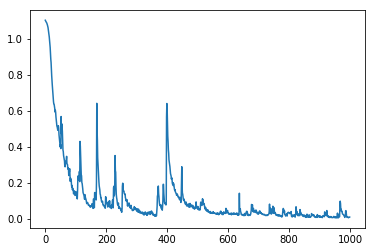

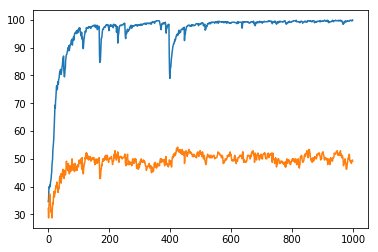

In [10]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [11]:
max(epoch_accuracies[1])

54.166666666666664

## Save model and scaler

In [12]:
torch.save(model.state_dict(), "models/passive_mass_model.pt")

In [13]:
joblib.dump(scaler, "scalers/passive_mass_scaler.sk")

['scalers/passive_mass_scaler.sk']

## Load model and evaluate

In [15]:
model = ComplexRNNModel(input_dim, hidden_dim, n_layers, output_dim)
model.load_state_dict(torch.load("models/passive_mass_model.pt"))
model.eval()
model = model.cuda()

In [16]:
accuracy, predicted = evaluate(model, val_loader, return_predicted=True)

In [17]:
print(accuracy)

49.166666666666664


In [18]:
predicted = [pred.cpu() for pred in predicted]
Y_val = np.concatenate([y.cpu().numpy() for x, y in val_loader])

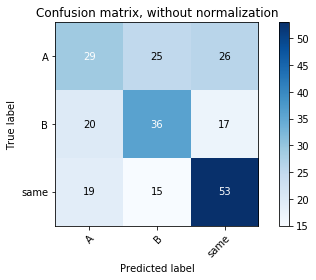

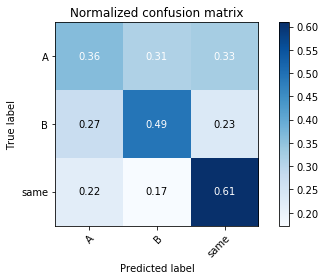

In [19]:
plot_confusion_matrix(Y_val, predicted, classes=MASS_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_val, predicted, classes=MASS_CLASS_COLS, normalize=True)

# FORCE TRAINING  (Humans achieve 61% +- 22%)

## Read dataset and preprocess it

In [20]:
all_trials = read_dataset("data/passive_trials.h5")
train_loader, val_loader, scaler = prepare_dataset(all_trials, FORCE_CLASS_COLS, 
                                                   normalise_data=True, batch_size=128, test_size=0.3,
                                                   equiprobable_training_classes=False)

100%|██████████| 800/800 [00:00<00:00, 1145.06it/s]


In [21]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [22]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.3517857142857143


## Define model, loss and optimizer

In [23]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(BASIC_TRAINING_COLS)    # input dimension
hidden_dim = 32  # hidden layer dimension
n_layers = 2     # number of hidden layers
output_dim = 3   # output dimension
dropout = 0.33

model = ComplexRNNModel(input_dim, hidden_dim, n_layers, output_dim, dropout=dropout)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model and plot loss and accuracy

In [ ]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=1000)

  0%|          | 1/1000 [00:01<24:26,  1.47s/it]

1.0998989820480347 35.17857142857143 35.416666666666664


  0%|          | 2/1000 [00:02<23:33,  1.42s/it]

1.0955935716629028 36.25 35.833333333333336


  0%|          | 3/1000 [00:04<23:26,  1.41s/it]

1.0927171945571899 37.32142857142857 35.416666666666664


  0%|          | 4/1000 [00:05<23:07,  1.39s/it]

1.0896222114562988 38.035714285714285 36.25


  0%|          | 5/1000 [00:06<22:57,  1.38s/it]

1.0865103960037232 38.57142857142857 36.25


  1%|          | 6/1000 [00:08<23:02,  1.39s/it]

1.0827393770217895 38.392857142857146 36.25


  1%|          | 7/1000 [00:09<22:31,  1.36s/it]

1.07657732963562 43.57142857142857 37.083333333333336


  1%|          | 8/1000 [00:10<22:45,  1.38s/it]

1.0716606378555298 48.035714285714285 36.666666666666664


  1%|          | 9/1000 [00:12<22:58,  1.39s/it]

1.0635180711746215 49.285714285714285 38.75


  1%|          | 10/1000 [00:13<23:11,  1.41s/it]

1.049184465408325 50.357142857142854 39.166666666666664


  1%|          | 11/1000 [00:15<23:15,  1.41s/it]

1.0320481419563294 50.892857142857146 40.833333333333336


  1%|          | 12/1000 [00:16<23:14,  1.41s/it]

1.0130429983139038 52.67857142857143 38.333333333333336


  1%|▏         | 13/1000 [00:17<22:31,  1.37s/it]

0.9825569868087769 54.285714285714285 38.333333333333336


  1%|▏         | 14/1000 [00:19<22:02,  1.34s/it]

0.9535301804542542 58.392857142857146 42.083333333333336


  2%|▏         | 15/1000 [00:20<22:05,  1.35s/it]

0.9225896835327149 59.464285714285715 43.75


  2%|▏         | 16/1000 [00:21<21:47,  1.33s/it]

0.8802993416786193 60.892857142857146 43.75


  2%|▏         | 17/1000 [00:23<21:30,  1.31s/it]

0.8448416948318481 63.92857142857143 47.5


  2%|▏         | 18/1000 [00:24<21:59,  1.34s/it]

0.8056545376777648 67.14285714285714 49.583333333333336


  2%|▏         | 19/1000 [00:25<22:08,  1.35s/it]

0.7753630757331849 68.92857142857143 50.0


  2%|▏         | 20/1000 [00:27<22:23,  1.37s/it]

0.7207524061203003 71.78571428571429 52.5


  2%|▏         | 21/1000 [00:28<22:19,  1.37s/it]

0.6853334307670593 73.21428571428571 55.0


  2%|▏         | 22/1000 [00:30<21:53,  1.34s/it]

0.6491568922996521 74.10714285714286 53.333333333333336


  2%|▏         | 23/1000 [00:31<22:11,  1.36s/it]

0.6193655014038086 76.60714285714286 52.083333333333336


  2%|▏         | 24/1000 [00:32<22:04,  1.36s/it]

0.5978864133358002 75.71428571428571 53.75


  2%|▎         | 25/1000 [00:34<21:42,  1.34s/it]

0.5850899815559387 78.03571428571429 54.583333333333336


  3%|▎         | 26/1000 [00:35<21:35,  1.33s/it]

0.5633784770965576 78.03571428571429 53.333333333333336


  3%|▎         | 27/1000 [00:36<21:27,  1.32s/it]

0.5570273578166962 78.92857142857143 53.75


  3%|▎         | 28/1000 [00:38<21:35,  1.33s/it]

0.5425898551940918 79.82142857142857 52.916666666666664


  3%|▎         | 29/1000 [00:39<21:43,  1.34s/it]

0.5083881139755249 80.89285714285714 52.5


  3%|▎         | 30/1000 [00:40<22:07,  1.37s/it]

0.4859292805194855 81.25 55.0


  3%|▎         | 31/1000 [00:42<22:30,  1.39s/it]

0.47412520051002505 81.96428571428571 55.416666666666664


  3%|▎         | 32/1000 [00:43<22:39,  1.40s/it]

0.45407203435897825 82.32142857142857 55.0


  3%|▎         | 33/1000 [00:45<23:18,  1.45s/it]

0.44322114884853364 83.21428571428571 58.75


  3%|▎         | 34/1000 [00:46<23:27,  1.46s/it]

0.4249301940202713 84.46428571428571 56.666666666666664


  4%|▎         | 35/1000 [00:48<23:37,  1.47s/it]

0.39899555444717405 85.35714285714286 55.416666666666664


  4%|▎         | 36/1000 [00:49<23:33,  1.47s/it]

0.3858254998922348 86.60714285714286 55.416666666666664


  4%|▎         | 37/1000 [00:51<23:19,  1.45s/it]

0.3562292903661728 87.32142857142857 55.833333333333336


  4%|▍         | 38/1000 [00:52<22:38,  1.41s/it]

0.34269578754901886 88.39285714285714 57.083333333333336


  4%|▍         | 39/1000 [00:53<21:55,  1.37s/it]

0.3524564951658249 89.64285714285714 56.25


  4%|▍         | 40/1000 [00:54<21:29,  1.34s/it]

0.34612609446048737 86.96428571428571 52.5


  4%|▍         | 41/1000 [00:56<21:09,  1.32s/it]

0.3610529154539108 88.39285714285714 53.75


  4%|▍         | 42/1000 [00:57<21:35,  1.35s/it]

0.3655589193105698 88.57142857142857 53.333333333333336


  4%|▍         | 43/1000 [00:59<21:33,  1.35s/it]

0.33872800320386887 85.17857142857143 51.666666666666664


  4%|▍         | 44/1000 [01:00<21:42,  1.36s/it]

0.3505196809768677 88.57142857142857 54.166666666666664


  4%|▍         | 45/1000 [01:01<21:50,  1.37s/it]

0.35280490964651107 89.82142857142857 53.333333333333336


  5%|▍         | 46/1000 [01:03<21:24,  1.35s/it]

0.32721239179372785 90.53571428571429 52.5


  5%|▍         | 47/1000 [01:04<21:25,  1.35s/it]

0.31597757935523985 89.82142857142857 50.0


  5%|▍         | 48/1000 [01:05<22:10,  1.40s/it]

0.3115780845284462 90.35714285714286 52.5


  5%|▍         | 49/1000 [01:07<22:42,  1.43s/it]

0.3064065143465996 90.89285714285714 54.583333333333336


  5%|▌         | 50/1000 [01:08<23:03,  1.46s/it]

0.2717541515827179 91.25 55.0


  5%|▌         | 51/1000 [01:10<23:00,  1.45s/it]

0.28001868724823 91.25 53.75


  5%|▌         | 52/1000 [01:11<23:11,  1.47s/it]

0.2807875439524651 91.25 53.333333333333336


  5%|▌         | 53/1000 [01:13<23:26,  1.49s/it]

0.27270097881555555 91.78571428571429 54.583333333333336


  5%|▌         | 54/1000 [01:14<23:14,  1.47s/it]

0.2587833657860756 91.96428571428571 54.166666666666664


  6%|▌         | 55/1000 [01:16<22:32,  1.43s/it]

0.2678730860352516 91.60714285714286 55.0


  6%|▌         | 56/1000 [01:17<21:55,  1.39s/it]

0.25549703687429426 92.14285714285714 55.833333333333336


  6%|▌         | 57/1000 [01:18<21:38,  1.38s/it]

0.2541609100997448 92.32142857142857 55.416666666666664


  6%|▌         | 58/1000 [01:20<21:18,  1.36s/it]

0.24554317966103553 92.67857142857143 55.833333333333336


  6%|▌         | 59/1000 [01:21<21:10,  1.35s/it]

0.23294080942869186 92.5 56.25


  6%|▌         | 60/1000 [01:22<21:11,  1.35s/it]

0.22842813059687614 92.85714285714286 56.666666666666664


  6%|▌         | 61/1000 [01:24<21:35,  1.38s/it]

0.22350388392806053 93.39285714285714 56.25


  6%|▌         | 62/1000 [01:25<22:18,  1.43s/it]

0.214410974830389 93.92857142857143 55.833333333333336


  6%|▋         | 63/1000 [01:27<22:28,  1.44s/it]

0.21955245211720467 93.21428571428571 54.583333333333336


  6%|▋         | 64/1000 [01:28<21:57,  1.41s/it]

0.20644021332263945 92.5 55.833333333333336


  6%|▋         | 65/1000 [01:30<21:49,  1.40s/it]

0.20856936499476433 93.39285714285714 55.416666666666664


  7%|▋         | 66/1000 [01:31<21:49,  1.40s/it]

0.20657237470149994 93.39285714285714 55.0


  7%|▋         | 67/1000 [01:32<22:15,  1.43s/it]

0.19797821938991547 93.57142857142857 55.833333333333336


  7%|▋         | 68/1000 [01:34<22:44,  1.46s/it]

0.2090018220245838 93.57142857142857 55.0


  7%|▋         | 69/1000 [01:36<22:59,  1.48s/it]

0.22260706573724748 93.03571428571429 55.0


  7%|▋         | 70/1000 [01:37<23:04,  1.49s/it]

0.23159613311290742 93.57142857142857 55.0


  7%|▋         | 71/1000 [01:39<23:04,  1.49s/it]

0.2190749987959862 93.57142857142857 55.416666666666664


  7%|▋         | 72/1000 [01:40<22:56,  1.48s/it]

0.2154001884162426 93.39285714285714 54.583333333333336


  7%|▋         | 73/1000 [01:41<22:55,  1.48s/it]

0.19964251220226287 93.21428571428571 55.416666666666664


  7%|▋         | 74/1000 [01:43<22:58,  1.49s/it]

0.20286438390612602 92.85714285714286 57.083333333333336


  8%|▊         | 75/1000 [01:44<22:00,  1.43s/it]

0.20868548303842543 94.46428571428571 55.416666666666664


  8%|▊         | 76/1000 [01:46<21:54,  1.42s/it]

0.17375232167541982 94.28571428571429 54.583333333333336


  8%|▊         | 77/1000 [01:47<21:21,  1.39s/it]

0.18669866621494294 94.28571428571429 54.583333333333336


  8%|▊         | 78/1000 [01:48<20:50,  1.36s/it]

0.18429456949234008 94.64285714285714 55.0


  8%|▊         | 79/1000 [01:50<20:26,  1.33s/it]

0.1773588288575411 94.64285714285714 55.416666666666664


  8%|▊         | 80/1000 [01:51<20:32,  1.34s/it]

0.1666760679334402 95.0 56.25


  8%|▊         | 81/1000 [01:52<21:15,  1.39s/it]

0.1735363233834505 94.46428571428571 55.416666666666664


  8%|▊         | 82/1000 [01:54<21:40,  1.42s/it]

0.16781484857201576 94.82142857142857 55.833333333333336


  8%|▊         | 83/1000 [01:55<22:01,  1.44s/it]

0.15928010530769826 95.17857142857143 55.416666666666664


  8%|▊         | 84/1000 [01:57<22:08,  1.45s/it]

0.14599897153675556 94.64285714285714 54.583333333333336


  8%|▊         | 85/1000 [01:58<22:13,  1.46s/it]

0.18133281022310258 92.67857142857143 54.166666666666664


  9%|▊         | 86/1000 [02:00<22:04,  1.45s/it]

0.23241332769393921 87.5 53.75


  9%|▊         | 87/1000 [02:01<21:19,  1.40s/it]

0.41472926139831545 83.57142857142857 55.0


  9%|▉         | 88/1000 [02:02<21:30,  1.41s/it]

0.47372591495513916 82.5 55.833333333333336


  9%|▉         | 89/1000 [02:04<21:06,  1.39s/it]

0.42292308807373047 83.92857142857143 55.833333333333336


  9%|▉         | 90/1000 [02:05<21:34,  1.42s/it]

0.3897197782993317 84.82142857142857 55.416666666666664


  9%|▉         | 91/1000 [02:07<21:34,  1.42s/it]

0.3796070396900177 86.07142857142857 53.333333333333336


  9%|▉         | 92/1000 [02:08<21:34,  1.43s/it]

0.3565066993236542 87.32142857142857 52.916666666666664


  9%|▉         | 93/1000 [02:09<20:56,  1.39s/it]

0.3639883935451508 87.14285714285714 53.75


  9%|▉         | 94/1000 [02:11<20:30,  1.36s/it]

0.3313019335269928 88.03571428571429 53.75


 10%|▉         | 95/1000 [02:12<20:06,  1.33s/it]

0.3087285339832306 88.57142857142857 54.166666666666664


 10%|▉         | 96/1000 [02:13<19:49,  1.32s/it]

0.2930612415075302 89.10714285714286 54.166666666666664


 10%|▉         | 97/1000 [02:15<19:36,  1.30s/it]

0.27636824548244476 89.64285714285714 54.583333333333336


 10%|▉         | 98/1000 [02:16<19:29,  1.30s/it]

0.26799376904964445 89.64285714285714 55.0


 10%|▉         | 99/1000 [02:17<19:33,  1.30s/it]

0.2672600865364075 90.17857142857143 54.583333333333336


 10%|█         | 100/1000 [02:19<20:09,  1.34s/it]

0.2505669593811035 90.53571428571429 55.833333333333336


 10%|█         | 101/1000 [02:20<20:47,  1.39s/it]

0.24407183825969697 90.71428571428571 54.583333333333336


 10%|█         | 102/1000 [02:22<21:21,  1.43s/it]

0.23631205260753632 90.89285714285714 54.583333333333336


 10%|█         | 103/1000 [02:23<21:17,  1.42s/it]

0.2396773263812065 91.07142857142857 54.583333333333336


 10%|█         | 104/1000 [02:24<21:10,  1.42s/it]

0.22109594196081161 91.25 55.0


 10%|█         | 105/1000 [02:26<20:58,  1.41s/it]

0.21438360065221787 91.78571428571429 54.583333333333336


 11%|█         | 106/1000 [02:27<21:15,  1.43s/it]

0.2086426541209221 91.96428571428571 55.0


 11%|█         | 107/1000 [02:29<21:36,  1.45s/it]

0.21182455271482467 92.14285714285714 55.0


 11%|█         | 108/1000 [02:30<21:52,  1.47s/it]

0.1941025137901306 92.5 55.833333333333336


 11%|█         | 109/1000 [02:32<22:07,  1.49s/it]

0.1925223782658577 92.5 55.416666666666664


 11%|█         | 110/1000 [02:33<22:13,  1.50s/it]

0.19181183576583863 92.85714285714286 55.833333333333336


 11%|█         | 111/1000 [02:35<22:16,  1.50s/it]

0.18699698597192765 92.85714285714286 55.416666666666664


 11%|█         | 112/1000 [02:36<22:23,  1.51s/it]

0.1885169818997383 93.21428571428571 55.833333333333336


 11%|█▏        | 113/1000 [02:38<22:27,  1.52s/it]

0.17026659846305847 93.57142857142857 54.583333333333336


 11%|█▏        | 114/1000 [02:39<22:14,  1.51s/it]

0.1716966763138771 94.10714285714286 55.0


 12%|█▏        | 115/1000 [02:41<22:06,  1.50s/it]

0.17209081202745438 94.64285714285714 56.666666666666664


 12%|█▏        | 116/1000 [02:42<22:07,  1.50s/it]

0.17137387320399283 94.64285714285714 55.833333333333336


 12%|█▏        | 117/1000 [02:44<22:14,  1.51s/it]

0.1709092453122139 95.0 55.416666666666664


 12%|█▏        | 118/1000 [02:45<22:15,  1.51s/it]

0.15491269528865814 94.82142857142857 55.416666666666664


 12%|█▏        | 119/1000 [02:47<22:00,  1.50s/it]

0.15992910042405128 95.17857142857143 55.833333333333336


 12%|█▏        | 120/1000 [02:48<21:50,  1.49s/it]

0.14505148231983184 95.0 55.833333333333336


 12%|█▏        | 121/1000 [02:50<21:15,  1.45s/it]

0.14763040840625763 95.35714285714286 56.25


 12%|█▏        | 122/1000 [02:51<21:04,  1.44s/it]

0.15033453702926636 95.17857142857143 57.083333333333336


 12%|█▏        | 123/1000 [02:53<20:41,  1.42s/it]

0.13973745927214623 95.53571428571429 56.666666666666664


 12%|█▏        | 124/1000 [02:54<20:06,  1.38s/it]

0.15477389544248582 95.53571428571429 56.666666666666664


 12%|█▎        | 125/1000 [02:55<19:51,  1.36s/it]

0.1634782150387764 92.85714285714286 54.166666666666664


 13%|█▎        | 126/1000 [02:56<19:41,  1.35s/it]

0.21948304474353791 92.85714285714286 53.75


 13%|█▎        | 127/1000 [02:58<20:09,  1.39s/it]

0.20881766751408576 93.21428571428571 53.75


 13%|█▎        | 128/1000 [02:59<19:34,  1.35s/it]

0.18023163080215454 94.10714285714286 55.416666666666664


 13%|█▎        | 129/1000 [03:01<20:08,  1.39s/it]

0.17285817712545395 95.35714285714286 55.0


 13%|█▎        | 130/1000 [03:02<20:38,  1.42s/it]

0.1311376802623272 96.25 56.666666666666664


 13%|█▎        | 131/1000 [03:04<21:01,  1.45s/it]

0.12576716095209123 96.07142857142857 56.25


 13%|█▎        | 132/1000 [03:05<20:46,  1.44s/it]

0.12322308719158173 96.60714285714286 55.416666666666664


 13%|█▎        | 133/1000 [03:07<20:49,  1.44s/it]

0.12039118334650993 96.60714285714286 56.25


 13%|█▎        | 134/1000 [03:08<20:42,  1.43s/it]

0.12064693346619607 96.25 55.833333333333336


 14%|█▎        | 135/1000 [03:09<20:36,  1.43s/it]

0.10618242397904396 96.60714285714286 56.666666666666664


 14%|█▎        | 136/1000 [03:11<20:49,  1.45s/it]

0.10736646093428134 96.78571428571429 56.25


 14%|█▎        | 137/1000 [03:12<20:56,  1.46s/it]

0.10125820450484753 96.78571428571429 55.833333333333336


 14%|█▍        | 138/1000 [03:14<21:15,  1.48s/it]

0.10028753094375134 96.78571428571429 56.25


 14%|█▍        | 139/1000 [03:15<21:14,  1.48s/it]

0.09917427748441696 97.14285714285714 56.25


 14%|█▍        | 140/1000 [03:17<20:58,  1.46s/it]

0.0932606566697359 97.14285714285714 56.25


 14%|█▍        | 141/1000 [03:18<20:42,  1.45s/it]

0.0944708053022623 97.14285714285714 55.416666666666664


 14%|█▍        | 142/1000 [03:20<20:07,  1.41s/it]

0.08454709202051162 97.5 55.416666666666664


 14%|█▍        | 143/1000 [03:21<19:45,  1.38s/it]

0.0988417275249958 97.32142857142857 54.583333333333336


 14%|█▍        | 144/1000 [03:22<19:13,  1.35s/it]

0.08535200096666813 97.5 54.583333333333336


 14%|█▍        | 145/1000 [03:23<18:58,  1.33s/it]

0.08452371992170811 97.5 54.583333333333336


 15%|█▍        | 146/1000 [03:25<19:04,  1.34s/it]

0.08215994760394096 97.5 54.583333333333336


 15%|█▍        | 147/1000 [03:26<19:03,  1.34s/it]

0.07935992367565632 97.67857142857143 54.166666666666664


 15%|█▍        | 148/1000 [03:27<19:00,  1.34s/it]

0.08905843123793603 97.67857142857143 54.583333333333336


 15%|█▍        | 149/1000 [03:29<19:34,  1.38s/it]

0.07475297935307026 97.67857142857143 55.0


 15%|█▌        | 150/1000 [03:30<19:47,  1.40s/it]

0.08081429544836283 97.32142857142857 55.0


 15%|█▌        | 151/1000 [03:32<20:07,  1.42s/it]

0.07170192897319794 97.32142857142857 55.0


 15%|█▌        | 152/1000 [03:33<20:27,  1.45s/it]

0.07799615655094386 97.85714285714286 55.0


 15%|█▌        | 153/1000 [03:35<20:35,  1.46s/it]

0.07712721414864063 97.67857142857143 56.25


 15%|█▌        | 154/1000 [03:36<20:52,  1.48s/it]

0.06297478675842286 97.85714285714286 54.166666666666664


 16%|█▌        | 155/1000 [03:38<21:04,  1.50s/it]

0.07490601260215043 97.67857142857143 54.166666666666664


 16%|█▌        | 156/1000 [03:39<21:11,  1.51s/it]

0.08218931406736374 97.85714285714286 55.833333333333336


 16%|█▌        | 157/1000 [03:41<21:05,  1.50s/it]

0.06479443367570639 98.39285714285714 55.0


 16%|█▌        | 158/1000 [03:42<21:11,  1.51s/it]

0.06259830202907324 98.39285714285714 55.0


 16%|█▌        | 159/1000 [03:44<21:07,  1.51s/it]

0.07820492386817932 98.39285714285714 55.833333333333336


 16%|█▌        | 160/1000 [03:45<20:16,  1.45s/it]

0.06822634339332581 98.57142857142857 56.666666666666664


 16%|█▌        | 161/1000 [03:47<20:10,  1.44s/it]

0.053533378429710864 98.57142857142857 56.25


 16%|█▌        | 162/1000 [03:48<19:54,  1.43s/it]

0.060508704371750356 98.75 56.666666666666664


 16%|█▋        | 163/1000 [03:49<19:15,  1.38s/it]

0.05519184824079275 98.92857142857143 56.666666666666664


 16%|█▋        | 164/1000 [03:51<19:22,  1.39s/it]

0.053393027558922765 98.57142857142857 54.583333333333336


 16%|█▋        | 165/1000 [03:52<19:35,  1.41s/it]

0.05643520541489124 98.75 54.166666666666664


 17%|█▋        | 166/1000 [03:54<19:20,  1.39s/it]

0.055156335793435575 98.75 55.416666666666664


 17%|█▋        | 167/1000 [03:55<19:07,  1.38s/it]

0.05411867201328278 98.75 55.0


 17%|█▋        | 168/1000 [03:56<19:01,  1.37s/it]

0.06762962341308594 96.25 55.833333333333336


 17%|█▋        | 169/1000 [03:58<19:15,  1.39s/it]

0.1841871589422226 96.42857142857143 54.583333333333336


 17%|█▋        | 170/1000 [03:59<19:28,  1.41s/it]

0.14806503504514695 96.78571428571429 56.25


 17%|█▋        | 171/1000 [04:00<19:00,  1.38s/it]

0.11921314224600792 97.85714285714286 58.333333333333336


 17%|█▋        | 172/1000 [04:02<18:32,  1.34s/it]

0.09388891011476516 97.14285714285714 58.75


 17%|█▋        | 173/1000 [04:03<18:11,  1.32s/it]

0.1289975829422474 96.07142857142857 56.666666666666664


 17%|█▋        | 174/1000 [04:04<17:55,  1.30s/it]

0.1404545594006777 97.14285714285714 59.166666666666664


 18%|█▊        | 175/1000 [04:06<18:27,  1.34s/it]

0.14784187376499175 96.42857142857143 57.916666666666664


 18%|█▊        | 176/1000 [04:07<19:00,  1.38s/it]

0.15623650699853897 94.82142857142857 59.166666666666664


 18%|█▊        | 177/1000 [04:09<19:14,  1.40s/it]

0.2290492057800293 95.35714285714286 57.916666666666664


 18%|█▊        | 178/1000 [04:10<19:37,  1.43s/it]

0.1703572928905487 96.07142857142857 56.666666666666664


 18%|█▊        | 179/1000 [04:12<20:02,  1.46s/it]

0.1452760264277458 95.89285714285714 55.416666666666664


 18%|█▊        | 180/1000 [04:13<19:53,  1.46s/it]

0.12474076747894287 96.42857142857143 54.583333333333336


 18%|█▊        | 181/1000 [04:15<20:06,  1.47s/it]

0.12880477756261827 96.78571428571429 55.0


 18%|█▊        | 182/1000 [04:16<20:18,  1.49s/it]

0.11495722979307174 97.32142857142857 55.416666666666664


 18%|█▊        | 183/1000 [04:18<20:25,  1.50s/it]

0.10895571559667587 97.32142857142857 56.25


 18%|█▊        | 184/1000 [04:19<20:11,  1.48s/it]

0.09239455237984658 97.85714285714286 57.083333333333336


 18%|█▊        | 185/1000 [04:21<19:50,  1.46s/it]

0.08990678191184998 98.39285714285714 57.083333333333336


 19%|█▊        | 186/1000 [04:22<19:16,  1.42s/it]

0.07590259760618209 98.21428571428571 57.083333333333336


 19%|█▊        | 187/1000 [04:23<18:47,  1.39s/it]

0.0770859256386757 98.21428571428571 57.083333333333336


 19%|█▉        | 188/1000 [04:25<19:00,  1.40s/it]

0.07559359073638916 98.39285714285714 56.25


 19%|█▉        | 189/1000 [04:26<18:45,  1.39s/it]

0.06718849241733552 98.57142857142857 56.25


 19%|█▉        | 190/1000 [04:27<18:34,  1.38s/it]

0.07938214391469955 98.75 57.083333333333336


 19%|█▉        | 191/1000 [04:29<18:33,  1.38s/it]

0.07343474328517914 98.75 57.083333333333336


 19%|█▉        | 192/1000 [04:30<18:14,  1.35s/it]

0.06281442940235138 98.92857142857143 57.083333333333336


 19%|█▉        | 193/1000 [04:31<18:29,  1.37s/it]

0.0596575602889061 99.10714285714286 57.083333333333336


 19%|█▉        | 194/1000 [04:33<18:26,  1.37s/it]

0.04928238056600094 99.28571428571429 57.083333333333336


 20%|█▉        | 195/1000 [04:34<18:26,  1.37s/it]

0.05388716012239456 99.10714285714286 56.25


 20%|█▉        | 196/1000 [04:36<18:36,  1.39s/it]

0.05529085919260979 99.28571428571429 56.666666666666664


 20%|█▉        | 197/1000 [04:37<18:59,  1.42s/it]

0.04971177466213703 99.28571428571429 55.416666666666664


 20%|█▉        | 198/1000 [04:39<19:22,  1.45s/it]

0.04189292751252651 99.28571428571429 55.0


 20%|█▉        | 199/1000 [04:40<19:38,  1.47s/it]

0.04168879501521587 99.28571428571429 54.583333333333336


 20%|██        | 200/1000 [04:42<19:55,  1.49s/it]

0.035758009552955626 99.28571428571429 55.0


 20%|██        | 201/1000 [04:43<19:58,  1.50s/it]

0.039072034507989885 99.28571428571429 55.0


 20%|██        | 202/1000 [04:45<19:47,  1.49s/it]

0.035150842554867265 99.28571428571429 54.583333333333336


 20%|██        | 203/1000 [04:46<19:52,  1.50s/it]

0.03775545917451382 99.10714285714286 53.75


 20%|██        | 204/1000 [04:48<19:35,  1.48s/it]

0.03269252385944128 99.10714285714286 55.416666666666664


 20%|██        | 205/1000 [04:49<19:32,  1.48s/it]

0.0380369458347559 99.28571428571429 55.416666666666664


 21%|██        | 206/1000 [04:51<19:41,  1.49s/it]

0.034727603942155835 99.28571428571429 55.416666666666664


 21%|██        | 207/1000 [04:52<19:30,  1.48s/it]

0.035178218595683576 99.10714285714286 56.25


 21%|██        | 208/1000 [04:53<19:32,  1.48s/it]

0.027642319351434706 99.28571428571429 56.666666666666664


 21%|██        | 209/1000 [04:55<19:23,  1.47s/it]

0.03074230868369341 99.28571428571429 57.083333333333336


 21%|██        | 210/1000 [04:56<19:13,  1.46s/it]

0.03574531050398946 99.28571428571429 57.083333333333336


 21%|██        | 211/1000 [04:58<18:56,  1.44s/it]

0.027363763749599458 99.28571428571429 55.833333333333336


 21%|██        | 212/1000 [04:59<18:31,  1.41s/it]

0.029405473545193673 99.10714285714286 56.25


 21%|██▏       | 213/1000 [05:01<18:25,  1.41s/it]

0.04181912960484624 99.10714285714286 55.833333333333336


 21%|██▏       | 214/1000 [05:02<18:09,  1.39s/it]

0.027948643639683725 99.28571428571429 55.833333333333336


 22%|██▏       | 215/1000 [05:03<17:59,  1.37s/it]

0.0261906947940588 99.46428571428571 55.416666666666664


 22%|██▏       | 216/1000 [05:05<18:14,  1.40s/it]

0.026353407837450504 99.28571428571429 55.833333333333336


 22%|██▏       | 217/1000 [05:06<18:33,  1.42s/it]

0.024208167754113673 99.28571428571429 55.833333333333336


 22%|██▏       | 218/1000 [05:07<18:04,  1.39s/it]

0.031244940496981143 99.10714285714286 55.416666666666664


 22%|██▏       | 219/1000 [05:09<18:30,  1.42s/it]

0.03276258111000061 99.10714285714286 54.583333333333336


 22%|██▏       | 220/1000 [05:10<18:46,  1.44s/it]

0.025862797163426876 99.10714285714286 55.416666666666664


 22%|██▏       | 221/1000 [05:12<19:04,  1.47s/it]

0.033651679381728174 98.92857142857143 54.166666666666664


 22%|██▏       | 222/1000 [05:13<18:39,  1.44s/it]

0.025682271737605334 99.28571428571429 55.0


 22%|██▏       | 223/1000 [05:15<19:02,  1.47s/it]

0.03299503847956657 99.10714285714286 55.0


 22%|██▏       | 224/1000 [05:16<19:03,  1.47s/it]

0.022375905234366656 99.28571428571429 54.583333333333336


 22%|██▎       | 225/1000 [05:18<18:32,  1.44s/it]

0.021465453878045083 99.28571428571429 55.416666666666664


 23%|██▎       | 226/1000 [05:19<17:55,  1.39s/it]

0.022787334956228734 99.28571428571429 55.416666666666664


 23%|██▎       | 227/1000 [05:20<17:38,  1.37s/it]

0.019614180130884052 99.46428571428571 55.416666666666664


 23%|██▎       | 228/1000 [05:22<18:20,  1.42s/it]

0.029553396999835967 99.46428571428571 54.583333333333336


 23%|██▎       | 229/1000 [05:23<18:22,  1.43s/it]

0.027680827118456364 99.64285714285714 55.416666666666664


 23%|██▎       | 230/1000 [05:25<18:43,  1.46s/it]

0.027020764537155628 99.46428571428571 55.0


 23%|██▎       | 231/1000 [05:26<18:44,  1.46s/it]

0.03507239948958159 98.57142857142857 55.0


 23%|██▎       | 232/1000 [05:28<18:45,  1.47s/it]

0.04436319228261709 99.28571428571429 55.416666666666664


 23%|██▎       | 233/1000 [05:29<18:50,  1.47s/it]

0.029859410598874092 99.10714285714286 54.583333333333336


 23%|██▎       | 234/1000 [05:31<18:33,  1.45s/it]

0.03762324107810855 99.28571428571429 55.0


 24%|██▎       | 235/1000 [05:32<18:32,  1.45s/it]

0.02394724078476429 99.46428571428571 55.833333333333336


 24%|██▎       | 236/1000 [05:34<18:27,  1.45s/it]

0.01691964464262128 99.64285714285714 55.833333333333336


 24%|██▎       | 237/1000 [05:35<18:47,  1.48s/it]

0.02286053476855159 99.64285714285714 56.25


 24%|██▍       | 238/1000 [05:37<18:44,  1.48s/it]

0.02160429023206234 99.82142857142857 57.083333333333336


 24%|██▍       | 239/1000 [05:38<18:34,  1.46s/it]

0.013541625067591666 99.82142857142857 57.916666666666664


 24%|██▍       | 240/1000 [05:39<18:15,  1.44s/it]

0.026898900605738164 99.64285714285714 57.083333333333336


 24%|██▍       | 241/1000 [05:41<17:42,  1.40s/it]

0.012622697837650776 99.64285714285714 57.5


 24%|██▍       | 242/1000 [05:42<17:30,  1.39s/it]

0.017758996039628983 99.46428571428571 57.5


 24%|██▍       | 243/1000 [05:43<17:33,  1.39s/it]

0.02026713974773884 99.46428571428571 57.5


 24%|██▍       | 244/1000 [05:45<18:00,  1.43s/it]

0.014892851607874036 99.46428571428571 57.916666666666664


 24%|██▍       | 245/1000 [05:46<18:02,  1.43s/it]

0.013851289823651313 99.64285714285714 57.083333333333336


 25%|██▍       | 246/1000 [05:48<18:14,  1.45s/it]

0.015645305253565313 99.64285714285714 57.5


 25%|██▍       | 247/1000 [05:49<18:04,  1.44s/it]

0.012219678913243114 99.10714285714286 57.083333333333336


 25%|██▍       | 248/1000 [05:51<17:37,  1.41s/it]

0.04209116362035274 98.75 55.833333333333336


 25%|██▍       | 249/1000 [05:52<18:20,  1.46s/it]

0.08630618304014206 97.14285714285714 56.666666666666664


 25%|██▌       | 250/1000 [05:54<17:54,  1.43s/it]

0.12972513996064663 95.35714285714286 55.416666666666664


 25%|██▌       | 251/1000 [05:55<18:01,  1.44s/it]

0.08582935743033886 98.39285714285714 55.416666666666664


 25%|██▌       | 252/1000 [05:57<18:01,  1.45s/it]

0.05446413531899452 98.57142857142857 57.083333333333336


 25%|██▌       | 253/1000 [05:58<17:53,  1.44s/it]

0.043755948171019556 98.92857142857143 56.25


 25%|██▌       | 254/1000 [05:59<17:53,  1.44s/it]

0.030540778860449792 98.57142857142857 55.833333333333336


 26%|██▌       | 255/1000 [06:01<17:44,  1.43s/it]

0.03824306763708592 98.57142857142857 57.5


 26%|██▌       | 256/1000 [06:02<17:17,  1.40s/it]

0.03490469865500927 98.92857142857143 56.25


 26%|██▌       | 257/1000 [06:03<16:49,  1.36s/it]

0.039742961153388025 99.10714285714286 55.416666666666664


 26%|██▌       | 258/1000 [06:05<16:57,  1.37s/it]

0.0330700246617198 99.10714285714286 54.166666666666664


 26%|██▌       | 259/1000 [06:06<17:06,  1.38s/it]

0.03130990848876536 99.46428571428571 54.166666666666664


 26%|██▌       | 260/1000 [06:07<16:32,  1.34s/it]

0.022213044669479133 99.46428571428571 53.75


 26%|██▌       | 261/1000 [06:09<16:28,  1.34s/it]

0.03487330451607704 99.64285714285714 53.75


 26%|██▌       | 262/1000 [06:10<16:59,  1.38s/it]

0.02769049718044698 100.0 55.416666666666664


 26%|██▋       | 263/1000 [06:12<17:04,  1.39s/it]

0.02378635462373495 99.64285714285714 54.583333333333336


 26%|██▋       | 264/1000 [06:13<17:17,  1.41s/it]

0.024237304273992778 99.64285714285714 55.833333333333336


 26%|██▋       | 265/1000 [06:14<16:47,  1.37s/it]

0.01578552075661719 99.82142857142857 55.0


 27%|██▋       | 266/1000 [06:16<16:34,  1.36s/it]

0.0196115150116384 99.64285714285714 55.833333333333336


 27%|██▋       | 267/1000 [06:17<16:31,  1.35s/it]

0.013725364208221435 99.82142857142857 55.833333333333336


 27%|██▋       | 268/1000 [06:18<16:18,  1.34s/it]

0.01222667908295989 99.82142857142857 55.416666666666664


 27%|██▋       | 269/1000 [06:20<16:22,  1.34s/it]

0.013995372457429767 99.82142857142857 53.75


 27%|██▋       | 270/1000 [06:21<16:34,  1.36s/it]

0.011464377492666244 99.64285714285714 54.166666666666664


 27%|██▋       | 271/1000 [06:22<16:21,  1.35s/it]

0.019118218310177328 99.64285714285714 53.333333333333336


 27%|██▋       | 272/1000 [06:24<16:08,  1.33s/it]

0.017100182361900806 99.82142857142857 54.166666666666664


 27%|██▋       | 273/1000 [06:25<15:54,  1.31s/it]

0.013883898267522454 99.82142857142857 54.166666666666664


 27%|██▋       | 274/1000 [06:26<15:50,  1.31s/it]

0.013220351445488632 99.64285714285714 54.583333333333336


 28%|██▊       | 275/1000 [06:28<16:14,  1.34s/it]

0.010380842257291079 99.64285714285714 55.833333333333336


 28%|██▊       | 276/1000 [06:29<16:16,  1.35s/it]

0.010777318477630615 99.28571428571429 55.416666666666664


 28%|██▊       | 277/1000 [06:30<16:06,  1.34s/it]

0.00917383232153952 99.28571428571429 55.833333333333336


 28%|██▊       | 278/1000 [06:32<16:27,  1.37s/it]

0.011260799039155245 99.64285714285714 54.583333333333336


 28%|██▊       | 279/1000 [06:33<16:38,  1.38s/it]

0.018615306355059147 99.46428571428571 54.583333333333336


 28%|██▊       | 280/1000 [06:35<16:12,  1.35s/it]

0.015707115083932875 98.39285714285714 54.166666666666664


 28%|██▊       | 281/1000 [06:36<16:12,  1.35s/it]

0.06238860115408897 98.03571428571429 53.333333333333336


 28%|██▊       | 282/1000 [06:37<16:15,  1.36s/it]

0.10378468595445156 98.03571428571429 54.583333333333336


 28%|██▊       | 283/1000 [06:39<16:35,  1.39s/it]

0.08705747723579407 97.14285714285714 54.583333333333336


 28%|██▊       | 284/1000 [06:40<17:06,  1.43s/it]

0.11068486468866467 96.96428571428571 52.916666666666664


 28%|██▊       | 285/1000 [06:42<17:29,  1.47s/it]

0.11156568005681038 98.21428571428571 54.166666666666664


 29%|██▊       | 286/1000 [06:43<17:38,  1.48s/it]

0.09323848895728588 97.85714285714286 54.166666666666664


 29%|██▊       | 287/1000 [06:45<17:46,  1.50s/it]

0.09175153477117419 98.03571428571429 55.833333333333336


 29%|██▉       | 288/1000 [06:46<17:57,  1.51s/it]

0.09380026357248425 98.03571428571429 57.083333333333336


 29%|██▉       | 289/1000 [06:48<18:11,  1.53s/it]

0.0835220068693161 96.07142857142857 53.333333333333336


 29%|██▉       | 290/1000 [06:50<18:17,  1.55s/it]

0.19686439856886864 95.17857142857143 53.75


 29%|██▉       | 291/1000 [06:51<18:19,  1.55s/it]

0.1879419282078743 95.35714285714286 54.166666666666664


 29%|██▉       | 292/1000 [06:53<18:15,  1.55s/it]

0.1618722051382065 95.35714285714286 55.0


 29%|██▉       | 293/1000 [06:54<17:51,  1.52s/it]

0.20265572369098664 93.39285714285714 54.583333333333336


 29%|██▉       | 294/1000 [06:56<17:56,  1.53s/it]

0.24337499886751174 94.64285714285714 56.666666666666664


 30%|██▉       | 295/1000 [06:57<17:55,  1.52s/it]

0.19297846257686616 95.35714285714286 54.583333333333336


 30%|██▉       | 296/1000 [06:59<17:50,  1.52s/it]

0.14674140177667142 96.42857142857143 54.583333333333336


 30%|██▉       | 297/1000 [07:00<17:50,  1.52s/it]

0.1304631918668747 96.60714285714286 55.416666666666664


 30%|██▉       | 298/1000 [07:02<17:52,  1.53s/it]

0.12203761786222458 97.5 55.833333333333336


 30%|██▉       | 299/1000 [07:03<17:39,  1.51s/it]

0.0943293035030365 97.67857142857143 55.833333333333336


 30%|███       | 300/1000 [07:05<17:38,  1.51s/it]

0.07971852459013462 98.03571428571429 55.0


 30%|███       | 301/1000 [07:06<17:34,  1.51s/it]

0.0752125509083271 98.57142857142857 55.0


 30%|███       | 302/1000 [07:08<17:37,  1.51s/it]

0.06425801068544387 98.75 55.0


 30%|███       | 303/1000 [07:09<17:33,  1.51s/it]

0.05189943462610245 98.57142857142857 54.583333333333336


 30%|███       | 304/1000 [07:11<17:38,  1.52s/it]

0.046826869063079354 98.75 55.416666666666664


 30%|███       | 305/1000 [07:12<17:40,  1.53s/it]

0.06089416965842247 99.46428571428571 55.416666666666664


 31%|███       | 306/1000 [07:14<17:44,  1.53s/it]

0.04103629719465971 99.64285714285714 56.25


 31%|███       | 307/1000 [07:15<17:46,  1.54s/it]

0.037792357802391055 99.64285714285714 56.666666666666664


 31%|███       | 308/1000 [07:17<17:45,  1.54s/it]

0.033000435959547755 99.82142857142857 56.666666666666664


 31%|███       | 309/1000 [07:19<17:44,  1.54s/it]

0.055599546805024144 99.46428571428571 55.416666666666664


 31%|███       | 310/1000 [07:20<17:46,  1.54s/it]

0.08834813944995404 95.35714285714286 55.833333333333336


 31%|███       | 311/1000 [07:22<17:47,  1.55s/it]

0.25287347435951235 94.64285714285714 54.166666666666664


 31%|███       | 312/1000 [07:23<17:48,  1.55s/it]

0.24131942987442018 95.71428571428571 55.416666666666664


 31%|███▏      | 313/1000 [07:25<17:49,  1.56s/it]

0.2059267058968544 94.64285714285714 55.0


 31%|███▏      | 314/1000 [07:26<17:58,  1.57s/it]

0.18809595778584481 95.35714285714286 55.833333333333336


 32%|███▏      | 315/1000 [07:28<17:56,  1.57s/it]

0.19001454263925552 96.07142857142857 56.25


 32%|███▏      | 316/1000 [07:30<17:51,  1.57s/it]

0.1698932398110628 96.60714285714286 56.666666666666664


 32%|███▏      | 317/1000 [07:31<17:46,  1.56s/it]

0.12304588332772255 97.14285714285714 56.666666666666664


 32%|███▏      | 318/1000 [07:33<17:44,  1.56s/it]

0.08670241311192513 97.85714285714286 57.083333333333336


 32%|███▏      | 319/1000 [07:34<17:42,  1.56s/it]

0.09994430728256702 98.57142857142857 57.5


 32%|███▏      | 320/1000 [07:36<17:39,  1.56s/it]

0.0770263910293579 98.75 57.5


 32%|███▏      | 321/1000 [07:37<17:38,  1.56s/it]

0.06049071867018938 98.75 57.916666666666664


 32%|███▏      | 322/1000 [07:39<17:38,  1.56s/it]

0.06785809583961963 98.92857142857143 58.333333333333336


 32%|███▏      | 323/1000 [07:40<17:38,  1.56s/it]

0.05503055136650801 98.75 59.583333333333336


 32%|███▏      | 324/1000 [07:42<17:38,  1.57s/it]

0.04847971722483635 98.92857142857143 59.166666666666664


 32%|███▎      | 325/1000 [07:44<17:36,  1.57s/it]

0.0469418223015964 99.10714285714286 59.583333333333336


 33%|███▎      | 326/1000 [07:45<17:35,  1.57s/it]

0.04705114904791117 99.10714285714286 59.583333333333336


 33%|███▎      | 327/1000 [07:47<17:35,  1.57s/it]

0.05201628310605884 98.75 57.916666666666664


 33%|███▎      | 328/1000 [07:48<17:30,  1.56s/it]

0.058082705922424795 98.75 57.5


 33%|███▎      | 329/1000 [07:50<17:28,  1.56s/it]

0.04986487217247486 99.28571428571429 58.75


 33%|███▎      | 330/1000 [07:51<17:32,  1.57s/it]

0.03293674439191818 99.28571428571429 58.75


 33%|███▎      | 331/1000 [07:53<17:23,  1.56s/it]

0.04981029909104109 99.28571428571429 60.0


 33%|███▎      | 332/1000 [07:55<17:26,  1.57s/it]

0.04306479319930077 99.28571428571429 61.25


 33%|███▎      | 333/1000 [07:56<17:22,  1.56s/it]

0.029102582205086946 99.46428571428571 60.833333333333336


 33%|███▎      | 334/1000 [07:58<17:17,  1.56s/it]

0.030097404960542917 99.46428571428571 60.416666666666664


 34%|███▎      | 335/1000 [07:59<17:15,  1.56s/it]

0.031296441331505775 99.46428571428571 60.416666666666664


 34%|███▎      | 336/1000 [08:01<17:15,  1.56s/it]

0.02251913845539093 99.46428571428571 60.833333333333336


 34%|███▎      | 337/1000 [08:02<17:16,  1.56s/it]

0.02633018996566534 99.64285714285714 60.833333333333336


 34%|███▍      | 338/1000 [08:04<17:13,  1.56s/it]

0.03740765461698174 99.82142857142857 60.833333333333336


 34%|███▍      | 339/1000 [08:05<17:06,  1.55s/it]

0.01927019553259015 100.0 61.25


 34%|███▍      | 340/1000 [08:07<17:03,  1.55s/it]

0.022352924197912218 99.82142857142857 61.25


 34%|███▍      | 341/1000 [08:09<17:07,  1.56s/it]

0.0216073309071362 99.82142857142857 61.25


 34%|███▍      | 342/1000 [08:10<17:06,  1.56s/it]

0.01762281870469451 100.0 60.833333333333336


 34%|███▍      | 343/1000 [08:12<17:01,  1.55s/it]

0.018691016500815748 100.0 60.416666666666664


 34%|███▍      | 344/1000 [08:13<17:00,  1.56s/it]

0.015798872243613003 100.0 59.583333333333336


 34%|███▍      | 345/1000 [08:15<16:59,  1.56s/it]

0.012372530391439795 100.0 60.0


 35%|███▍      | 346/1000 [08:16<16:59,  1.56s/it]

0.014396704826503992 100.0 59.166666666666664


 35%|███▍      | 347/1000 [08:18<16:56,  1.56s/it]

0.013540133461356163 100.0 59.166666666666664


 35%|███▍      | 348/1000 [08:19<16:53,  1.55s/it]

0.012253145501017571 100.0 59.166666666666664


 35%|███▍      | 349/1000 [08:21<16:48,  1.55s/it]

0.00982992365024984 100.0 58.333333333333336


 35%|███▌      | 350/1000 [08:23<16:49,  1.55s/it]

0.011397873423993588 100.0 58.75


 35%|███▌      | 351/1000 [08:24<16:47,  1.55s/it]

0.009797159279696644 100.0 58.333333333333336


 35%|███▌      | 352/1000 [08:26<16:41,  1.55s/it]

0.014971673768013716 100.0 57.916666666666664


 35%|███▌      | 353/1000 [08:27<16:43,  1.55s/it]

0.011423244327306747 100.0 58.333333333333336


 35%|███▌      | 354/1000 [08:29<16:42,  1.55s/it]

0.008374778227880597 100.0 57.5


 36%|███▌      | 355/1000 [08:30<16:35,  1.54s/it]

0.011186131974682212 100.0 58.333333333333336


 36%|███▌      | 356/1000 [08:32<16:30,  1.54s/it]

0.009286967059597372 100.0 58.75


 36%|███▌      | 357/1000 [08:33<16:20,  1.52s/it]

0.009085426060482859 100.0 59.166666666666664


 36%|███▌      | 358/1000 [08:35<16:16,  1.52s/it]

0.013342830119654536 100.0 58.75


 36%|███▌      | 359/1000 [08:36<16:14,  1.52s/it]

0.007408195780590177 100.0 59.583333333333336


 36%|███▌      | 360/1000 [08:38<16:10,  1.52s/it]

0.006970978574827313 100.0 59.583333333333336


 36%|███▌      | 361/1000 [08:39<16:04,  1.51s/it]

0.008538813889026641 100.0 59.583333333333336


 36%|███▌      | 362/1000 [08:41<16:04,  1.51s/it]

0.006374835269525647 100.0 60.416666666666664


 36%|███▋      | 363/1000 [08:42<16:04,  1.51s/it]

0.013071967894211412 100.0 60.833333333333336


 36%|███▋      | 364/1000 [08:44<16:14,  1.53s/it]

0.009220817359164357 100.0 59.166666666666664


 36%|███▋      | 365/1000 [08:46<16:25,  1.55s/it]

0.005627068621106446 100.0 59.583333333333336


 37%|███▋      | 366/1000 [08:47<16:21,  1.55s/it]

0.005027104960754513 100.0 59.583333333333336


 37%|███▋      | 367/1000 [08:49<16:26,  1.56s/it]

0.015920404274947942 100.0 60.0


 37%|███▋      | 368/1000 [08:50<16:22,  1.55s/it]

0.012165569397620857 100.0 60.833333333333336


 37%|███▋      | 369/1000 [08:52<16:18,  1.55s/it]

0.007684699445962906 100.0 61.25


 37%|███▋      | 370/1000 [08:53<16:20,  1.56s/it]

0.011724136839620768 100.0 61.25


 37%|███▋      | 371/1000 [08:55<16:17,  1.55s/it]

0.007130368310026824 100.0 61.25


 37%|███▋      | 372/1000 [08:56<16:08,  1.54s/it]

0.006289107468910515 100.0 60.0


 37%|███▋      | 373/1000 [08:58<16:06,  1.54s/it]

0.006286669196560979 100.0 60.0


 37%|███▋      | 374/1000 [08:59<16:04,  1.54s/it]

0.008659866149537265 100.0 60.416666666666664


 38%|███▊      | 375/1000 [09:01<16:07,  1.55s/it]

0.005086289416067302 100.0 60.416666666666664


 38%|███▊      | 376/1000 [09:03<16:07,  1.55s/it]

0.006355488183908164 100.0 60.416666666666664


 38%|███▊      | 377/1000 [09:04<16:06,  1.55s/it]

0.004332182160578668 100.0 60.416666666666664


 38%|███▊      | 378/1000 [09:06<16:06,  1.55s/it]

0.008464004402048886 100.0 60.0


 38%|███▊      | 379/1000 [09:07<16:14,  1.57s/it]

0.006737069529481232 100.0 60.0


 38%|███▊      | 380/1000 [09:09<16:13,  1.57s/it]

0.004720312100835145 100.0 59.166666666666664


 38%|███▊      | 381/1000 [09:10<16:09,  1.57s/it]

0.006784251402132213 100.0 59.166666666666664


 38%|███▊      | 382/1000 [09:12<16:05,  1.56s/it]

0.008007727796211839 100.0 60.833333333333336


 38%|███▊      | 383/1000 [09:14<16:02,  1.56s/it]

0.003939083334989846 100.0 60.833333333333336


 38%|███▊      | 384/1000 [09:15<15:56,  1.55s/it]

0.007992610801011324 100.0 60.416666666666664


 38%|███▊      | 385/1000 [09:17<15:56,  1.56s/it]

0.009751121327280999 100.0 61.25


 39%|███▊      | 386/1000 [09:18<15:54,  1.55s/it]

0.006010767014231533 100.0 58.75


 39%|███▊      | 387/1000 [09:20<15:53,  1.56s/it]

0.005341023206710815 100.0 57.083333333333336


 39%|███▉      | 388/1000 [09:21<15:52,  1.56s/it]

0.0066673239110969 100.0 57.916666666666664


 39%|███▉      | 389/1000 [09:23<15:54,  1.56s/it]

0.005508134141564369 100.0 58.75


 39%|███▉      | 390/1000 [09:24<15:51,  1.56s/it]

0.008173668012022971 100.0 58.75


 39%|███▉      | 391/1000 [09:26<15:56,  1.57s/it]

0.004292790335603059 100.0 58.75


 39%|███▉      | 392/1000 [09:28<15:49,  1.56s/it]

0.004615725018084049 100.0 58.333333333333336


 39%|███▉      | 393/1000 [09:29<15:49,  1.56s/it]

0.008361386077012867 100.0 58.333333333333336


 39%|███▉      | 394/1000 [09:31<15:48,  1.56s/it]

0.0034863950102590026 100.0 58.333333333333336


 40%|███▉      | 395/1000 [09:32<15:41,  1.56s/it]

0.003480027359910309 100.0 57.916666666666664


 40%|███▉      | 396/1000 [09:34<15:43,  1.56s/it]

0.015614399244077504 100.0 58.333333333333336


 40%|███▉      | 397/1000 [09:35<15:47,  1.57s/it]

0.003985878580715507 100.0 58.333333333333336


 40%|███▉      | 398/1000 [09:37<15:50,  1.58s/it]

0.004202086909208447 100.0 58.333333333333336


 40%|███▉      | 399/1000 [09:39<15:51,  1.58s/it]

0.005793110281229019 100.0 57.916666666666664


 40%|████      | 400/1000 [09:40<15:42,  1.57s/it]

0.003393736109137535 100.0 56.666666666666664


 40%|████      | 401/1000 [09:42<15:40,  1.57s/it]

0.010820301063358784 100.0 56.666666666666664


 40%|████      | 402/1000 [09:43<15:34,  1.56s/it]

0.010758990666363388 100.0 57.916666666666664


 40%|████      | 403/1000 [09:45<15:34,  1.57s/it]

0.006729160877875983 100.0 59.166666666666664


 40%|████      | 404/1000 [09:46<15:37,  1.57s/it]

0.004077314212918281 100.0 59.583333333333336


 40%|████      | 405/1000 [09:48<15:39,  1.58s/it]

0.00629008871037513 100.0 59.583333333333336


 41%|████      | 406/1000 [09:50<15:38,  1.58s/it]

0.008861387148499489 100.0 59.583333333333336


 41%|████      | 407/1000 [09:51<15:33,  1.57s/it]

0.017678026296198367 100.0 60.0


 41%|████      | 408/1000 [09:53<15:25,  1.56s/it]

0.00843435365241021 99.82142857142857 60.0


 41%|████      | 409/1000 [09:54<15:23,  1.56s/it]

0.011559695564210415 100.0 58.75


 41%|████      | 410/1000 [09:56<15:18,  1.56s/it]

0.020604708790779115 98.03571428571429 55.0


 41%|████      | 411/1000 [09:57<15:13,  1.55s/it]

0.12644156413152813 99.64285714285714 57.083333333333336


 41%|████      | 412/1000 [09:59<15:13,  1.55s/it]

0.02435892350040376 99.46428571428571 59.583333333333336


 41%|████▏     | 413/1000 [10:00<15:10,  1.55s/it]

0.03675960549153388 99.82142857142857 59.583333333333336


 41%|████▏     | 414/1000 [10:02<15:08,  1.55s/it]

0.0366655370220542 99.82142857142857 57.5


 42%|████▏     | 415/1000 [10:04<15:06,  1.55s/it]

0.0253882572054863 100.0 57.5


 42%|████▏     | 416/1000 [10:05<15:03,  1.55s/it]

0.018317692913115025 99.28571428571429 56.25


 42%|████▏     | 417/1000 [10:07<15:01,  1.55s/it]

0.026882489840500057 99.46428571428571 56.25


 42%|████▏     | 418/1000 [10:08<15:04,  1.55s/it]

0.009087632782757283 99.82142857142857 56.666666666666664


 42%|████▏     | 419/1000 [10:10<15:03,  1.56s/it]

0.007382964831776917 100.0 56.25


 42%|████▏     | 420/1000 [10:11<15:04,  1.56s/it]

0.006393605656921863 100.0 56.25


 42%|████▏     | 421/1000 [10:13<15:03,  1.56s/it]

0.006498572789132595 100.0 55.416666666666664


 42%|████▏     | 422/1000 [10:14<15:03,  1.56s/it]

0.01674824960064143 100.0 55.0


 42%|████▏     | 423/1000 [10:16<15:00,  1.56s/it]

0.0077384217409417035 100.0 55.416666666666664


 42%|████▏     | 424/1000 [10:18<14:52,  1.55s/it]

0.008486810699105262 100.0 55.833333333333336


 42%|████▎     | 425/1000 [10:19<14:45,  1.54s/it]

0.011299549927935004 99.82142857142857 55.833333333333336


 43%|████▎     | 426/1000 [10:21<14:50,  1.55s/it]

0.009965431760065258 99.64285714285714 57.083333333333336


 43%|████▎     | 427/1000 [10:22<14:53,  1.56s/it]

0.008459008857607841 99.28571428571429 57.083333333333336


 43%|████▎     | 428/1000 [10:24<14:55,  1.57s/it]

0.014003197173587978 100.0 56.666666666666664


 43%|████▎     | 429/1000 [10:25<14:58,  1.57s/it]

0.006132824835367501 100.0 56.25


 43%|████▎     | 430/1000 [10:27<15:01,  1.58s/it]

0.010007334500551223 100.0 56.666666666666664


 43%|████▎     | 431/1000 [10:29<15:02,  1.59s/it]

0.016851847316138445 100.0 56.666666666666664


 43%|████▎     | 432/1000 [10:30<15:01,  1.59s/it]

0.004409441445022822 100.0 57.083333333333336


 43%|████▎     | 433/1000 [10:32<14:50,  1.57s/it]

0.013566982746124268 100.0 56.25


 43%|████▎     | 434/1000 [10:33<14:54,  1.58s/it]

0.005318573024123907 100.0 56.25


 44%|████▎     | 435/1000 [10:35<14:50,  1.58s/it]

0.005306649883277714 100.0 56.25


 44%|████▎     | 436/1000 [10:36<14:46,  1.57s/it]

0.006989067164249718 100.0 57.083333333333336


 44%|████▎     | 437/1000 [10:38<14:42,  1.57s/it]

0.0046043453039601445 100.0 56.666666666666664


 44%|████▍     | 438/1000 [10:40<14:41,  1.57s/it]

0.0033388360636308788 100.0 55.833333333333336


 44%|████▍     | 439/1000 [10:41<14:44,  1.58s/it]

0.004105335602071136 100.0 55.833333333333336


 44%|████▍     | 440/1000 [10:43<14:43,  1.58s/it]

0.006512733362615109 100.0 56.25


 44%|████▍     | 441/1000 [10:44<14:45,  1.58s/it]

0.0029082306893542407 100.0 57.083333333333336


 44%|████▍     | 442/1000 [10:46<14:42,  1.58s/it]

0.006221871078014374 99.82142857142857 57.5


 44%|████▍     | 443/1000 [10:47<14:35,  1.57s/it]

0.00812805345049128 99.82142857142857 57.5


 44%|████▍     | 444/1000 [10:49<14:33,  1.57s/it]

0.006714345025829971 99.82142857142857 57.5


 44%|████▍     | 445/1000 [10:51<14:31,  1.57s/it]

0.007826346973888575 100.0 56.666666666666664


 45%|████▍     | 446/1000 [10:52<14:28,  1.57s/it]

0.0047519319341517985 100.0 57.5


 45%|████▍     | 447/1000 [10:54<14:25,  1.56s/it]

0.00413789605954662 100.0 57.916666666666664


 45%|████▍     | 448/1000 [10:55<14:24,  1.57s/it]

0.011196407803799957 100.0 57.083333333333336


 45%|████▍     | 449/1000 [10:57<14:17,  1.56s/it]

0.002493893972132355 100.0 57.5


 45%|████▌     | 450/1000 [10:58<14:12,  1.55s/it]

0.004429930681362748 100.0 57.083333333333336


 45%|████▌     | 451/1000 [11:00<14:10,  1.55s/it]

0.006930998153984546 100.0 57.083333333333336


 45%|████▌     | 452/1000 [11:01<14:05,  1.54s/it]

0.0026626750826835633 100.0 57.083333333333336


 45%|████▌     | 453/1000 [11:03<14:06,  1.55s/it]

0.0029039597837254407 100.0 57.5


 45%|████▌     | 454/1000 [11:05<14:05,  1.55s/it]

0.003025256039109081 100.0 56.666666666666664


 46%|████▌     | 455/1000 [11:06<14:02,  1.55s/it]

0.004372523294296116 100.0 56.666666666666664


 46%|████▌     | 456/1000 [11:08<14:06,  1.56s/it]

0.005624830792658031 100.0 56.25


 46%|████▌     | 457/1000 [11:09<14:06,  1.56s/it]

0.0030437309294939043 100.0 57.083333333333336


 46%|████▌     | 458/1000 [11:11<14:01,  1.55s/it]

0.004478070384357125 100.0 57.916666666666664


 46%|████▌     | 459/1000 [11:12<14:00,  1.55s/it]

0.005264836736023426 100.0 57.5


 46%|████▌     | 460/1000 [11:14<14:00,  1.56s/it]

0.002299132267944515 100.0 57.5


 46%|████▌     | 461/1000 [11:15<13:57,  1.55s/it]

0.0023633301258087157 100.0 57.5


 46%|████▌     | 462/1000 [11:17<13:52,  1.55s/it]

0.00420941524207592 100.0 57.5


 46%|████▋     | 463/1000 [11:18<13:46,  1.54s/it]

0.002305870072450489 100.0 56.666666666666664


 46%|████▋     | 464/1000 [11:20<13:42,  1.53s/it]

0.007293300202582032 99.46428571428571 56.25


 46%|████▋     | 465/1000 [11:22<13:39,  1.53s/it]

0.025123184360563756 99.64285714285714 56.666666666666664


 47%|████▋     | 466/1000 [11:23<13:41,  1.54s/it]

0.015504727372899652 99.46428571428571 55.833333333333336


 47%|████▋     | 467/1000 [11:25<13:41,  1.54s/it]

0.03605642020702362 99.82142857142857 57.083333333333336


 47%|████▋     | 468/1000 [11:26<13:43,  1.55s/it]

0.014864617888815702 99.64285714285714 57.083333333333336


 47%|████▋     | 469/1000 [11:28<13:43,  1.55s/it]

0.027585867303423585 99.64285714285714 55.833333333333336


 47%|████▋     | 470/1000 [11:29<13:44,  1.56s/it]

0.022909941640682517 99.64285714285714 55.416666666666664


 47%|████▋     | 471/1000 [11:31<13:43,  1.56s/it]

0.015699611348100006 99.64285714285714 56.666666666666664


 47%|████▋     | 472/1000 [11:32<13:41,  1.56s/it]

0.020389735081698744 99.64285714285714 55.833333333333336


 47%|████▋     | 473/1000 [11:34<13:40,  1.56s/it]

0.020377343951258807 99.82142857142857 56.666666666666664


 47%|████▋     | 474/1000 [11:35<13:27,  1.54s/it]

0.019289490906521677 99.82142857142857 56.666666666666664


 48%|████▊     | 475/1000 [11:37<13:19,  1.52s/it]

0.02029383461922407 99.82142857142857 56.666666666666664


 48%|████▊     | 476/1000 [11:38<13:14,  1.52s/it]

0.018284595129080115 99.82142857142857 56.25


 48%|████▊     | 477/1000 [11:40<13:07,  1.51s/it]

0.008352008648216724 100.0 57.083333333333336


 48%|████▊     | 478/1000 [11:41<13:06,  1.51s/it]

0.007078060193452984 99.82142857142857 56.666666666666664


 48%|████▊     | 479/1000 [11:43<13:03,  1.50s/it]

0.025858435838017613 99.82142857142857 56.666666666666664


 48%|████▊     | 480/1000 [11:44<13:00,  1.50s/it]

0.015187386109028011 100.0 57.916666666666664


 48%|████▊     | 481/1000 [11:46<12:57,  1.50s/it]

0.003549720405135304 100.0 57.916666666666664


 48%|████▊     | 482/1000 [11:47<12:52,  1.49s/it]

0.0025922153145074844 100.0 57.5


 48%|████▊     | 483/1000 [11:49<12:50,  1.49s/it]

0.003523976670112461 100.0 56.666666666666664


 48%|████▊     | 484/1000 [11:50<12:49,  1.49s/it]

0.003543209098279476 100.0 56.666666666666664


 48%|████▊     | 485/1000 [11:52<12:47,  1.49s/it]

0.0024680063128471375 100.0 56.25


 49%|████▊     | 486/1000 [11:53<12:46,  1.49s/it]

0.00270198006182909 100.0 56.25


 49%|████▊     | 487/1000 [11:55<12:46,  1.49s/it]

0.008601484575774521 100.0 56.25


 49%|████▉     | 488/1000 [11:56<12:45,  1.49s/it]

0.0021164902835153045 100.0 56.25


 49%|████▉     | 489/1000 [11:58<12:44,  1.50s/it]

0.0034194331034086644 100.0 56.25


 49%|████▉     | 490/1000 [11:59<12:43,  1.50s/it]

0.0027995476499199866 100.0 56.666666666666664


 49%|████▉     | 491/1000 [12:01<12:41,  1.50s/it]

0.0018765553832054138 100.0 56.25


 49%|████▉     | 492/1000 [12:02<12:38,  1.49s/it]

0.00190805823658593 100.0 55.833333333333336


 49%|████▉     | 493/1000 [12:04<12:36,  1.49s/it]

0.002390153461601585 100.0 55.833333333333336


 49%|████▉     | 494/1000 [12:05<12:34,  1.49s/it]

0.004592412651982158 100.0 55.416666666666664


 50%|████▉     | 495/1000 [12:07<12:34,  1.49s/it]

0.002607268712017685 100.0 55.833333333333336


 50%|████▉     | 496/1000 [12:08<12:34,  1.50s/it]

0.002080748602747917 100.0 55.416666666666664


 50%|████▉     | 497/1000 [12:10<12:33,  1.50s/it]

0.004175494925584644 100.0 55.416666666666664


 50%|████▉     | 498/1000 [12:11<12:32,  1.50s/it]

0.010649041214492172 100.0 55.0


 50%|████▉     | 499/1000 [12:13<12:29,  1.50s/it]

0.002375473582651466 100.0 55.0


 50%|█████     | 500/1000 [12:14<12:27,  1.50s/it]

0.0019079727353528142 100.0 55.0


 50%|█████     | 501/1000 [12:16<12:23,  1.49s/it]

0.004658829420804977 100.0 55.0


 50%|█████     | 502/1000 [12:17<12:21,  1.49s/it]

0.001739661768078804 100.0 55.0


 50%|█████     | 503/1000 [12:19<12:18,  1.49s/it]

0.0014875660301186145 100.0 55.0


 50%|█████     | 504/1000 [12:20<12:19,  1.49s/it]

0.003783877065870911 100.0 55.0


 50%|█████     | 505/1000 [12:22<12:17,  1.49s/it]

0.001974472095025703 100.0 55.416666666666664


 51%|█████     | 506/1000 [12:23<12:14,  1.49s/it]

0.0025246615754440428 100.0 55.833333333333336


 51%|█████     | 507/1000 [12:25<12:12,  1.49s/it]

0.0015234166174195706 100.0 55.833333333333336


 51%|█████     | 508/1000 [12:26<12:13,  1.49s/it]

0.001794465444982052 100.0 56.25


 51%|█████     | 509/1000 [12:28<12:14,  1.50s/it]

0.0013551507145166397 100.0 56.25


 51%|█████     | 510/1000 [12:29<12:13,  1.50s/it]

0.0016111649572849273 100.0 56.25


 51%|█████     | 511/1000 [12:31<12:11,  1.50s/it]

0.003455171175301075 100.0 56.25


 51%|█████     | 512/1000 [12:32<12:09,  1.50s/it]

0.002490245550870895 100.0 55.833333333333336


 51%|█████▏    | 513/1000 [12:34<12:15,  1.51s/it]

0.0015683642297517509 100.0 55.416666666666664


 51%|█████▏    | 514/1000 [12:35<12:16,  1.51s/it]

0.0013063140213489532 100.0 55.833333333333336


 52%|█████▏    | 515/1000 [12:37<12:15,  1.52s/it]

0.002441137714777142 100.0 55.416666666666664


 52%|█████▏    | 516/1000 [12:38<12:12,  1.51s/it]

0.001517501036869362 100.0 54.583333333333336


 52%|█████▏    | 517/1000 [12:40<12:13,  1.52s/it]

0.0014366075396537782 100.0 54.583333333333336


 52%|█████▏    | 518/1000 [12:41<12:14,  1.52s/it]

0.000972926861140877 100.0 54.583333333333336


 52%|█████▏    | 519/1000 [12:43<12:09,  1.52s/it]

0.0011503917456138879 100.0 55.0


 52%|█████▏    | 520/1000 [12:44<12:04,  1.51s/it]

0.0015040043741464614 100.0 55.0


 52%|█████▏    | 521/1000 [12:46<12:00,  1.50s/it]

0.002286381460726261 100.0 55.416666666666664


 52%|█████▏    | 522/1000 [12:47<11:57,  1.50s/it]

0.0016702881723176688 100.0 55.0


 52%|█████▏    | 523/1000 [12:49<11:55,  1.50s/it]

0.0013445784628856928 100.0 55.0


 52%|█████▏    | 524/1000 [12:50<11:53,  1.50s/it]

0.0009770157455932349 100.0 55.0


 52%|█████▎    | 525/1000 [12:52<11:53,  1.50s/it]

0.0035654841631185263 100.0 54.583333333333336


 53%|█████▎    | 526/1000 [12:53<11:49,  1.50s/it]

0.003049338673008606 100.0 54.583333333333336


 53%|█████▎    | 527/1000 [12:55<11:49,  1.50s/it]

0.0012836185574997216 100.0 55.0


 53%|█████▎    | 528/1000 [12:56<11:45,  1.50s/it]

0.0013706124096643179 100.0 55.416666666666664


 53%|█████▎    | 529/1000 [12:58<11:42,  1.49s/it]

0.0017414371774066239 100.0 55.416666666666664


 53%|█████▎    | 530/1000 [12:59<11:39,  1.49s/it]

0.0016362445428967475 100.0 55.416666666666664


 53%|█████▎    | 531/1000 [13:01<11:39,  1.49s/it]

0.0010068461939226835 100.0 55.416666666666664


 53%|█████▎    | 532/1000 [13:02<11:36,  1.49s/it]

0.001748172444058582 100.0 55.416666666666664


 53%|█████▎    | 533/1000 [13:04<11:34,  1.49s/it]

0.0012101640284527093 100.0 55.416666666666664


 53%|█████▎    | 534/1000 [13:05<11:33,  1.49s/it]

0.0021338965103495865 100.0 55.416666666666664


 54%|█████▎    | 535/1000 [13:07<11:33,  1.49s/it]

0.001262006413890049 100.0 55.0


 54%|█████▎    | 536/1000 [13:08<11:33,  1.49s/it]

0.0019994503527414054 100.0 56.25


 54%|█████▎    | 537/1000 [13:10<11:31,  1.49s/it]

0.001199282956076786 100.0 56.25


 54%|█████▍    | 538/1000 [13:11<11:32,  1.50s/it]

0.001410447555826977 100.0 56.25


 54%|█████▍    | 539/1000 [13:13<11:30,  1.50s/it]

0.0010686405003070831 100.0 56.25


 54%|█████▍    | 540/1000 [13:14<11:29,  1.50s/it]

0.0028112775937188415 100.0 56.25


 54%|█████▍    | 541/1000 [13:16<11:27,  1.50s/it]

0.0011033924936782568 100.0 55.833333333333336


 54%|█████▍    | 542/1000 [13:17<11:26,  1.50s/it]

0.0010311877995263785 100.0 55.833333333333336


 54%|█████▍    | 543/1000 [13:19<11:24,  1.50s/it]

0.0010287360579241066 100.0 55.833333333333336


 54%|█████▍    | 544/1000 [13:20<11:21,  1.50s/it]

0.0015319404483307153 100.0 55.833333333333336


 55%|█████▍    | 545/1000 [13:22<11:18,  1.49s/it]

0.0010769080370664596 100.0 55.833333333333336


 55%|█████▍    | 546/1000 [13:23<11:19,  1.50s/it]

0.0010847751051187514 100.0 55.833333333333336


 55%|█████▍    | 547/1000 [13:25<11:16,  1.49s/it]

0.0011369140207534655 100.0 55.833333333333336


 55%|█████▍    | 548/1000 [13:26<11:17,  1.50s/it]

0.000990244623972103 100.0 55.833333333333336


 55%|█████▍    | 549/1000 [13:28<11:17,  1.50s/it]

0.0007614565372932702 100.0 55.833333333333336


 55%|█████▌    | 550/1000 [13:29<11:12,  1.50s/it]

0.0010281258611939848 100.0 55.833333333333336


 55%|█████▌    | 551/1000 [13:31<11:11,  1.50s/it]

0.0014643800212070345 100.0 55.833333333333336


 55%|█████▌    | 552/1000 [13:32<11:08,  1.49s/it]

0.0023520461574662475 100.0 55.833333333333336


 55%|█████▌    | 553/1000 [13:34<11:04,  1.49s/it]

0.0008371587842702866 100.0 55.416666666666664


 55%|█████▌    | 554/1000 [13:35<11:01,  1.48s/it]

0.0024409199133515356 100.0 55.416666666666664


 56%|█████▌    | 555/1000 [13:37<11:02,  1.49s/it]

0.001022849726723507 100.0 55.416666666666664


 56%|█████▌    | 556/1000 [13:38<11:02,  1.49s/it]

0.0016513502865564077 100.0 55.833333333333336


 56%|█████▌    | 557/1000 [13:40<11:03,  1.50s/it]

0.0008608921139966697 100.0 57.083333333333336


 56%|█████▌    | 558/1000 [13:41<11:06,  1.51s/it]

0.0012423450767528265 100.0 56.666666666666664


 56%|█████▌    | 559/1000 [13:43<11:06,  1.51s/it]

0.0008789923042058945 100.0 57.083333333333336


 56%|█████▌    | 560/1000 [13:44<11:08,  1.52s/it]

0.0017253419675398618 100.0 57.5


 56%|█████▌    | 561/1000 [13:46<11:04,  1.51s/it]

0.0009085691242944449 100.0 57.5


 56%|█████▌    | 562/1000 [13:47<11:01,  1.51s/it]

0.0009402231604326517 100.0 57.083333333333336


 56%|█████▋    | 563/1000 [13:49<10:59,  1.51s/it]

0.00138664364349097 100.0 57.083333333333336


 56%|█████▋    | 564/1000 [13:50<10:56,  1.51s/it]

0.0009436195075977593 100.0 57.083333333333336


 56%|█████▋    | 565/1000 [13:52<10:54,  1.51s/it]

0.0010966026573441922 100.0 56.666666666666664


 57%|█████▋    | 566/1000 [13:53<10:53,  1.50s/it]

0.0007983243733178825 100.0 56.666666666666664


 57%|█████▋    | 567/1000 [13:55<10:49,  1.50s/it]

0.0007710016041528433 100.0 56.25


 57%|█████▋    | 568/1000 [13:56<10:47,  1.50s/it]

0.0014520621567498892 100.0 56.666666666666664


 57%|█████▋    | 569/1000 [13:58<10:45,  1.50s/it]

0.0010949722200166434 100.0 57.083333333333336


 57%|█████▋    | 570/1000 [13:59<10:43,  1.50s/it]

0.0014748891815543174 100.0 57.083333333333336


 57%|█████▋    | 571/1000 [14:01<10:42,  1.50s/it]

0.0010245849087368696 100.0 57.083333333333336


 57%|█████▋    | 572/1000 [14:02<10:39,  1.49s/it]

0.0009922288358211518 100.0 57.083333333333336


 57%|█████▋    | 573/1000 [14:04<10:34,  1.49s/it]

0.0027440765261417255 100.0 55.833333333333336


 57%|█████▋    | 574/1000 [14:05<10:32,  1.48s/it]

0.0008145889907609672 100.0 55.833333333333336


 57%|█████▊    | 575/1000 [14:07<10:32,  1.49s/it]

0.0007828182249795645 100.0 55.0


 58%|█████▊    | 576/1000 [14:08<10:31,  1.49s/it]

0.0008286849886644631 100.0 55.0


 58%|█████▊    | 577/1000 [14:10<10:32,  1.49s/it]

0.0013225750357378275 100.0 55.0


 58%|█████▊    | 578/1000 [14:11<10:30,  1.49s/it]

0.0007529284805059433 100.0 55.0


 58%|█████▊    | 579/1000 [14:13<10:31,  1.50s/it]

0.0008887795731425286 100.0 55.416666666666664


 58%|█████▊    | 580/1000 [14:14<10:36,  1.52s/it]

0.0013247467577457428 100.0 55.0


 58%|█████▊    | 581/1000 [14:16<10:31,  1.51s/it]

0.0013098379597067833 100.0 55.0


 58%|█████▊    | 582/1000 [14:17<10:28,  1.50s/it]

0.0007887575775384903 100.0 55.0


 58%|█████▊    | 583/1000 [14:19<10:26,  1.50s/it]

0.001121830567717552 100.0 54.583333333333336


 58%|█████▊    | 584/1000 [14:20<10:21,  1.49s/it]

0.000925281026866287 100.0 54.166666666666664


 58%|█████▊    | 585/1000 [14:22<10:18,  1.49s/it]

0.0006311939388979227 100.0 54.166666666666664


 59%|█████▊    | 586/1000 [14:23<10:14,  1.48s/it]

0.0006735630333423615 100.0 54.166666666666664


 59%|█████▊    | 587/1000 [14:25<10:14,  1.49s/it]

0.0005746064067352563 100.0 54.166666666666664


 59%|█████▉    | 588/1000 [14:26<10:13,  1.49s/it]

0.0034479353576898574 100.0 54.166666666666664


 59%|█████▉    | 589/1000 [14:28<10:11,  1.49s/it]

0.0008653312921524048 100.0 53.75


 59%|█████▉    | 590/1000 [14:29<10:12,  1.49s/it]

0.001127295196056366 100.0 53.75


 59%|█████▉    | 591/1000 [14:31<10:09,  1.49s/it]

0.0007817224890459329 100.0 53.75


 59%|█████▉    | 592/1000 [14:32<10:08,  1.49s/it]

0.0012366221606498584 100.0 53.75


 59%|█████▉    | 593/1000 [14:34<10:08,  1.49s/it]

0.0009146067022811621 100.0 54.166666666666664


 59%|█████▉    | 594/1000 [14:35<10:07,  1.50s/it]

0.000907665616250597 100.0 53.75


 60%|█████▉    | 595/1000 [14:37<10:09,  1.50s/it]

0.0016085825860500335 100.0 54.166666666666664


 60%|█████▉    | 596/1000 [14:38<10:10,  1.51s/it]

0.0011242662847507745 100.0 55.416666666666664


 60%|█████▉    | 597/1000 [14:40<10:11,  1.52s/it]

0.000995941273868084 100.0 55.0


 60%|█████▉    | 598/1000 [14:41<10:12,  1.52s/it]

0.0007671215862501413 100.0 55.0


 60%|█████▉    | 599/1000 [14:43<10:07,  1.52s/it]

0.000734432289027609 100.0 55.0


 60%|██████    | 600/1000 [14:44<10:04,  1.51s/it]

0.0007430096477037296 100.0 55.0


 60%|██████    | 601/1000 [14:46<10:00,  1.51s/it]

0.0008527051657438278 100.0 55.416666666666664


 60%|██████    | 602/1000 [14:47<09:57,  1.50s/it]

0.0019320589199196547 100.0 55.416666666666664


 60%|██████    | 603/1000 [14:49<09:54,  1.50s/it]

0.0010748927801614628 100.0 55.416666666666664


 60%|██████    | 604/1000 [14:50<09:52,  1.50s/it]

0.005234930291771888 100.0 55.833333333333336


 60%|██████    | 605/1000 [14:52<09:51,  1.50s/it]

0.0023336927697528154 100.0 55.833333333333336


 61%|██████    | 606/1000 [14:53<09:48,  1.49s/it]

0.0007677396119106561 100.0 55.833333333333336


 61%|██████    | 607/1000 [14:55<09:47,  1.49s/it]

0.0006883415102493018 100.0 55.833333333333336


 61%|██████    | 608/1000 [14:56<09:45,  1.49s/it]

0.001300366161740385 100.0 55.833333333333336


 61%|██████    | 609/1000 [14:58<09:43,  1.49s/it]

0.0036592725664377213 100.0 55.833333333333336


 61%|██████    | 610/1000 [14:59<09:40,  1.49s/it]

0.0010659152001608163 100.0 56.25


 61%|██████    | 611/1000 [15:01<09:40,  1.49s/it]

0.0006515074521303177 100.0 55.833333333333336


 61%|██████    | 612/1000 [15:02<09:40,  1.50s/it]

0.000725240507745184 100.0 55.833333333333336


 61%|██████▏   | 613/1000 [15:04<09:39,  1.50s/it]

0.0006241591036086902 100.0 55.833333333333336


 61%|██████▏   | 614/1000 [15:05<09:37,  1.50s/it]

0.0010676602541934699 100.0 56.25


 62%|██████▏   | 615/1000 [15:07<09:37,  1.50s/it]

0.000812305137515068 100.0 56.25


 62%|██████▏   | 616/1000 [15:08<09:35,  1.50s/it]

0.0006894287944305688 100.0 55.833333333333336


 62%|██████▏   | 617/1000 [15:10<09:32,  1.49s/it]

0.0009490064054261893 100.0 55.833333333333336


 62%|██████▏   | 618/1000 [15:11<09:30,  1.49s/it]

0.0009166446805465966 100.0 55.833333333333336


 62%|██████▏   | 619/1000 [15:13<09:29,  1.49s/it]

0.0013056602329015732 100.0 55.833333333333336


 62%|██████▏   | 620/1000 [15:14<09:23,  1.48s/it]

0.0009211918979417533 100.0 55.833333333333336


 62%|██████▏   | 621/1000 [15:15<09:19,  1.48s/it]

0.0010855382919544355 100.0 55.833333333333336


 62%|██████▏   | 622/1000 [15:17<09:01,  1.43s/it]

0.0005398376553785056 100.0 55.833333333333336


 62%|██████▏   | 623/1000 [15:18<09:03,  1.44s/it]

0.0005963434785371646 100.0 55.833333333333336


 62%|██████▏   | 624/1000 [15:20<08:53,  1.42s/it]

0.0006106710672611371 100.0 55.833333333333336


 62%|██████▎   | 625/1000 [15:21<08:48,  1.41s/it]

0.0007155270635848865 100.0 55.833333333333336


 63%|██████▎   | 626/1000 [15:23<08:55,  1.43s/it]

0.001282353699207306 100.0 55.833333333333336


 63%|██████▎   | 627/1000 [15:24<08:58,  1.44s/it]

0.0008357541635632515 100.0 55.833333333333336


 63%|██████▎   | 628/1000 [15:25<08:58,  1.45s/it]

0.0012292824685573578 100.0 55.416666666666664


 63%|██████▎   | 629/1000 [15:27<08:56,  1.45s/it]

0.0009129989892244339 100.0 55.833333333333336


 63%|██████▎   | 630/1000 [15:28<08:56,  1.45s/it]

0.0008726360887521878 100.0 55.833333333333336


 63%|██████▎   | 631/1000 [15:30<08:57,  1.46s/it]

0.004532392075634562 100.0 54.166666666666664


 63%|██████▎   | 632/1000 [15:31<08:57,  1.46s/it]

0.001561340008629486 100.0 56.25


 63%|██████▎   | 633/1000 [15:33<08:55,  1.46s/it]

0.0028595941141247748 100.0 55.833333333333336


 63%|██████▎   | 634/1000 [15:34<08:54,  1.46s/it]

0.0029567331075668335 100.0 55.833333333333336


 64%|██████▎   | 635/1000 [15:36<08:52,  1.46s/it]

0.0019100791541859508 100.0 55.833333333333336


 64%|██████▎   | 636/1000 [15:37<08:49,  1.46s/it]

0.0014009492006152868 100.0 56.25


 64%|██████▎   | 637/1000 [15:39<08:44,  1.44s/it]

0.007482211914611981 99.82142857142857 55.833333333333336


 64%|██████▍   | 638/1000 [15:40<08:45,  1.45s/it]

0.019614601257489993 99.46428571428571 54.166666666666664


 64%|██████▍   | 639/1000 [15:41<08:44,  1.45s/it]

0.052361580356955525 98.75 52.5


 64%|██████▍   | 640/1000 [15:43<08:43,  1.45s/it]

0.030028153955936433 99.64285714285714 55.833333333333336


 64%|██████▍   | 641/1000 [15:44<08:42,  1.46s/it]

0.0482046214165166 99.64285714285714 57.083333333333336


 64%|██████▍   | 642/1000 [15:46<08:36,  1.44s/it]

0.02720712268492207 100.0 57.916666666666664


 64%|██████▍   | 643/1000 [15:47<08:34,  1.44s/it]

0.016244188137352466 99.82142857142857 58.333333333333336


 64%|██████▍   | 644/1000 [15:49<08:35,  1.45s/it]

0.012123325653374196 100.0 59.166666666666664


 64%|██████▍   | 645/1000 [15:50<08:30,  1.44s/it]

0.005916399322450161 99.82142857142857 60.416666666666664


 65%|██████▍   | 646/1000 [15:52<08:29,  1.44s/it]

0.00859851719578728 99.64285714285714 60.416666666666664


 65%|██████▍   | 647/1000 [15:53<08:31,  1.45s/it]

0.00337178036570549 100.0 59.583333333333336


 65%|██████▍   | 648/1000 [15:54<08:31,  1.45s/it]

0.014547858142759652 100.0 59.583333333333336


 65%|██████▍   | 649/1000 [15:56<08:30,  1.45s/it]

0.0038557646505068986 100.0 59.166666666666664


 65%|██████▌   | 650/1000 [15:57<08:30,  1.46s/it]

0.0034005063294898718 100.0 59.166666666666664


 65%|██████▌   | 651/1000 [15:59<08:27,  1.45s/it]

0.002987947064684704 100.0 58.333333333333336


 65%|██████▌   | 652/1000 [16:00<08:26,  1.46s/it]

0.0013723486394155771 100.0 57.916666666666664


 65%|██████▌   | 653/1000 [16:02<08:14,  1.42s/it]

0.0011434096843004227 100.0 58.333333333333336


 65%|██████▌   | 654/1000 [16:03<08:16,  1.44s/it]

0.004367022216320038 100.0 58.75


 66%|██████▌   | 655/1000 [16:05<08:18,  1.45s/it]

0.00120191810419783 100.0 59.166666666666664


 66%|██████▌   | 656/1000 [16:06<08:14,  1.44s/it]

0.0012605973810423166 100.0 59.583333333333336


 66%|██████▌   | 657/1000 [16:07<08:13,  1.44s/it]

0.0011334781884215772 100.0 59.583333333333336


 66%|██████▌   | 658/1000 [16:09<08:14,  1.45s/it]

0.0028079502284526826 100.0 59.583333333333336


 66%|██████▌   | 659/1000 [16:10<08:12,  1.44s/it]

0.0014701398671604694 100.0 59.166666666666664


 66%|██████▌   | 660/1000 [16:12<08:13,  1.45s/it]

0.0012721091508865357 100.0 58.75


 66%|██████▌   | 661/1000 [16:13<08:10,  1.45s/it]

0.0020208258822094647 100.0 58.75


 66%|██████▌   | 662/1000 [16:15<08:09,  1.45s/it]

0.002155686292098835 100.0 58.75


 66%|██████▋   | 663/1000 [16:16<08:05,  1.44s/it]

0.0011311976879369468 100.0 58.75


 66%|██████▋   | 664/1000 [16:18<08:03,  1.44s/it]

0.0015557849139440805 100.0 58.75


 66%|██████▋   | 665/1000 [16:19<07:49,  1.40s/it]

0.002557665918720886 100.0 59.166666666666664


 67%|██████▋   | 666/1000 [16:20<07:43,  1.39s/it]

0.0008297476917505265 100.0 59.583333333333336


 67%|██████▋   | 667/1000 [16:22<07:39,  1.38s/it]

0.0008591664372943342 100.0 59.583333333333336


 67%|██████▋   | 668/1000 [16:23<07:34,  1.37s/it]

0.0014780718833208085 100.0 59.583333333333336


 67%|██████▋   | 669/1000 [16:24<07:28,  1.35s/it]

0.0014504410326480865 100.0 60.0


 67%|██████▋   | 670/1000 [16:26<07:35,  1.38s/it]

0.0013614318042527885 100.0 60.0


 67%|██████▋   | 671/1000 [16:27<07:41,  1.40s/it]

0.0006938200443983078 100.0 60.0


 67%|██████▋   | 672/1000 [16:29<07:45,  1.42s/it]

0.000860179215669632 100.0 59.583333333333336


 67%|██████▋   | 673/1000 [16:30<07:46,  1.43s/it]

0.002505597347044386 100.0 59.583333333333336


 67%|██████▋   | 674/1000 [16:31<07:47,  1.43s/it]

0.0015904945670627058 100.0 59.583333333333336


 68%|██████▊   | 675/1000 [16:33<07:43,  1.43s/it]

0.002179007354425266 100.0 58.75


 68%|██████▊   | 676/1000 [16:34<07:47,  1.44s/it]

0.0013276925950776786 100.0 58.333333333333336


 68%|██████▊   | 677/1000 [16:36<07:47,  1.45s/it]

0.0007295391202205792 100.0 58.333333333333336


 68%|██████▊   | 678/1000 [16:37<07:44,  1.44s/it]

0.002161402255296707 100.0 59.166666666666664


 68%|██████▊   | 679/1000 [16:39<07:41,  1.44s/it]

0.0008685335516929627 100.0 58.333333333333336


 68%|██████▊   | 680/1000 [16:40<07:37,  1.43s/it]

0.0011884033679962157 100.0 58.333333333333336


 68%|██████▊   | 681/1000 [16:42<07:37,  1.44s/it]

0.000945628434419632 100.0 58.333333333333336


 68%|██████▊   | 682/1000 [16:43<07:35,  1.43s/it]

0.0011548420414328575 100.0 58.333333333333336


 68%|██████▊   | 683/1000 [16:44<07:34,  1.43s/it]

0.0007920976728200913 100.0 58.333333333333336


 68%|██████▊   | 684/1000 [16:46<07:36,  1.44s/it]

0.0006201833486557007 100.0 58.333333333333336


 68%|██████▊   | 685/1000 [16:47<07:34,  1.44s/it]

0.001858115941286087 100.0 58.75


 69%|██████▊   | 686/1000 [16:49<07:30,  1.44s/it]

0.000736331072403118 100.0 58.333333333333336


 69%|██████▊   | 687/1000 [16:50<07:31,  1.44s/it]

0.0006628390401601791 100.0 58.333333333333336


 69%|██████▉   | 688/1000 [16:52<07:32,  1.45s/it]

0.0007358568429481239 100.0 58.333333333333336


 69%|██████▉   | 689/1000 [16:53<07:30,  1.45s/it]

0.0010425962507724762 100.0 58.333333333333336


 69%|██████▉   | 690/1000 [16:55<07:29,  1.45s/it]

0.0009879807621473446 100.0 57.916666666666664


 69%|██████▉   | 691/1000 [16:56<07:27,  1.45s/it]

0.001701086643151939 100.0 57.916666666666664


 69%|██████▉   | 692/1000 [16:57<07:25,  1.45s/it]

0.0011264835804468021 100.0 58.333333333333336


 69%|██████▉   | 693/1000 [16:59<07:23,  1.45s/it]

0.0007057961076498032 100.0 58.333333333333336


 69%|██████▉   | 694/1000 [17:00<07:22,  1.45s/it]

0.000895749154733494 100.0 58.333333333333336


 70%|██████▉   | 695/1000 [17:02<07:19,  1.44s/it]

0.0007046338170766831 100.0 58.333333333333336


 70%|██████▉   | 696/1000 [17:03<07:18,  1.44s/it]

0.0007279213517904281 100.0 58.333333333333336


 70%|██████▉   | 697/1000 [17:05<07:16,  1.44s/it]

0.0009731565922265872 100.0 58.333333333333336


 70%|██████▉   | 698/1000 [17:06<07:14,  1.44s/it]

0.0006170554726850242 100.0 58.333333333333336


 70%|██████▉   | 699/1000 [17:08<07:14,  1.44s/it]

0.0037829365581274034 100.0 58.333333333333336


 70%|███████   | 700/1000 [17:09<07:12,  1.44s/it]

0.0007644293189514428 99.82142857142857 58.333333333333336


 70%|███████   | 701/1000 [17:10<07:13,  1.45s/it]

0.0008758284151554107 99.82142857142857 58.333333333333336


 70%|███████   | 702/1000 [17:12<07:09,  1.44s/it]

0.0008444176375633106 99.82142857142857 58.333333333333336


 70%|███████   | 703/1000 [17:13<07:10,  1.45s/it]

0.0009209901094436645 99.82142857142857 58.333333333333336


 70%|███████   | 704/1000 [17:15<07:07,  1.44s/it]

0.0009943408280378208 99.82142857142857 58.333333333333336


 70%|███████   | 705/1000 [17:16<07:04,  1.44s/it]

0.005536782802664675 100.0 58.333333333333336


 71%|███████   | 706/1000 [17:18<07:05,  1.45s/it]

0.0011552726209629327 100.0 57.916666666666664


 71%|███████   | 707/1000 [17:19<07:04,  1.45s/it]

0.0020600024610757826 100.0 58.333333333333336


 71%|███████   | 708/1000 [17:21<07:03,  1.45s/it]

0.0009204333007801324 100.0 57.916666666666664


 71%|███████   | 709/1000 [17:22<07:02,  1.45s/it]

0.0025564874231349677 100.0 57.916666666666664


 71%|███████   | 710/1000 [17:24<07:02,  1.46s/it]

0.000682661560131237 100.0 57.5


 71%|███████   | 711/1000 [17:25<07:01,  1.46s/it]

0.0022629843442700803 100.0 57.5


 71%|███████   | 712/1000 [17:26<07:01,  1.46s/it]

0.0008734131843084469 100.0 56.666666666666664


 71%|███████▏  | 713/1000 [17:28<06:57,  1.46s/it]

0.0013186154275899753 100.0 56.25


 71%|███████▏  | 714/1000 [17:29<06:57,  1.46s/it]

0.001575507130473852 100.0 56.666666666666664


 72%|███████▏  | 715/1000 [17:31<06:55,  1.46s/it]

0.0005797331541543826 100.0 57.083333333333336


 72%|███████▏  | 716/1000 [17:32<06:49,  1.44s/it]

0.0006945715605979786 100.0 57.5


 72%|███████▏  | 717/1000 [17:34<06:50,  1.45s/it]

0.0008365569025045261 100.0 57.083333333333336


 72%|███████▏  | 718/1000 [17:35<06:48,  1.45s/it]

0.0005744683236116544 100.0 57.083333333333336


 72%|███████▏  | 719/1000 [17:37<06:49,  1.46s/it]

0.0015142366290092468 100.0 57.083333333333336


 72%|███████▏  | 720/1000 [17:38<06:47,  1.45s/it]

0.0005938372254604473 100.0 57.083333333333336


 72%|███████▏  | 721/1000 [17:39<06:40,  1.44s/it]

0.0019217309862142428 100.0 58.333333333333336


 72%|███████▏  | 722/1000 [17:41<06:31,  1.41s/it]

0.0007305922597879543 99.64285714285714 58.333333333333336


 72%|███████▏  | 723/1000 [17:42<06:29,  1.40s/it]

0.005449743816279806 100.0 57.916666666666664


 72%|███████▏  | 724/1000 [17:44<06:21,  1.38s/it]

0.0008244729309808463 100.0 57.916666666666664


 72%|███████▎  | 725/1000 [17:45<06:13,  1.36s/it]

0.0006872610538266599 100.0 57.5


 73%|███████▎  | 726/1000 [17:46<06:12,  1.36s/it]

0.0005929892242420465 100.0 57.5


 73%|███████▎  | 727/1000 [17:47<06:07,  1.35s/it]

0.0005454490601550788 100.0 57.5


 73%|███████▎  | 728/1000 [17:49<06:14,  1.38s/it]

0.0007136834174161777 100.0 57.916666666666664


 73%|███████▎  | 729/1000 [17:50<06:17,  1.39s/it]

0.0005298476666212082 100.0 57.916666666666664


 73%|███████▎  | 730/1000 [17:52<06:20,  1.41s/it]

0.0011043205857276916 100.0 57.916666666666664


 73%|███████▎  | 731/1000 [17:53<06:21,  1.42s/it]

0.000561104342341423 100.0 57.916666666666664


 73%|███████▎  | 732/1000 [17:55<06:21,  1.42s/it]

0.0004836736887227744 100.0 57.5


 73%|███████▎  | 733/1000 [17:56<06:21,  1.43s/it]

0.0009143181145191192 100.0 57.916666666666664


 73%|███████▎  | 734/1000 [17:58<06:20,  1.43s/it]

0.0007642372191185131 100.0 57.916666666666664


 74%|███████▎  | 735/1000 [17:59<06:20,  1.44s/it]

0.0005363327771192416 100.0 57.916666666666664


 74%|███████▎  | 736/1000 [18:00<06:21,  1.45s/it]

0.0005541836231714115 100.0 57.916666666666664


 74%|███████▎  | 737/1000 [18:02<06:19,  1.44s/it]

0.00048083302681334317 100.0 57.916666666666664


 74%|███████▍  | 738/1000 [18:03<06:17,  1.44s/it]

0.0005173854529857636 100.0 57.916666666666664


 74%|███████▍  | 739/1000 [18:05<06:17,  1.45s/it]

0.0004827740282053128 100.0 57.916666666666664


 74%|███████▍  | 740/1000 [18:06<06:17,  1.45s/it]

0.00045615211129188535 100.0 57.916666666666664


 74%|███████▍  | 741/1000 [18:08<06:13,  1.44s/it]

0.0012214740738272667 100.0 57.5


 74%|███████▍  | 742/1000 [18:09<06:10,  1.44s/it]

0.0011132550745969639 100.0 58.333333333333336


 74%|███████▍  | 743/1000 [18:11<06:11,  1.45s/it]

0.000625356039381586 100.0 57.083333333333336


 74%|███████▍  | 744/1000 [18:12<06:08,  1.44s/it]

0.002699425630271435 100.0 57.916666666666664


 74%|███████▍  | 745/1000 [18:13<06:08,  1.44s/it]

0.0011292035400401802 100.0 57.5


 75%|███████▍  | 746/1000 [18:15<06:04,  1.43s/it]

0.011389386220253072 100.0 56.25


 75%|███████▍  | 747/1000 [18:16<06:03,  1.44s/it]

0.0011739208013750613 99.82142857142857 56.25


 75%|███████▍  | 748/1000 [18:18<06:04,  1.44s/it]

0.0059848975390195845 99.82142857142857 55.833333333333336


 75%|███████▍  | 749/1000 [18:19<06:03,  1.45s/it]

0.008466326445341111 100.0 57.5


 75%|███████▌  | 750/1000 [18:21<06:02,  1.45s/it]

0.028471214324235918 98.92857142857143 58.333333333333336


 75%|███████▌  | 751/1000 [18:22<05:59,  1.44s/it]

0.04404257635469548 99.46428571428571 56.25


 75%|███████▌  | 752/1000 [18:24<05:59,  1.45s/it]

0.052371530793607235 99.82142857142857 58.333333333333336


 75%|███████▌  | 753/1000 [18:25<05:57,  1.45s/it]

0.041756249777972695 98.92857142857143 57.5


 75%|███████▌  | 754/1000 [18:26<05:55,  1.44s/it]

0.08435414631385356 99.28571428571429 58.333333333333336


 76%|███████▌  | 755/1000 [18:28<05:54,  1.45s/it]

0.052935227006673816 99.46428571428571 56.666666666666664


 76%|███████▌  | 756/1000 [18:29<05:53,  1.45s/it]

0.03904723661253229 99.46428571428571 56.666666666666664


 76%|███████▌  | 757/1000 [18:31<05:52,  1.45s/it]

0.0390137018635869 99.64285714285714 55.833333333333336


 76%|███████▌  | 758/1000 [18:32<05:50,  1.45s/it]

0.01690404340624809 99.64285714285714 55.833333333333336


 76%|███████▌  | 759/1000 [18:34<05:48,  1.45s/it]

0.016679228225257248 100.0 57.916666666666664


 76%|███████▌  | 760/1000 [18:35<05:36,  1.40s/it]

0.007273749727755785 99.46428571428571 58.333333333333336


 76%|███████▌  | 761/1000 [18:36<05:39,  1.42s/it]

0.02111595558235422 100.0 56.25


 76%|███████▌  | 762/1000 [18:38<05:35,  1.41s/it]

0.012995597225381062 100.0 55.833333333333336


 76%|███████▋  | 763/1000 [18:39<05:25,  1.38s/it]

0.011252122127916663 99.82142857142857 56.25


 76%|███████▋  | 764/1000 [18:41<05:22,  1.37s/it]

0.010789291188120841 99.82142857142857 57.916666666666664


 76%|███████▋  | 765/1000 [18:42<05:18,  1.36s/it]

0.0167109064059332 100.0 57.5


 77%|███████▋  | 766/1000 [18:43<05:24,  1.39s/it]

0.006920119747519493 100.0 57.5


 77%|███████▋  | 767/1000 [18:45<05:27,  1.40s/it]

0.006058511696755886 100.0 57.916666666666664


 77%|███████▋  | 768/1000 [18:46<05:29,  1.42s/it]

0.005688786506652832 100.0 58.75


 77%|███████▋  | 769/1000 [18:48<05:31,  1.44s/it]

0.007198937749490142 99.64285714285714 57.083333333333336


 77%|███████▋  | 770/1000 [18:49<05:32,  1.45s/it]

0.010879728686995804 99.82142857142857 56.666666666666664


 77%|███████▋  | 771/1000 [18:51<05:32,  1.45s/it]

0.01491370698204264 100.0 56.25


 77%|███████▋  | 772/1000 [18:52<05:32,  1.46s/it]

0.006418774090707302 100.0 57.916666666666664


 77%|███████▋  | 773/1000 [18:54<05:30,  1.46s/it]

0.007378391409292817 100.0 58.333333333333336


 77%|███████▋  | 774/1000 [18:55<05:29,  1.46s/it]

0.006661723245633766 100.0 57.916666666666664


 78%|███████▊  | 775/1000 [18:56<05:27,  1.45s/it]

0.0015790370583999903 100.0 57.083333333333336


 78%|███████▊  | 776/1000 [18:58<05:18,  1.42s/it]

0.0024160272208973766 100.0 55.833333333333336


 78%|███████▊  | 777/1000 [18:59<05:16,  1.42s/it]

0.00685771579737775 100.0 56.666666666666664


 78%|███████▊  | 778/1000 [19:01<05:08,  1.39s/it]

0.0038511299877427518 100.0 57.916666666666664


 78%|███████▊  | 779/1000 [19:02<05:03,  1.37s/it]

0.0019482309580780566 100.0 57.5


 78%|███████▊  | 780/1000 [19:03<05:04,  1.38s/it]

0.005219624628080055 100.0 57.083333333333336


 78%|███████▊  | 781/1000 [19:05<05:06,  1.40s/it]

0.00456305630505085 100.0 57.5


 78%|███████▊  | 782/1000 [19:06<05:09,  1.42s/it]

0.0026656350819393992 100.0 57.5


 78%|███████▊  | 783/1000 [19:08<05:09,  1.43s/it]

0.009740228700684384 100.0 57.5


 78%|███████▊  | 784/1000 [19:09<05:10,  1.44s/it]

0.0020670555531978607 99.82142857142857 57.916666666666664


 78%|███████▊  | 785/1000 [19:11<05:09,  1.44s/it]

0.002458241209387779 99.64285714285714 58.333333333333336


 79%|███████▊  | 786/1000 [19:12<05:09,  1.45s/it]

0.025043405964970587 100.0 58.75


 79%|███████▊  | 787/1000 [19:13<05:08,  1.45s/it]

0.01784888915717602 100.0 57.083333333333336


 79%|███████▉  | 788/1000 [19:15<05:07,  1.45s/it]

0.002385101281106472 100.0 57.916666666666664


 79%|███████▉  | 789/1000 [19:16<05:07,  1.46s/it]

0.0009066848724614829 100.0 57.083333333333336


 79%|███████▉  | 790/1000 [19:18<05:03,  1.45s/it]

0.004198973561869934 100.0 57.083333333333336


 79%|███████▉  | 791/1000 [19:19<05:02,  1.45s/it]

0.0012917348474729806 100.0 57.083333333333336


 79%|███████▉  | 792/1000 [19:21<05:01,  1.45s/it]

0.0008566472679376602 100.0 56.25


 79%|███████▉  | 793/1000 [19:22<05:01,  1.45s/it]

0.0009174180508125573 100.0 56.25


 79%|███████▉  | 794/1000 [19:24<04:59,  1.45s/it]

0.0009168492018943652 100.0 56.25


 80%|███████▉  | 795/1000 [19:25<04:58,  1.46s/it]

0.002702946588397026 100.0 56.25


 80%|███████▉  | 796/1000 [19:27<04:57,  1.46s/it]

0.0009584860235918313 100.0 56.25


 80%|███████▉  | 797/1000 [19:28<04:55,  1.46s/it]

0.0009842030704021454 100.0 56.25


 80%|███████▉  | 798/1000 [19:29<04:54,  1.46s/it]

0.0008001317619346082 100.0 56.25


 80%|███████▉  | 799/1000 [19:31<04:53,  1.46s/it]

0.002198319823946804 100.0 55.833333333333336


 80%|████████  | 800/1000 [19:32<04:52,  1.46s/it]

0.0011752188205718995 100.0 56.25


 80%|████████  | 801/1000 [19:34<04:48,  1.45s/it]

0.0006259476125705987 100.0 56.25


 80%|████████  | 802/1000 [19:35<04:46,  1.45s/it]

0.0014703650027513503 100.0 56.25


 80%|████████  | 803/1000 [19:37<04:38,  1.41s/it]

0.0010670388757716865 100.0 56.25


 80%|████████  | 804/1000 [19:38<04:31,  1.39s/it]

0.0007009367167484015 100.0 56.25


 80%|████████  | 805/1000 [19:39<04:25,  1.36s/it]

0.0013637546449899673 100.0 55.833333333333336


 81%|████████  | 806/1000 [19:41<04:29,  1.39s/it]

0.0008322620124090463 100.0 55.833333333333336


 81%|████████  | 807/1000 [19:42<04:32,  1.41s/it]

0.0014572157058864831 100.0 56.25


 81%|████████  | 808/1000 [19:44<04:32,  1.42s/it]

0.0005823542654979974 100.0 56.666666666666664


 81%|████████  | 809/1000 [19:45<04:31,  1.42s/it]

0.0007442984730005264 100.0 57.083333333333336


 81%|████████  | 810/1000 [19:46<04:30,  1.43s/it]

0.0006441231817007065 100.0 57.083333333333336


 81%|████████  | 811/1000 [19:48<04:30,  1.43s/it]

0.002683325484395027 100.0 57.5


 81%|████████  | 812/1000 [19:49<04:30,  1.44s/it]

0.00079609714448452 100.0 57.5


 81%|████████▏ | 813/1000 [19:51<04:29,  1.44s/it]

0.0012591614708071575 100.0 58.333333333333336


 81%|████████▏ | 814/1000 [19:52<04:28,  1.44s/it]

0.0018171674280893057 100.0 58.75


 82%|████████▏ | 815/1000 [19:54<04:27,  1.45s/it]

0.0009919114410877228 100.0 58.75


 82%|████████▏ | 816/1000 [19:55<04:26,  1.45s/it]

0.005929380655288696 100.0 56.666666666666664


 82%|████████▏ | 817/1000 [19:57<04:26,  1.45s/it]

0.0014880891889333726 100.0 57.083333333333336


 82%|████████▏ | 818/1000 [19:58<04:25,  1.46s/it]

0.0006349896371830255 100.0 56.666666666666664


 82%|████████▏ | 819/1000 [20:00<04:23,  1.46s/it]

0.0005690341204172 100.0 56.666666666666664


 82%|████████▏ | 820/1000 [20:01<04:21,  1.45s/it]

0.0008529279381036759 100.0 56.666666666666664


 82%|████████▏ | 821/1000 [20:02<04:20,  1.46s/it]

0.0006595922022825107 100.0 56.666666666666664


 82%|████████▏ | 822/1000 [20:04<04:19,  1.46s/it]

0.0006740458309650421 100.0 56.666666666666664


 82%|████████▏ | 823/1000 [20:05<04:18,  1.46s/it]

0.0009634539484977723 100.0 56.666666666666664


 82%|████████▏ | 824/1000 [20:07<04:16,  1.46s/it]

0.0007960692048072815 100.0 56.666666666666664


 82%|████████▎ | 825/1000 [20:08<04:14,  1.46s/it]

0.0005149863660335541 100.0 56.666666666666664


 83%|████████▎ | 826/1000 [20:10<04:13,  1.46s/it]

0.0007626588136190549 100.0 56.666666666666664


 83%|████████▎ | 827/1000 [20:11<04:12,  1.46s/it]

0.0005443075060611591 100.0 56.666666666666664


 83%|████████▎ | 828/1000 [20:13<04:10,  1.46s/it]

0.0006654965371126309 100.0 57.083333333333336


 83%|████████▎ | 829/1000 [20:14<04:08,  1.46s/it]

0.0005003395170206204 100.0 56.25


 83%|████████▎ | 830/1000 [20:16<04:07,  1.46s/it]

0.000444389259791933 100.0 56.25


 83%|████████▎ | 831/1000 [20:17<04:06,  1.46s/it]

0.00046682221291121094 100.0 56.25


 83%|████████▎ | 832/1000 [20:18<04:05,  1.46s/it]

0.0006228326499694958 100.0 56.666666666666664


 83%|████████▎ | 833/1000 [20:20<04:04,  1.46s/it]

0.0005164844304090365 100.0 56.666666666666664


 83%|████████▎ | 834/1000 [20:21<04:02,  1.46s/it]

0.000624433034681715 100.0 56.666666666666664


 84%|████████▎ | 835/1000 [20:23<04:00,  1.46s/it]

0.0009315290808444843 99.82142857142857 56.25


 84%|████████▎ | 836/1000 [20:24<03:59,  1.46s/it]

0.0004694579780334607 99.82142857142857 56.25


 84%|████████▎ | 837/1000 [20:26<03:57,  1.46s/it]

0.0008743318408960477 99.82142857142857 56.666666666666664


 84%|████████▍ | 838/1000 [20:27<03:55,  1.45s/it]

0.0003998200088972226 99.82142857142857 56.666666666666664


 84%|████████▍ | 839/1000 [20:29<03:54,  1.45s/it]

0.0011153928324347361 99.82142857142857 56.666666666666664


 84%|████████▍ | 840/1000 [20:30<03:52,  1.46s/it]

0.0006257317960262299 100.0 56.666666666666664


 84%|████████▍ | 841/1000 [20:32<03:50,  1.45s/it]

0.0008219271898269653 100.0 56.666666666666664


 84%|████████▍ | 842/1000 [20:33<03:48,  1.45s/it]

0.0005646909266943112 100.0 56.25


 84%|████████▍ | 843/1000 [20:34<03:47,  1.45s/it]

0.0005179597690585069 100.0 56.25


 84%|████████▍ | 844/1000 [20:36<03:40,  1.41s/it]

0.000508792077016551 100.0 56.25


 84%|████████▍ | 845/1000 [20:37<03:35,  1.39s/it]

0.00039690323173999784 100.0 56.25


 85%|████████▍ | 846/1000 [20:38<03:30,  1.37s/it]

0.00036278342304285616 100.0 56.666666666666664


 85%|████████▍ | 847/1000 [20:40<03:28,  1.36s/it]

0.0010108304530149325 100.0 56.666666666666664


 85%|████████▍ | 848/1000 [20:41<03:24,  1.35s/it]

0.0004478571325307712 100.0 56.666666666666664


 85%|████████▍ | 849/1000 [20:43<03:27,  1.37s/it]

0.00034266176371602344 100.0 56.666666666666664


 85%|████████▌ | 850/1000 [20:44<03:29,  1.40s/it]

0.000560975944972597 100.0 56.666666666666664


 85%|████████▌ | 851/1000 [20:45<03:31,  1.42s/it]

0.0003072819366934709 100.0 56.666666666666664


 85%|████████▌ | 852/1000 [20:47<03:32,  1.44s/it]

0.003316277451813221 100.0 56.666666666666664


 85%|████████▌ | 853/1000 [20:48<03:31,  1.44s/it]

0.0004198086768155918 100.0 56.666666666666664


 85%|████████▌ | 854/1000 [20:50<03:31,  1.45s/it]

0.0018552642315626145 100.0 56.25


 86%|████████▌ | 855/1000 [20:51<03:30,  1.45s/it]

0.0009731192141771317 100.0 56.25


 86%|████████▌ | 856/1000 [20:53<03:27,  1.44s/it]

0.0014234530433895997 100.0 55.833333333333336


 86%|████████▌ | 857/1000 [20:54<03:23,  1.42s/it]

0.000628848621272482 100.0 55.833333333333336


 86%|████████▌ | 858/1000 [20:56<03:21,  1.42s/it]

0.0004938190177199431 100.0 55.833333333333336


 86%|████████▌ | 859/1000 [20:57<03:16,  1.39s/it]

0.00044247657060623167 100.0 55.833333333333336


 86%|████████▌ | 860/1000 [20:58<03:12,  1.37s/it]

0.0003366244345670566 100.0 55.833333333333336


 86%|████████▌ | 861/1000 [21:00<03:09,  1.36s/it]

0.0006436555340769701 100.0 55.833333333333336


 86%|████████▌ | 862/1000 [21:01<03:05,  1.34s/it]

0.00033505919127492235 100.0 55.833333333333336


 86%|████████▋ | 863/1000 [21:02<03:03,  1.34s/it]

0.006692562374519184 100.0 56.25


 86%|████████▋ | 864/1000 [21:03<03:01,  1.33s/it]

0.003436599049018696 100.0 56.666666666666664


 86%|████████▋ | 865/1000 [21:05<02:58,  1.32s/it]

0.005170155689120293 100.0 57.5


 87%|████████▋ | 866/1000 [21:06<02:55,  1.31s/it]

0.00033121121523436157 100.0 57.5


 87%|████████▋ | 867/1000 [21:07<02:59,  1.35s/it]

0.0003453937664744444 100.0 57.083333333333336


 87%|████████▋ | 868/1000 [21:09<03:02,  1.39s/it]

0.0008579244138672947 100.0 57.083333333333336


 87%|████████▋ | 869/1000 [21:10<03:04,  1.41s/it]

0.0003722519919392653 99.82142857142857 57.083333333333336


 87%|████████▋ | 870/1000 [21:12<03:04,  1.42s/it]

0.0003397037580725737 99.82142857142857 57.083333333333336


 87%|████████▋ | 871/1000 [21:13<03:03,  1.42s/it]

0.00037898533046245577 99.82142857142857 57.083333333333336


 87%|████████▋ | 872/1000 [21:15<03:03,  1.43s/it]

0.00039276828319998456 99.82142857142857 57.5


 87%|████████▋ | 873/1000 [21:16<03:03,  1.44s/it]

0.0012484242819482461 99.82142857142857 57.083333333333336


 87%|████████▋ | 874/1000 [21:18<03:02,  1.45s/it]

0.00035750406386796384 100.0 57.083333333333336


 88%|████████▊ | 875/1000 [21:19<03:01,  1.45s/it]

0.0006063564360374585 100.0 57.083333333333336


 88%|████████▊ | 876/1000 [21:21<02:59,  1.44s/it]

0.0003718176230904646 100.0 57.083333333333336


 88%|████████▊ | 877/1000 [21:22<02:58,  1.45s/it]

0.000820457810186781 100.0 57.083333333333336


 88%|████████▊ | 878/1000 [21:23<02:56,  1.45s/it]

0.0003536410629749298 100.0 57.5


 88%|████████▊ | 879/1000 [21:25<02:55,  1.45s/it]

0.00048311104328604417 100.0 57.5


 88%|████████▊ | 880/1000 [21:26<02:54,  1.46s/it]

0.0014513117261230946 100.0 57.5


 88%|████████▊ | 881/1000 [21:28<02:53,  1.46s/it]

0.0003139433771139011 99.82142857142857 57.083333333333336


 88%|████████▊ | 882/1000 [21:29<02:51,  1.45s/it]

0.00047421840426977726 99.82142857142857 57.083333333333336


 88%|████████▊ | 883/1000 [21:31<02:50,  1.45s/it]

0.0002702920392039232 99.82142857142857 57.083333333333336


 88%|████████▊ | 884/1000 [21:32<02:48,  1.46s/it]

0.0003646577402832918 99.82142857142857 57.083333333333336


 88%|████████▊ | 885/1000 [21:34<02:47,  1.46s/it]

0.0015461349234101363 99.82142857142857 57.5


 89%|████████▊ | 886/1000 [21:35<02:45,  1.46s/it]

0.0003732157245394774 99.82142857142857 57.5


 89%|████████▊ | 887/1000 [21:37<02:45,  1.46s/it]

0.0002900792911532335 99.82142857142857 57.5


 89%|████████▉ | 888/1000 [21:38<02:39,  1.42s/it]

0.00033408838062314316 99.82142857142857 57.5


 89%|████████▉ | 889/1000 [21:39<02:38,  1.43s/it]

0.00028058923780918124 99.82142857142857 57.5


 89%|████████▉ | 890/1000 [21:41<02:35,  1.42s/it]

0.0003196106597897597 99.82142857142857 57.916666666666664


 89%|████████▉ | 891/1000 [21:42<02:30,  1.38s/it]

0.0004604438945534639 99.82142857142857 57.916666666666664


 89%|████████▉ | 892/1000 [21:43<02:26,  1.36s/it]

0.002441908729088027 100.0 57.916666666666664


 89%|████████▉ | 893/1000 [21:45<02:23,  1.34s/it]

0.0003503703817841597 100.0 57.083333333333336


 89%|████████▉ | 894/1000 [21:46<02:25,  1.38s/it]

0.00038106826395960524 100.0 57.083333333333336


 90%|████████▉ | 895/1000 [21:48<02:26,  1.40s/it]

0.0003792124494793825 100.0 57.083333333333336


 90%|████████▉ | 896/1000 [21:49<02:27,  1.42s/it]

0.0004446119070053101 100.0 57.083333333333336


 90%|████████▉ | 897/1000 [21:50<02:26,  1.42s/it]

0.000852391000080388 100.0 57.083333333333336


 90%|████████▉ | 898/1000 [21:52<02:26,  1.43s/it]

0.00045489805488614367 100.0 57.083333333333336


 90%|████████▉ | 899/1000 [21:53<02:25,  1.44s/it]

0.0004394366100314073 100.0 57.083333333333336


 90%|█████████ | 900/1000 [21:55<02:24,  1.44s/it]

0.00037430053052958103 100.0 57.5


 90%|█████████ | 901/1000 [21:56<02:23,  1.45s/it]

0.0002965963125461712 100.0 57.5


 90%|█████████ | 902/1000 [21:58<02:21,  1.44s/it]

0.00025380427687196063 100.0 57.5


 90%|█████████ | 903/1000 [21:59<02:18,  1.43s/it]

0.0007215759425889701 100.0 57.5


 90%|█████████ | 904/1000 [22:00<02:14,  1.40s/it]

0.0003180965781211853 100.0 57.916666666666664


 90%|█████████ | 905/1000 [22:02<02:11,  1.38s/it]

0.0002505902200937271 100.0 57.916666666666664


 91%|█████████ | 906/1000 [22:03<02:07,  1.36s/it]

0.00039310070424107834 100.0 57.5


 91%|█████████ | 907/1000 [22:05<02:07,  1.38s/it]

0.00033005860896082593 100.0 57.5


 91%|█████████ | 908/1000 [22:06<02:09,  1.40s/it]

0.00022474241704912857 100.0 57.5


 91%|█████████ | 909/1000 [22:07<02:09,  1.42s/it]

0.0024206870555644857 100.0 56.666666666666664


 91%|█████████ | 910/1000 [22:09<02:09,  1.44s/it]

0.00020110507757635786 100.0 56.666666666666664


 91%|█████████ | 911/1000 [22:10<02:08,  1.44s/it]

0.00023399529309244826 100.0 56.25


 91%|█████████ | 912/1000 [22:12<02:07,  1.45s/it]

0.0015059983976243529 100.0 56.25


 91%|█████████▏| 913/1000 [22:13<02:06,  1.45s/it]

0.0006315033264399972 100.0 56.666666666666664


 91%|█████████▏| 914/1000 [22:15<02:04,  1.45s/it]

0.0010718857243773527 100.0 55.416666666666664


 92%|█████████▏| 915/1000 [22:16<02:02,  1.44s/it]

0.00028020304889651013 100.0 55.833333333333336


 92%|█████████▏| 916/1000 [22:18<02:01,  1.45s/it]

0.0003820968166110106 100.0 57.083333333333336


 92%|█████████▏| 917/1000 [22:19<02:00,  1.46s/it]

0.0006833637758973055 100.0 56.666666666666664


 92%|█████████▏| 918/1000 [22:21<01:59,  1.46s/it]

0.0003259435296058655 100.0 56.666666666666664


 92%|█████████▏| 919/1000 [22:22<01:57,  1.45s/it]

0.0012346554547548294 100.0 56.25


 92%|█████████▏| 920/1000 [22:23<01:56,  1.45s/it]

0.00034223422408103944 100.0 56.25


 92%|█████████▏| 921/1000 [22:25<01:54,  1.45s/it]

0.0002853481724741869 100.0 55.833333333333336


 92%|█████████▏| 922/1000 [22:26<01:53,  1.45s/it]

0.003009099823248107 100.0 56.666666666666664


 92%|█████████▏| 923/1000 [22:28<01:51,  1.45s/it]

0.002479062725615222 100.0 57.916666666666664


 92%|█████████▏| 924/1000 [22:29<01:50,  1.46s/it]

0.011439263199281412 100.0 56.666666666666664


 92%|█████████▎| 925/1000 [22:31<01:48,  1.45s/it]

0.0008345053851371631 100.0 57.083333333333336


 93%|█████████▎| 926/1000 [22:32<01:47,  1.45s/it]

0.0010017746448284016 100.0 57.083333333333336


 93%|█████████▎| 927/1000 [22:34<01:45,  1.45s/it]

0.0010115791112184525 100.0 57.916666666666664


 93%|█████████▎| 928/1000 [22:35<01:44,  1.45s/it]

0.0005751006305217743 100.0 58.333333333333336


 93%|█████████▎| 929/1000 [22:37<01:42,  1.45s/it]

0.003252003714442253 100.0 57.916666666666664


 93%|█████████▎| 930/1000 [22:38<01:41,  1.45s/it]

0.0007517248392105103 99.82142857142857 58.333333333333336


 93%|█████████▎| 931/1000 [22:39<01:39,  1.44s/it]

0.007470761363219935 100.0 58.333333333333336


 93%|█████████▎| 932/1000 [22:41<01:38,  1.45s/it]

0.0003966326519730501 100.0 58.75


 93%|█████████▎| 933/1000 [22:42<01:35,  1.43s/it]

0.0004276710256817751 100.0 59.166666666666664


 93%|█████████▎| 934/1000 [22:44<01:34,  1.43s/it]

0.0003367664903635159 100.0 59.166666666666664


 94%|█████████▎| 935/1000 [22:45<01:30,  1.40s/it]

0.005202041442680638 100.0 59.166666666666664


 94%|█████████▎| 936/1000 [22:46<01:28,  1.38s/it]

0.00046998051402624696 100.0 59.166666666666664


 94%|█████████▎| 937/1000 [22:48<01:27,  1.39s/it]

0.0012420422077411785 100.0 58.75


 94%|█████████▍| 938/1000 [22:49<01:24,  1.37s/it]

0.0006501642375951633 100.0 58.333333333333336


 94%|█████████▍| 939/1000 [22:50<01:22,  1.34s/it]

0.0006428495049476624 100.0 58.333333333333336


 94%|█████████▍| 940/1000 [22:52<01:22,  1.37s/it]

0.0037327374026062897 100.0 57.5


 94%|█████████▍| 941/1000 [22:53<01:22,  1.40s/it]

0.0007667192563530989 100.0 57.5


 94%|█████████▍| 942/1000 [22:55<01:22,  1.41s/it]

0.0008268357560154982 100.0 57.916666666666664


 94%|█████████▍| 943/1000 [22:56<01:21,  1.43s/it]

0.0004976301148417406 100.0 57.916666666666664


 94%|█████████▍| 944/1000 [22:58<01:20,  1.43s/it]

0.0009193507954478264 100.0 57.916666666666664


 94%|█████████▍| 945/1000 [22:59<01:19,  1.44s/it]

0.00482699740678072 100.0 58.75


 95%|█████████▍| 946/1000 [23:01<01:18,  1.45s/it]

0.0003084799900534563 100.0 57.5


 95%|█████████▍| 947/1000 [23:02<01:17,  1.46s/it]

0.0006325376540189609 100.0 57.916666666666664


 95%|█████████▍| 948/1000 [23:03<01:15,  1.46s/it]

0.006344733759760857 100.0 57.916666666666664


 95%|█████████▍| 949/1000 [23:05<01:14,  1.46s/it]

0.0030513616919051858 100.0 57.916666666666664


 95%|█████████▌| 950/1000 [23:06<01:12,  1.46s/it]

0.00047956953494576737 100.0 59.166666666666664


 95%|█████████▌| 951/1000 [23:08<01:11,  1.45s/it]

0.0021360648184781893 99.82142857142857 57.916666666666664


 95%|█████████▌| 952/1000 [23:09<01:09,  1.46s/it]

0.03906087962386664 99.46428571428571 59.583333333333336


 95%|█████████▌| 953/1000 [23:11<01:08,  1.45s/it]

0.031940614618360993 100.0 57.5


 95%|█████████▌| 954/1000 [23:12<01:07,  1.46s/it]

0.0039251428679563105 100.0 55.0


 96%|█████████▌| 955/1000 [23:14<01:05,  1.46s/it]

0.015013994154287502 100.0 56.25


 96%|█████████▌| 956/1000 [23:15<01:04,  1.46s/it]

0.002071208009147085 100.0 57.5


 96%|█████████▌| 957/1000 [23:17<01:02,  1.46s/it]

0.004675034745014272 99.82142857142857 56.25


 96%|█████████▌| 958/1000 [23:18<01:01,  1.46s/it]

0.013265143078751863 99.64285714285714 57.5


 96%|█████████▌| 959/1000 [23:20<00:59,  1.46s/it]

0.008824257738888263 94.82142857142857 54.166666666666664


 96%|█████████▌| 960/1000 [23:21<00:58,  1.46s/it]

0.42839973866939546 93.75 55.833333333333336


 96%|█████████▌| 961/1000 [23:22<00:55,  1.43s/it]

0.2671876084059477 94.10714285714286 57.916666666666664


 96%|█████████▌| 962/1000 [23:24<00:54,  1.44s/it]

0.2157126784324646 96.78571428571429 57.916666666666664


 96%|█████████▋| 963/1000 [23:25<00:51,  1.40s/it]

0.12549210637807845 97.14285714285714 57.5


 96%|█████████▋| 964/1000 [23:26<00:49,  1.38s/it]

0.13093093931674957 96.78571428571429 55.833333333333336


 96%|█████████▋| 965/1000 [23:28<00:47,  1.36s/it]

0.21816273182630538 94.28571428571429 51.666666666666664


 97%|█████████▋| 966/1000 [23:29<00:45,  1.34s/it]

0.3634360209107399 93.92857142857143 52.5


 97%|█████████▋| 967/1000 [23:30<00:44,  1.36s/it]

0.24337434563785793 95.17857142857143 53.75


 97%|█████████▋| 968/1000 [23:32<00:44,  1.39s/it]

0.21032657250761985 96.60714285714286 56.666666666666664


 97%|█████████▋| 969/1000 [23:33<00:43,  1.41s/it]

0.16288366094231604 96.96428571428571 56.666666666666664


 97%|█████████▋| 970/1000 [23:35<00:42,  1.42s/it]

0.1439300447702408 97.5 55.416666666666664


 97%|█████████▋| 971/1000 [23:36<00:41,  1.43s/it]

0.09592055939137936 98.39285714285714 54.583333333333336


 97%|█████████▋| 972/1000 [23:38<00:40,  1.44s/it]

0.08247378803789615 98.57142857142857 53.75


 97%|█████████▋| 973/1000 [23:39<00:39,  1.45s/it]

0.08589880876243114 98.75 53.333333333333336


 97%|█████████▋| 974/1000 [23:41<00:37,  1.45s/it]

0.08511040899902582 98.75 52.916666666666664


 98%|█████████▊| 975/1000 [23:42<00:35,  1.42s/it]

0.06124555841088295 99.10714285714286 53.75


 98%|█████████▊| 976/1000 [23:43<00:34,  1.42s/it]

0.05420447383075953 99.10714285714286 54.583333333333336


 98%|█████████▊| 977/1000 [23:45<00:31,  1.39s/it]

0.06113846395164728 99.28571428571429 55.416666666666664


 98%|█████████▊| 978/1000 [23:46<00:29,  1.36s/it]

0.04116186760365963 99.28571428571429 55.833333333333336


 98%|█████████▊| 979/1000 [23:47<00:28,  1.35s/it]

0.04522904325276613 99.28571428571429 56.25


 98%|█████████▊| 980/1000 [23:49<00:27,  1.37s/it]

0.030742515996098518 99.28571428571429 55.416666666666664


 98%|█████████▊| 981/1000 [23:50<00:26,  1.40s/it]

0.04252765849232674 99.28571428571429 55.416666666666664


 98%|█████████▊| 982/1000 [23:52<00:25,  1.42s/it]

0.0316093978472054 99.10714285714286 56.25


 98%|█████████▊| 983/1000 [23:53<00:24,  1.43s/it]

0.041221695765852925 99.10714285714286 55.833333333333336


 98%|█████████▊| 984/1000 [23:55<00:22,  1.43s/it]

0.036002171225845814 99.10714285714286 55.416666666666664


 98%|█████████▊| 985/1000 [23:56<00:21,  1.44s/it]

0.03155949618667364 99.10714285714286 55.0


 99%|█████████▊| 986/1000 [23:58<00:20,  1.45s/it]

0.033489946834743024 99.28571428571429 54.583333333333336


 99%|█████████▊| 987/1000 [23:59<00:18,  1.45s/it]

0.02731214351952076 99.28571428571429 55.0


 99%|█████████▉| 988/1000 [24:00<00:17,  1.45s/it]

0.026421838253736497 99.46428571428571 55.416666666666664


 99%|█████████▉| 989/1000 [24:02<00:15,  1.41s/it]

0.02102684397250414 99.46428571428571 55.0


 99%|█████████▉| 990/1000 [24:03<00:13,  1.38s/it]

0.02635211739689112 99.64285714285714 55.416666666666664


 99%|█████████▉| 991/1000 [24:04<00:12,  1.36s/it]

0.019314514473080635 99.64285714285714 54.166666666666664


 99%|█████████▉| 992/1000 [24:06<00:10,  1.35s/it]

0.019760398427024484 99.64285714285714 55.0


 99%|█████████▉| 993/1000 [24:07<00:09,  1.34s/it]

0.019159524980932475 99.64285714285714 54.583333333333336


 99%|█████████▉| 994/1000 [24:08<00:07,  1.32s/it]

0.011731856828555464 99.64285714285714 54.583333333333336


100%|█████████▉| 995/1000 [24:10<00:06,  1.36s/it]

0.011437326343730092 100.0 54.583333333333336


100%|█████████▉| 996/1000 [24:11<00:05,  1.39s/it]

0.01296922191977501 100.0 54.583333333333336


In [ ]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [ ]:
max(epoch_accuracies[1])

## Save model and scaler

In [ ]:
torch.save(model.state_dict(), "models/passive_force_model.pt")

In [ ]:
joblib.dump(scaler, "scalers/passive_force_scaler.sk")

## Load model and evaluate

In [ ]:
model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model.load_state_dict(torch.load("models/passive_force_model.pt"))
model.eval()
model = model.cuda()

In [ ]:
accuracy, predicted = evaluate(model, val_loader, return_predicted=True)

In [ ]:
print(accuracy)

In [ ]:
predicted = [pred.cpu() for pred in predicted]
Y_val = np.concatenate([y.cpu().numpy() for x, y in val_loader])

In [ ]:
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=True)